# StyleGAN


This [StyleGAN](https://arxiv.org/abs/1812.04948) implementation is based on the book [Hands-on Image Generation with TensorFlow](https://www.amazon.com/dp/1838826785). The code from the book's [Github repository](https://github.com/PacktPublishing/Hands-On-Image-Generation-with-TensorFlow-2.0/tree/master/Chapter07) is refactored into custom train step to enable faster training time in non-eager mode. The key features of StyleGAN is to grow the resolution progressively and to incorporate style features in the generative process.

## Import modules

In [1]:
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from glob import glob
from functools import partial

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow_addons.layers import InstanceNormalization

import tensorflow_datasets as tfds

In [2]:
num_devices = 1

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[1], True)
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")


4 Physical GPUs, 1 Logical GPU


## Prepare Dataset
In this examples, we wiil use CelebA.

In [3]:
def log2(x):
    return int(np.log2(x))

# we use different batch size for different resolution, so larger image size
# could fit into GPU memory. The keys is image resolution in log2
batch_sizes = {2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 8, 8: 4, 9: 2, 10:1}
# We adjust the train step accordingly
train_step_ratio = {k: batch_sizes[2]/v for k, v in batch_sizes.items()}

'''
ds_train = tfds.load('celeb_a', split='train')

def resize_image(res, sample):
    image = sample['image']
    image = tf.image.resize(image, (res, res))
    image = tf.cast(image, tf.float32)/127.5 - 1.
    return image

def create_dataloader(res):
    batch_size = batch_sizes[log2(res)]
    dl = ds_train.map(partial(resize_image, res),
                     num_parallel_calls= tf.data.experimental.AUTOTUNE)
    dl = dl.shuffle(200).batch(batch_size, drop_remainder=True).prefetch(1).repeat()
    return dl
'''

In [14]:
'''
import gdown
url = "https://drive.google.com/uc?id=17w_hePC1xO2eX83gAAF8ptKC59mTPQiL" 
gdown.download(url, 'celeba_hq.zip', quiet=False)
!unzip celeba_hq.zip -d ./celeba_hq
'''

Downloading...
From: https://drive.google.com/uc?id=17w_hePC1xO2eX83gAAF8ptKC59mTPQiL
To: /home/soon/github/stylegan_keras/celeba_hq.zip
2.74GB [03:34, 12.8MB/s]


Archive:  celeba_hq.zip
   creating: ./celeba_hq/train/
   creating: ./celeba_hq/train/female/
  inflating: ./celeba_hq/train/female/005071.jpg  
  inflating: ./celeba_hq/train/female/038150.jpg  
  inflating: ./celeba_hq/train/female/029447.jpg  
  inflating: ./celeba_hq/train/female/194473.jpg  
  inflating: ./celeba_hq/train/female/164201.jpg  
  inflating: ./celeba_hq/train/female/168007.jpg  
  inflating: ./celeba_hq/train/female/187150.jpg  
  inflating: ./celeba_hq/train/female/125037.jpg  
  inflating: ./celeba_hq/train/female/019690.jpg  
  inflating: ./celeba_hq/train/female/101248.jpg  
  inflating: ./celeba_hq/train/female/121602.jpg  
  inflating: ./celeba_hq/train/female/186352.jpg  
  inflating: ./celeba_hq/train/female/080229.jpg  
  inflating: ./celeba_hq/train/female/187699.jpg  
  inflating: ./celeba_hq/train/female/153818.jpg  
  inflating: ./celeba_hq/train/female/152221.jpg  
  inflating: ./celeba_hq/train/female/110935.jpg  
  inflating: ./celeba_hq/train/female/

  inflating: ./celeba_hq/train/female/034155.jpg  
  inflating: ./celeba_hq/train/female/010781.jpg  
  inflating: ./celeba_hq/train/female/075216.jpg  
  inflating: ./celeba_hq/train/female/031754.jpg  
  inflating: ./celeba_hq/train/female/008281.jpg  
  inflating: ./celeba_hq/train/female/142409.jpg  
  inflating: ./celeba_hq/train/female/043589.jpg  
  inflating: ./celeba_hq/train/female/055665.jpg  
  inflating: ./celeba_hq/train/female/099556.jpg  
  inflating: ./celeba_hq/train/female/130135.jpg  
  inflating: ./celeba_hq/train/female/111751.jpg  
  inflating: ./celeba_hq/train/female/059333.jpg  
  inflating: ./celeba_hq/train/female/119296.jpg  
  inflating: ./celeba_hq/train/female/031508.jpg  
  inflating: ./celeba_hq/train/female/160606.jpg  
  inflating: ./celeba_hq/train/female/200201.jpg  
  inflating: ./celeba_hq/train/female/192119.jpg  
  inflating: ./celeba_hq/train/female/046869.jpg  
  inflating: ./celeba_hq/train/female/005782.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/109500.jpg  
  inflating: ./celeba_hq/train/female/001442.jpg  
  inflating: ./celeba_hq/train/female/110164.jpg  
  inflating: ./celeba_hq/train/female/186096.jpg  
  inflating: ./celeba_hq/train/female/155960.jpg  
  inflating: ./celeba_hq/train/female/092956.jpg  
  inflating: ./celeba_hq/train/female/052871.jpg  
  inflating: ./celeba_hq/train/female/029097.jpg  
  inflating: ./celeba_hq/train/female/202254.jpg  
  inflating: ./celeba_hq/train/female/181703.jpg  
  inflating: ./celeba_hq/train/female/088060.jpg  
  inflating: ./celeba_hq/train/female/125131.jpg  
  inflating: ./celeba_hq/train/female/030961.jpg  
  inflating: ./celeba_hq/train/female/167530.jpg  
  inflating: ./celeba_hq/train/female/035728.jpg  
  inflating: ./celeba_hq/train/female/078230.jpg  
  inflating: ./celeba_hq/train/female/171110.jpg  
  inflating: ./celeba_hq/train/female/118239.jpg  
  inflating: ./celeba_hq/train/female/014713.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/059493.jpg  
  inflating: ./celeba_hq/train/female/051134.jpg  
  inflating: ./celeba_hq/train/female/060723.jpg  
  inflating: ./celeba_hq/train/female/153787.jpg  
  inflating: ./celeba_hq/train/female/018588.jpg  
  inflating: ./celeba_hq/train/female/013460.jpg  
  inflating: ./celeba_hq/train/female/187663.jpg  
  inflating: ./celeba_hq/train/female/065084.jpg  
  inflating: ./celeba_hq/train/female/084642.jpg  
  inflating: ./celeba_hq/train/female/108776.jpg  
  inflating: ./celeba_hq/train/female/143244.jpg  
  inflating: ./celeba_hq/train/female/152175.jpg  
  inflating: ./celeba_hq/train/female/174709.jpg  
  inflating: ./celeba_hq/train/female/048113.jpg  
  inflating: ./celeba_hq/train/female/022258.jpg  
  inflating: ./celeba_hq/train/female/151098.jpg  
  inflating: ./celeba_hq/train/female/045074.jpg  
  inflating: ./celeba_hq/train/female/139835.jpg  
  inflating: ./celeba_hq/train/female/143783.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/105126.jpg  
  inflating: ./celeba_hq/train/female/107332.jpg  
  inflating: ./celeba_hq/train/female/143508.jpg  
  inflating: ./celeba_hq/train/female/190780.jpg  
  inflating: ./celeba_hq/train/female/066237.jpg  
  inflating: ./celeba_hq/train/female/050796.jpg  
  inflating: ./celeba_hq/train/female/068724.jpg  
  inflating: ./celeba_hq/train/female/042988.jpg  
  inflating: ./celeba_hq/train/female/189639.jpg  
  inflating: ./celeba_hq/train/female/060283.jpg  
  inflating: ./celeba_hq/train/female/086400.jpg  
  inflating: ./celeba_hq/train/female/111583.jpg  
  inflating: ./celeba_hq/train/female/034331.jpg  
  inflating: ./celeba_hq/train/female/107414.jpg  
  inflating: ./celeba_hq/train/female/091363.jpg  
  inflating: ./celeba_hq/train/female/106693.jpg  
  inflating: ./celeba_hq/train/female/009140.jpg  
  inflating: ./celeba_hq/train/female/143922.jpg  
  inflating: ./celeba_hq/train/female/200014.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/167515.jpg  
  inflating: ./celeba_hq/train/female/121034.jpg  
  inflating: ./celeba_hq/train/female/189432.jpg  
  inflating: ./celeba_hq/train/female/040040.jpg  
  inflating: ./celeba_hq/train/female/033654.jpg  
  inflating: ./celeba_hq/train/female/157132.jpg  
  inflating: ./celeba_hq/train/female/078461.jpg  
  inflating: ./celeba_hq/train/female/141305.jpg  
  inflating: ./celeba_hq/train/female/176586.jpg  
  inflating: ./celeba_hq/train/female/189092.jpg  
  inflating: ./celeba_hq/train/female/037933.jpg  
  inflating: ./celeba_hq/train/female/196353.jpg  
  inflating: ./celeba_hq/train/female/076541.jpg  
  inflating: ./celeba_hq/train/female/015011.jpg  
  inflating: ./celeba_hq/train/female/051976.jpg  
  inflating: ./celeba_hq/train/female/012113.jpg  
  inflating: ./celeba_hq/train/female/060252.jpg  
  inflating: ./celeba_hq/train/female/092638.jpg  
  inflating: ./celeba_hq/train/female/123528.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/060323.jpg  
  inflating: ./celeba_hq/train/female/133826.jpg  
  inflating: ./celeba_hq/train/female/129911.jpg  
  inflating: ./celeba_hq/train/female/007454.jpg  
  inflating: ./celeba_hq/train/female/141137.jpg  
  inflating: ./celeba_hq/train/female/034874.jpg  
  inflating: ./celeba_hq/train/female/193481.jpg  
  inflating: ./celeba_hq/train/female/173270.jpg  
  inflating: ./celeba_hq/train/female/087568.jpg  
  inflating: ./celeba_hq/train/female/044027.jpg  
  inflating: ./celeba_hq/train/female/104660.jpg  
  inflating: ./celeba_hq/train/female/038228.jpg  
  inflating: ./celeba_hq/train/female/081855.jpg  
  inflating: ./celeba_hq/train/female/049677.jpg  
  inflating: ./celeba_hq/train/female/088152.jpg  
  inflating: ./celeba_hq/train/female/127169.jpg  
  inflating: ./celeba_hq/train/female/188312.jpg  
  inflating: ./celeba_hq/train/female/069189.jpg  
  inflating: ./celeba_hq/train/female/160922.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/164035.jpg  
  inflating: ./celeba_hq/train/female/137362.jpg  
  inflating: ./celeba_hq/train/female/141136.jpg  
  inflating: ./celeba_hq/train/female/116493.jpg  
  inflating: ./celeba_hq/train/female/063078.jpg  
  inflating: ./celeba_hq/train/female/170279.jpg  
  inflating: ./celeba_hq/train/female/121678.jpg  
  inflating: ./celeba_hq/train/female/108575.jpg  
  inflating: ./celeba_hq/train/female/148357.jpg  
  inflating: ./celeba_hq/train/female/054562.jpg  
  inflating: ./celeba_hq/train/female/059706.jpg  
  inflating: ./celeba_hq/train/female/020056.jpg  
  inflating: ./celeba_hq/train/female/039831.jpg  
  inflating: ./celeba_hq/train/female/062998.jpg  
  inflating: ./celeba_hq/train/female/148534.jpg  
  inflating: ./celeba_hq/train/female/126671.jpg  
  inflating: ./celeba_hq/train/female/148289.jpg  
  inflating: ./celeba_hq/train/female/130769.jpg  
  inflating: ./celeba_hq/train/female/079527.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/085929.jpg  
  inflating: ./celeba_hq/train/female/162756.jpg  
  inflating: ./celeba_hq/train/female/009306.jpg  
  inflating: ./celeba_hq/train/female/165903.jpg  
  inflating: ./celeba_hq/train/female/092325.jpg  
  inflating: ./celeba_hq/train/female/025494.jpg  
  inflating: ./celeba_hq/train/female/087040.jpg  
  inflating: ./celeba_hq/train/female/126436.jpg  
  inflating: ./celeba_hq/train/female/094214.jpg  
  inflating: ./celeba_hq/train/female/152035.jpg  
  inflating: ./celeba_hq/train/female/039133.jpg  
  inflating: ./celeba_hq/train/female/151099.jpg  
  inflating: ./celeba_hq/train/female/007044.jpg  
  inflating: ./celeba_hq/train/female/159582.jpg  
  inflating: ./celeba_hq/train/female/004547.jpg  
  inflating: ./celeba_hq/train/female/059532.jpg  
  inflating: ./celeba_hq/train/female/053567.jpg  
  inflating: ./celeba_hq/train/female/084212.jpg  
  inflating: ./celeba_hq/train/female/104336.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/131356.jpg  
  inflating: ./celeba_hq/train/female/093984.jpg  
  inflating: ./celeba_hq/train/female/117149.jpg  
  inflating: ./celeba_hq/train/female/097215.jpg  
  inflating: ./celeba_hq/train/female/094156.jpg  
  inflating: ./celeba_hq/train/female/175306.jpg  
  inflating: ./celeba_hq/train/female/019098.jpg  
  inflating: ./celeba_hq/train/female/121363.jpg  
  inflating: ./celeba_hq/train/female/046657.jpg  
  inflating: ./celeba_hq/train/female/176092.jpg  
  inflating: ./celeba_hq/train/female/003117.jpg  
  inflating: ./celeba_hq/train/female/008668.jpg  
  inflating: ./celeba_hq/train/female/167629.jpg  
  inflating: ./celeba_hq/train/female/129481.jpg  
  inflating: ./celeba_hq/train/female/022200.jpg  
  inflating: ./celeba_hq/train/female/014256.jpg  
  inflating: ./celeba_hq/train/female/037071.jpg  
  inflating: ./celeba_hq/train/female/187141.jpg  
  inflating: ./celeba_hq/train/female/130237.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/012753.jpg  
  inflating: ./celeba_hq/train/female/182794.jpg  
  inflating: ./celeba_hq/train/female/087724.jpg  
  inflating: ./celeba_hq/train/female/141640.jpg  
  inflating: ./celeba_hq/train/female/058387.jpg  
  inflating: ./celeba_hq/train/female/105845.jpg  
  inflating: ./celeba_hq/train/female/161666.jpg  
  inflating: ./celeba_hq/train/female/006866.jpg  
  inflating: ./celeba_hq/train/female/170644.jpg  
  inflating: ./celeba_hq/train/female/119931.jpg  
  inflating: ./celeba_hq/train/female/114145.jpg  
  inflating: ./celeba_hq/train/female/110458.jpg  
  inflating: ./celeba_hq/train/female/037820.jpg  
  inflating: ./celeba_hq/train/female/078161.jpg  
  inflating: ./celeba_hq/train/female/022320.jpg  
  inflating: ./celeba_hq/train/female/178971.jpg  
  inflating: ./celeba_hq/train/female/165127.jpg  
  inflating: ./celeba_hq/train/female/014000.jpg  
  inflating: ./celeba_hq/train/female/075724.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/129007.jpg  
  inflating: ./celeba_hq/train/female/029735.jpg  
  inflating: ./celeba_hq/train/female/124721.jpg  
  inflating: ./celeba_hq/train/female/142415.jpg  
  inflating: ./celeba_hq/train/female/039100.jpg  
  inflating: ./celeba_hq/train/female/104859.jpg  
  inflating: ./celeba_hq/train/female/006513.jpg  
  inflating: ./celeba_hq/train/female/012264.jpg  
  inflating: ./celeba_hq/train/female/121260.jpg  
  inflating: ./celeba_hq/train/female/162388.jpg  
  inflating: ./celeba_hq/train/female/029590.jpg  
  inflating: ./celeba_hq/train/female/024425.jpg  
  inflating: ./celeba_hq/train/female/130619.jpg  
  inflating: ./celeba_hq/train/female/077405.jpg  
  inflating: ./celeba_hq/train/female/091717.jpg  
  inflating: ./celeba_hq/train/female/185438.jpg  
  inflating: ./celeba_hq/train/female/177497.jpg  
  inflating: ./celeba_hq/train/female/080875.jpg  
  inflating: ./celeba_hq/train/female/177500.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/082161.jpg  
  inflating: ./celeba_hq/train/female/087700.jpg  
  inflating: ./celeba_hq/train/female/163268.jpg  
  inflating: ./celeba_hq/train/female/114201.jpg  
  inflating: ./celeba_hq/train/female/183675.jpg  
  inflating: ./celeba_hq/train/female/128206.jpg  
  inflating: ./celeba_hq/train/female/058015.jpg  
  inflating: ./celeba_hq/train/female/046763.jpg  
  inflating: ./celeba_hq/train/female/132899.jpg  
  inflating: ./celeba_hq/train/female/118303.jpg  
  inflating: ./celeba_hq/train/female/044076.jpg  
  inflating: ./celeba_hq/train/female/197453.jpg  
  inflating: ./celeba_hq/train/female/075262.jpg  
  inflating: ./celeba_hq/train/female/046021.jpg  
  inflating: ./celeba_hq/train/female/112220.jpg  
  inflating: ./celeba_hq/train/female/157045.jpg  
  inflating: ./celeba_hq/train/female/084987.jpg  
  inflating: ./celeba_hq/train/female/165944.jpg  
  inflating: ./celeba_hq/train/female/186525.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/167449.jpg  
  inflating: ./celeba_hq/train/female/194079.jpg  
  inflating: ./celeba_hq/train/female/151426.jpg  
  inflating: ./celeba_hq/train/female/028341.jpg  
  inflating: ./celeba_hq/train/female/136593.jpg  
  inflating: ./celeba_hq/train/female/010636.jpg  
  inflating: ./celeba_hq/train/female/147154.jpg  
  inflating: ./celeba_hq/train/female/141293.jpg  
  inflating: ./celeba_hq/train/female/059360.jpg  
  inflating: ./celeba_hq/train/female/184348.jpg  
  inflating: ./celeba_hq/train/female/016357.jpg  
  inflating: ./celeba_hq/train/female/119177.jpg  
  inflating: ./celeba_hq/train/female/149852.jpg  
  inflating: ./celeba_hq/train/female/100110.jpg  
  inflating: ./celeba_hq/train/female/019292.jpg  
  inflating: ./celeba_hq/train/female/131666.jpg  
  inflating: ./celeba_hq/train/female/156418.jpg  
  inflating: ./celeba_hq/train/female/079173.jpg  
  inflating: ./celeba_hq/train/female/148694.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/147421.jpg  
  inflating: ./celeba_hq/train/female/050013.jpg  
  inflating: ./celeba_hq/train/female/060222.jpg  
  inflating: ./celeba_hq/train/female/162814.jpg  
  inflating: ./celeba_hq/train/female/100554.jpg  
  inflating: ./celeba_hq/train/female/023647.jpg  
  inflating: ./celeba_hq/train/female/151995.jpg  
  inflating: ./celeba_hq/train/female/147135.jpg  
  inflating: ./celeba_hq/train/female/118144.jpg  
  inflating: ./celeba_hq/train/female/139962.jpg  
  inflating: ./celeba_hq/train/female/045334.jpg  
  inflating: ./celeba_hq/train/female/012044.jpg  
  inflating: ./celeba_hq/train/female/096467.jpg  
  inflating: ./celeba_hq/train/female/039540.jpg  
  inflating: ./celeba_hq/train/female/046149.jpg  
  inflating: ./celeba_hq/train/female/127328.jpg  
  inflating: ./celeba_hq/train/female/071156.jpg  
  inflating: ./celeba_hq/train/female/171303.jpg  
  inflating: ./celeba_hq/train/female/124145.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/159781.jpg  
  inflating: ./celeba_hq/train/female/149251.jpg  
  inflating: ./celeba_hq/train/female/165584.jpg  
  inflating: ./celeba_hq/train/female/132887.jpg  
  inflating: ./celeba_hq/train/female/041626.jpg  
  inflating: ./celeba_hq/train/female/063088.jpg  
  inflating: ./celeba_hq/train/female/037370.jpg  
  inflating: ./celeba_hq/train/female/118027.jpg  
  inflating: ./celeba_hq/train/female/147266.jpg  
  inflating: ./celeba_hq/train/female/014910.jpg  
  inflating: ./celeba_hq/train/female/102334.jpg  
  inflating: ./celeba_hq/train/female/008384.jpg  
  inflating: ./celeba_hq/train/female/103028.jpg  
  inflating: ./celeba_hq/train/female/067029.jpg  
  inflating: ./celeba_hq/train/female/194517.jpg  
  inflating: ./celeba_hq/train/female/028342.jpg  
  inflating: ./celeba_hq/train/female/075813.jpg  
  inflating: ./celeba_hq/train/female/070149.jpg  
  inflating: ./celeba_hq/train/female/044601.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/081063.jpg  
  inflating: ./celeba_hq/train/female/059958.jpg  
  inflating: ./celeba_hq/train/female/029131.jpg  
  inflating: ./celeba_hq/train/female/189179.jpg  
  inflating: ./celeba_hq/train/female/071067.jpg  
  inflating: ./celeba_hq/train/female/092870.jpg  
  inflating: ./celeba_hq/train/female/116636.jpg  
  inflating: ./celeba_hq/train/female/194400.jpg  
  inflating: ./celeba_hq/train/female/116425.jpg  
  inflating: ./celeba_hq/train/female/125669.jpg  
  inflating: ./celeba_hq/train/female/177812.jpg  
  inflating: ./celeba_hq/train/female/183603.jpg  
  inflating: ./celeba_hq/train/female/069216.jpg  
  inflating: ./celeba_hq/train/female/050667.jpg  
  inflating: ./celeba_hq/train/female/158807.jpg  
  inflating: ./celeba_hq/train/female/122887.jpg  
  inflating: ./celeba_hq/train/female/110545.jpg  
  inflating: ./celeba_hq/train/female/129142.jpg  
  inflating: ./celeba_hq/train/female/130406.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/151041.jpg  
  inflating: ./celeba_hq/train/female/106180.jpg  
  inflating: ./celeba_hq/train/female/013272.jpg  
  inflating: ./celeba_hq/train/female/100200.jpg  
  inflating: ./celeba_hq/train/female/056984.jpg  
  inflating: ./celeba_hq/train/female/032198.jpg  
  inflating: ./celeba_hq/train/female/198892.jpg  
  inflating: ./celeba_hq/train/female/052169.jpg  
  inflating: ./celeba_hq/train/female/084740.jpg  
  inflating: ./celeba_hq/train/female/093429.jpg  
  inflating: ./celeba_hq/train/female/000111.jpg  
  inflating: ./celeba_hq/train/female/187622.jpg  
  inflating: ./celeba_hq/train/female/121732.jpg  
  inflating: ./celeba_hq/train/female/160807.jpg  
  inflating: ./celeba_hq/train/female/009650.jpg  
  inflating: ./celeba_hq/train/female/186883.jpg  
  inflating: ./celeba_hq/train/female/112063.jpg  
  inflating: ./celeba_hq/train/female/157502.jpg  
  inflating: ./celeba_hq/train/female/087950.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/023106.jpg  
  inflating: ./celeba_hq/train/female/011471.jpg  
  inflating: ./celeba_hq/train/female/042096.jpg  
  inflating: ./celeba_hq/train/female/099774.jpg  
  inflating: ./celeba_hq/train/female/142205.jpg  
  inflating: ./celeba_hq/train/female/172366.jpg  
  inflating: ./celeba_hq/train/female/089451.jpg  
  inflating: ./celeba_hq/train/female/090991.jpg  
  inflating: ./celeba_hq/train/female/191460.jpg  
  inflating: ./celeba_hq/train/female/106926.jpg  
  inflating: ./celeba_hq/train/female/040945.jpg  
  inflating: ./celeba_hq/train/female/194339.jpg  
  inflating: ./celeba_hq/train/female/114777.jpg  
  inflating: ./celeba_hq/train/female/145749.jpg  
  inflating: ./celeba_hq/train/female/068814.jpg  
  inflating: ./celeba_hq/train/female/162039.jpg  
  inflating: ./celeba_hq/train/female/050172.jpg  
  inflating: ./celeba_hq/train/female/008359.jpg  
  inflating: ./celeba_hq/train/female/161293.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/194126.jpg  
  inflating: ./celeba_hq/train/female/011571.jpg  
  inflating: ./celeba_hq/train/female/125359.jpg  
  inflating: ./celeba_hq/train/female/189771.jpg  
  inflating: ./celeba_hq/train/female/172790.jpg  
  inflating: ./celeba_hq/train/female/192487.jpg  
  inflating: ./celeba_hq/train/female/149228.jpg  
  inflating: ./celeba_hq/train/female/038639.jpg  
  inflating: ./celeba_hq/train/female/129970.jpg  
  inflating: ./celeba_hq/train/female/169013.jpg  
  inflating: ./celeba_hq/train/female/079941.jpg  
  inflating: ./celeba_hq/train/female/167640.jpg  
  inflating: ./celeba_hq/train/female/010620.jpg  
  inflating: ./celeba_hq/train/female/122848.jpg  
  inflating: ./celeba_hq/train/female/126039.jpg  
  inflating: ./celeba_hq/train/female/145907.jpg  
  inflating: ./celeba_hq/train/female/121201.jpg  
  inflating: ./celeba_hq/train/female/008316.jpg  
  inflating: ./celeba_hq/train/female/059598.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/107907.jpg  
  inflating: ./celeba_hq/train/female/164522.jpg  
  inflating: ./celeba_hq/train/female/165787.jpg  
  inflating: ./celeba_hq/train/female/040946.jpg  
  inflating: ./celeba_hq/train/female/153319.jpg  
  inflating: ./celeba_hq/train/female/159884.jpg  
  inflating: ./celeba_hq/train/female/144024.jpg  
  inflating: ./celeba_hq/train/female/196436.jpg  
  inflating: ./celeba_hq/train/female/027606.jpg  
  inflating: ./celeba_hq/train/female/091141.jpg  
  inflating: ./celeba_hq/train/female/041984.jpg  
  inflating: ./celeba_hq/train/female/186627.jpg  
  inflating: ./celeba_hq/train/female/116016.jpg  
  inflating: ./celeba_hq/train/female/174874.jpg  
  inflating: ./celeba_hq/train/female/196977.jpg  
  inflating: ./celeba_hq/train/female/042249.jpg  
  inflating: ./celeba_hq/train/female/071895.jpg  
  inflating: ./celeba_hq/train/female/201360.jpg  
  inflating: ./celeba_hq/train/female/098411.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/063772.jpg  
  inflating: ./celeba_hq/train/female/086285.jpg  
  inflating: ./celeba_hq/train/female/130901.jpg  
  inflating: ./celeba_hq/train/female/108289.jpg  
  inflating: ./celeba_hq/train/female/092908.jpg  
  inflating: ./celeba_hq/train/female/171857.jpg  
  inflating: ./celeba_hq/train/female/141346.jpg  
  inflating: ./celeba_hq/train/female/096977.jpg  
  inflating: ./celeba_hq/train/female/137635.jpg  
  inflating: ./celeba_hq/train/female/074285.jpg  
  inflating: ./celeba_hq/train/female/126821.jpg  
  inflating: ./celeba_hq/train/female/144096.jpg  
  inflating: ./celeba_hq/train/female/083321.jpg  
  inflating: ./celeba_hq/train/female/043627.jpg  
  inflating: ./celeba_hq/train/female/079954.jpg  
  inflating: ./celeba_hq/train/female/130037.jpg  
  inflating: ./celeba_hq/train/female/050889.jpg  
  inflating: ./celeba_hq/train/female/036282.jpg  
  inflating: ./celeba_hq/train/female/190644.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/066070.jpg  
  inflating: ./celeba_hq/train/female/068743.jpg  
  inflating: ./celeba_hq/train/female/152003.jpg  
  inflating: ./celeba_hq/train/female/135239.jpg  
  inflating: ./celeba_hq/train/female/185239.jpg  
  inflating: ./celeba_hq/train/female/003106.jpg  
  inflating: ./celeba_hq/train/female/001542.jpg  
  inflating: ./celeba_hq/train/female/017063.jpg  
  inflating: ./celeba_hq/train/female/084311.jpg  
  inflating: ./celeba_hq/train/female/165208.jpg  
  inflating: ./celeba_hq/train/female/033681.jpg  
  inflating: ./celeba_hq/train/female/058771.jpg  
  inflating: ./celeba_hq/train/female/202545.jpg  
  inflating: ./celeba_hq/train/female/159359.jpg  
  inflating: ./celeba_hq/train/female/153489.jpg  
  inflating: ./celeba_hq/train/female/167331.jpg  
  inflating: ./celeba_hq/train/female/046901.jpg  
  inflating: ./celeba_hq/train/female/004286.jpg  
  inflating: ./celeba_hq/train/female/082768.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/108336.jpg  
  inflating: ./celeba_hq/train/female/008792.jpg  
  inflating: ./celeba_hq/train/female/086250.jpg  
  inflating: ./celeba_hq/train/female/189414.jpg  
  inflating: ./celeba_hq/train/female/031028.jpg  
  inflating: ./celeba_hq/train/female/107517.jpg  
  inflating: ./celeba_hq/train/female/191656.jpg  
  inflating: ./celeba_hq/train/female/158926.jpg  
  inflating: ./celeba_hq/train/female/186544.jpg  
  inflating: ./celeba_hq/train/female/140363.jpg  
  inflating: ./celeba_hq/train/female/122925.jpg  
  inflating: ./celeba_hq/train/female/000494.jpg  
  inflating: ./celeba_hq/train/female/142383.jpg  
  inflating: ./celeba_hq/train/female/094270.jpg  
  inflating: ./celeba_hq/train/female/075868.jpg  
  inflating: ./celeba_hq/train/female/074707.jpg  
  inflating: ./celeba_hq/train/female/010574.jpg  
  inflating: ./celeba_hq/train/female/090456.jpg  
  inflating: ./celeba_hq/train/female/195368.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/024340.jpg  
  inflating: ./celeba_hq/train/female/145999.jpg  
  inflating: ./celeba_hq/train/female/154940.jpg  
  inflating: ./celeba_hq/train/female/199136.jpg  
  inflating: ./celeba_hq/train/female/118263.jpg  
  inflating: ./celeba_hq/train/female/123160.jpg  
  inflating: ./celeba_hq/train/female/089754.jpg  
  inflating: ./celeba_hq/train/female/187088.jpg  
  inflating: ./celeba_hq/train/female/099923.jpg  
  inflating: ./celeba_hq/train/female/128149.jpg  
  inflating: ./celeba_hq/train/female/118834.jpg  
  inflating: ./celeba_hq/train/female/015309.jpg  
  inflating: ./celeba_hq/train/female/137764.jpg  
  inflating: ./celeba_hq/train/female/138262.jpg  
  inflating: ./celeba_hq/train/female/022608.jpg  
  inflating: ./celeba_hq/train/female/161346.jpg  
  inflating: ./celeba_hq/train/female/031211.jpg  
  inflating: ./celeba_hq/train/female/062291.jpg  
  inflating: ./celeba_hq/train/female/166492.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/040770.jpg  
  inflating: ./celeba_hq/train/female/183955.jpg  
  inflating: ./celeba_hq/train/female/097518.jpg  
  inflating: ./celeba_hq/train/female/033328.jpg  
  inflating: ./celeba_hq/train/female/021395.jpg  
  inflating: ./celeba_hq/train/female/162428.jpg  
  inflating: ./celeba_hq/train/female/035857.jpg  
  inflating: ./celeba_hq/train/female/127398.jpg  
  inflating: ./celeba_hq/train/female/137631.jpg  
  inflating: ./celeba_hq/train/female/190479.jpg  
  inflating: ./celeba_hq/train/female/051921.jpg  
  inflating: ./celeba_hq/train/female/137680.jpg  
  inflating: ./celeba_hq/train/female/172675.jpg  
  inflating: ./celeba_hq/train/female/097072.jpg  
  inflating: ./celeba_hq/train/female/057280.jpg  
  inflating: ./celeba_hq/train/female/018291.jpg  
  inflating: ./celeba_hq/train/female/151343.jpg  
  inflating: ./celeba_hq/train/female/064188.jpg  
  inflating: ./celeba_hq/train/female/063051.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/025572.jpg  
  inflating: ./celeba_hq/train/female/166571.jpg  
  inflating: ./celeba_hq/train/female/056281.jpg  
  inflating: ./celeba_hq/train/female/098579.jpg  
  inflating: ./celeba_hq/train/female/172323.jpg  
  inflating: ./celeba_hq/train/female/092904.jpg  
  inflating: ./celeba_hq/train/female/048239.jpg  
  inflating: ./celeba_hq/train/female/003926.jpg  
  inflating: ./celeba_hq/train/female/190461.jpg  
  inflating: ./celeba_hq/train/female/080816.jpg  
  inflating: ./celeba_hq/train/female/136009.jpg  
  inflating: ./celeba_hq/train/female/132836.jpg  
  inflating: ./celeba_hq/train/female/025091.jpg  
  inflating: ./celeba_hq/train/female/176566.jpg  
  inflating: ./celeba_hq/train/female/104321.jpg  
  inflating: ./celeba_hq/train/female/150880.jpg  
  inflating: ./celeba_hq/train/female/168918.jpg  
  inflating: ./celeba_hq/train/female/086070.jpg  
  inflating: ./celeba_hq/train/female/199367.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/158474.jpg  
  inflating: ./celeba_hq/train/female/077326.jpg  
  inflating: ./celeba_hq/train/female/093440.jpg  
  inflating: ./celeba_hq/train/female/051286.jpg  
  inflating: ./celeba_hq/train/female/107076.jpg  
  inflating: ./celeba_hq/train/female/152525.jpg  
  inflating: ./celeba_hq/train/female/183292.jpg  
  inflating: ./celeba_hq/train/female/115243.jpg  
  inflating: ./celeba_hq/train/female/130622.jpg  
  inflating: ./celeba_hq/train/female/161805.jpg  
  inflating: ./celeba_hq/train/female/197571.jpg  
  inflating: ./celeba_hq/train/female/163372.jpg  
  inflating: ./celeba_hq/train/female/004584.jpg  
  inflating: ./celeba_hq/train/female/075770.jpg  
  inflating: ./celeba_hq/train/female/023087.jpg  
  inflating: ./celeba_hq/train/female/199708.jpg  
  inflating: ./celeba_hq/train/female/017755.jpg  
  inflating: ./celeba_hq/train/female/147094.jpg  
  inflating: ./celeba_hq/train/female/034099.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/135391.jpg  
  inflating: ./celeba_hq/train/female/107233.jpg  
  inflating: ./celeba_hq/train/female/051093.jpg  
  inflating: ./celeba_hq/train/female/102634.jpg  
  inflating: ./celeba_hq/train/female/083942.jpg  
  inflating: ./celeba_hq/train/female/171503.jpg  
  inflating: ./celeba_hq/train/female/191463.jpg  
  inflating: ./celeba_hq/train/female/143157.jpg  
  inflating: ./celeba_hq/train/female/113550.jpg  
  inflating: ./celeba_hq/train/female/029368.jpg  
  inflating: ./celeba_hq/train/female/183314.jpg  
  inflating: ./celeba_hq/train/female/096557.jpg  
  inflating: ./celeba_hq/train/female/080141.jpg  
  inflating: ./celeba_hq/train/female/145766.jpg  
  inflating: ./celeba_hq/train/female/158391.jpg  
  inflating: ./celeba_hq/train/female/073808.jpg  
  inflating: ./celeba_hq/train/female/198115.jpg  
  inflating: ./celeba_hq/train/female/166697.jpg  
  inflating: ./celeba_hq/train/female/080543.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/005886.jpg  
  inflating: ./celeba_hq/train/female/028068.jpg  
  inflating: ./celeba_hq/train/female/180716.jpg  
  inflating: ./celeba_hq/train/female/104149.jpg  
  inflating: ./celeba_hq/train/female/184443.jpg  
  inflating: ./celeba_hq/train/female/044051.jpg  
  inflating: ./celeba_hq/train/female/199036.jpg  
  inflating: ./celeba_hq/train/female/102978.jpg  
  inflating: ./celeba_hq/train/female/184658.jpg  
  inflating: ./celeba_hq/train/female/109073.jpg  
  inflating: ./celeba_hq/train/female/095273.jpg  
  inflating: ./celeba_hq/train/female/118064.jpg  
  inflating: ./celeba_hq/train/female/094740.jpg  
  inflating: ./celeba_hq/train/female/168389.jpg  
  inflating: ./celeba_hq/train/female/115940.jpg  
  inflating: ./celeba_hq/train/female/183106.jpg  
  inflating: ./celeba_hq/train/female/023723.jpg  
  inflating: ./celeba_hq/train/female/022654.jpg  
  inflating: ./celeba_hq/train/female/028543.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/165770.jpg  
  inflating: ./celeba_hq/train/female/156981.jpg  
  inflating: ./celeba_hq/train/female/119098.jpg  
  inflating: ./celeba_hq/train/female/188511.jpg  
  inflating: ./celeba_hq/train/female/060913.jpg  
  inflating: ./celeba_hq/train/female/051800.jpg  
  inflating: ./celeba_hq/train/female/011235.jpg  
  inflating: ./celeba_hq/train/female/008768.jpg  
  inflating: ./celeba_hq/train/female/154264.jpg  
  inflating: ./celeba_hq/train/female/116589.jpg  
  inflating: ./celeba_hq/train/female/035834.jpg  
  inflating: ./celeba_hq/train/female/038455.jpg  
  inflating: ./celeba_hq/train/female/082940.jpg  
  inflating: ./celeba_hq/train/female/156610.jpg  
  inflating: ./celeba_hq/train/female/128328.jpg  
  inflating: ./celeba_hq/train/female/102883.jpg  
  inflating: ./celeba_hq/train/female/061101.jpg  
  inflating: ./celeba_hq/train/female/053014.jpg  
  inflating: ./celeba_hq/train/female/086802.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/000132.jpg  
  inflating: ./celeba_hq/train/female/083731.jpg  
  inflating: ./celeba_hq/train/female/100070.jpg  
  inflating: ./celeba_hq/train/female/034378.jpg  
  inflating: ./celeba_hq/train/female/106350.jpg  
  inflating: ./celeba_hq/train/female/006109.jpg  
  inflating: ./celeba_hq/train/female/070073.jpg  
  inflating: ./celeba_hq/train/female/094414.jpg  
  inflating: ./celeba_hq/train/female/137122.jpg  
  inflating: ./celeba_hq/train/female/113694.jpg  
  inflating: ./celeba_hq/train/female/083716.jpg  
  inflating: ./celeba_hq/train/female/015341.jpg  
  inflating: ./celeba_hq/train/female/140495.jpg  
  inflating: ./celeba_hq/train/female/183428.jpg  
  inflating: ./celeba_hq/train/female/141372.jpg  
  inflating: ./celeba_hq/train/female/176959.jpg  
  inflating: ./celeba_hq/train/female/018076.jpg  
  inflating: ./celeba_hq/train/female/016090.jpg  
  inflating: ./celeba_hq/train/female/177699.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/187872.jpg  
  inflating: ./celeba_hq/train/female/102952.jpg  
  inflating: ./celeba_hq/train/female/046952.jpg  
  inflating: ./celeba_hq/train/female/182734.jpg  
  inflating: ./celeba_hq/train/female/028564.jpg  
  inflating: ./celeba_hq/train/female/161142.jpg  
  inflating: ./celeba_hq/train/female/072669.jpg  
  inflating: ./celeba_hq/train/female/179956.jpg  
  inflating: ./celeba_hq/train/female/022448.jpg  
  inflating: ./celeba_hq/train/female/007019.jpg  
  inflating: ./celeba_hq/train/female/092342.jpg  
  inflating: ./celeba_hq/train/female/071087.jpg  
  inflating: ./celeba_hq/train/female/133781.jpg  
  inflating: ./celeba_hq/train/female/176806.jpg  
  inflating: ./celeba_hq/train/female/052600.jpg  
  inflating: ./celeba_hq/train/female/058869.jpg  
  inflating: ./celeba_hq/train/female/036968.jpg  
  inflating: ./celeba_hq/train/female/100626.jpg  
  inflating: ./celeba_hq/train/female/030283.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/184212.jpg  
  inflating: ./celeba_hq/train/female/014748.jpg  
  inflating: ./celeba_hq/train/female/126276.jpg  
  inflating: ./celeba_hq/train/female/020734.jpg  
  inflating: ./celeba_hq/train/female/134779.jpg  
  inflating: ./celeba_hq/train/female/192553.jpg  
  inflating: ./celeba_hq/train/female/148214.jpg  
  inflating: ./celeba_hq/train/female/183874.jpg  
  inflating: ./celeba_hq/train/female/064280.jpg  
  inflating: ./celeba_hq/train/female/174890.jpg  
  inflating: ./celeba_hq/train/female/127605.jpg  
  inflating: ./celeba_hq/train/female/169897.jpg  
  inflating: ./celeba_hq/train/female/016017.jpg  
  inflating: ./celeba_hq/train/female/023808.jpg  
  inflating: ./celeba_hq/train/female/103705.jpg  
  inflating: ./celeba_hq/train/female/076199.jpg  
  inflating: ./celeba_hq/train/female/163173.jpg  
  inflating: ./celeba_hq/train/female/192490.jpg  
  inflating: ./celeba_hq/train/female/197356.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/046947.jpg  
  inflating: ./celeba_hq/train/female/168795.jpg  
  inflating: ./celeba_hq/train/female/056297.jpg  
  inflating: ./celeba_hq/train/female/162289.jpg  
  inflating: ./celeba_hq/train/female/112967.jpg  
  inflating: ./celeba_hq/train/female/153548.jpg  
  inflating: ./celeba_hq/train/female/139544.jpg  
  inflating: ./celeba_hq/train/female/007881.jpg  
  inflating: ./celeba_hq/train/female/031355.jpg  
  inflating: ./celeba_hq/train/female/027947.jpg  
  inflating: ./celeba_hq/train/female/112895.jpg  
  inflating: ./celeba_hq/train/female/114380.jpg  
  inflating: ./celeba_hq/train/female/181265.jpg  
  inflating: ./celeba_hq/train/female/102146.jpg  
  inflating: ./celeba_hq/train/female/168005.jpg  
  inflating: ./celeba_hq/train/female/162031.jpg  
  inflating: ./celeba_hq/train/female/115354.jpg  
  inflating: ./celeba_hq/train/female/015709.jpg  
  inflating: ./celeba_hq/train/female/113071.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/157679.jpg  
  inflating: ./celeba_hq/train/female/059096.jpg  
  inflating: ./celeba_hq/train/female/202217.jpg  
  inflating: ./celeba_hq/train/female/128927.jpg  
  inflating: ./celeba_hq/train/female/063087.jpg  
  inflating: ./celeba_hq/train/female/035404.jpg  
  inflating: ./celeba_hq/train/female/090134.jpg  
  inflating: ./celeba_hq/train/female/176061.jpg  
  inflating: ./celeba_hq/train/female/131229.jpg  
  inflating: ./celeba_hq/train/female/057929.jpg  
  inflating: ./celeba_hq/train/female/084748.jpg  
  inflating: ./celeba_hq/train/female/127223.jpg  
  inflating: ./celeba_hq/train/female/005649.jpg  
  inflating: ./celeba_hq/train/female/015683.jpg  
  inflating: ./celeba_hq/train/female/200766.jpg  
  inflating: ./celeba_hq/train/female/168124.jpg  
  inflating: ./celeba_hq/train/female/032394.jpg  
  inflating: ./celeba_hq/train/female/107984.jpg  
  inflating: ./celeba_hq/train/female/138461.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/081572.jpg  
  inflating: ./celeba_hq/train/female/027829.jpg  
  inflating: ./celeba_hq/train/female/154401.jpg  
  inflating: ./celeba_hq/train/female/134610.jpg  
  inflating: ./celeba_hq/train/female/033901.jpg  
  inflating: ./celeba_hq/train/female/038512.jpg  
  inflating: ./celeba_hq/train/female/139470.jpg  
  inflating: ./celeba_hq/train/female/073498.jpg  
  inflating: ./celeba_hq/train/female/162868.jpg  
  inflating: ./celeba_hq/train/female/031463.jpg  
  inflating: ./celeba_hq/train/female/167991.jpg  
  inflating: ./celeba_hq/train/female/149725.jpg  
  inflating: ./celeba_hq/train/female/002302.jpg  
  inflating: ./celeba_hq/train/female/101072.jpg  
  inflating: ./celeba_hq/train/female/200163.jpg  
  inflating: ./celeba_hq/train/female/116944.jpg  
  inflating: ./celeba_hq/train/female/058697.jpg  
  inflating: ./celeba_hq/train/female/013750.jpg  
  inflating: ./celeba_hq/train/female/082354.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/114596.jpg  
  inflating: ./celeba_hq/train/female/180462.jpg  
  inflating: ./celeba_hq/train/female/094814.jpg  
  inflating: ./celeba_hq/train/female/090333.jpg  
  inflating: ./celeba_hq/train/female/052053.jpg  
  inflating: ./celeba_hq/train/female/106636.jpg  
  inflating: ./celeba_hq/train/female/045735.jpg  
  inflating: ./celeba_hq/train/female/169358.jpg  
  inflating: ./celeba_hq/train/female/161901.jpg  
  inflating: ./celeba_hq/train/female/153725.jpg  
  inflating: ./celeba_hq/train/female/048696.jpg  
  inflating: ./celeba_hq/train/female/140295.jpg  
  inflating: ./celeba_hq/train/female/041787.jpg  
  inflating: ./celeba_hq/train/female/037466.jpg  
  inflating: ./celeba_hq/train/female/011386.jpg  
  inflating: ./celeba_hq/train/female/043776.jpg  
  inflating: ./celeba_hq/train/female/141618.jpg  
  inflating: ./celeba_hq/train/female/052640.jpg  
  inflating: ./celeba_hq/train/female/012202.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/165138.jpg  
  inflating: ./celeba_hq/train/female/070642.jpg  
  inflating: ./celeba_hq/train/female/175307.jpg  
  inflating: ./celeba_hq/train/female/053215.jpg  
  inflating: ./celeba_hq/train/female/099684.jpg  
  inflating: ./celeba_hq/train/female/182716.jpg  
  inflating: ./celeba_hq/train/female/074460.jpg  
  inflating: ./celeba_hq/train/female/183620.jpg  
  inflating: ./celeba_hq/train/female/063339.jpg  
  inflating: ./celeba_hq/train/female/089497.jpg  
  inflating: ./celeba_hq/train/female/026550.jpg  
  inflating: ./celeba_hq/train/female/044740.jpg  
  inflating: ./celeba_hq/train/female/132838.jpg  
  inflating: ./celeba_hq/train/female/171874.jpg  
  inflating: ./celeba_hq/train/female/191465.jpg  
  inflating: ./celeba_hq/train/female/111896.jpg  
  inflating: ./celeba_hq/train/female/187860.jpg  
  inflating: ./celeba_hq/train/female/064728.jpg  
  inflating: ./celeba_hq/train/female/184302.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/088315.jpg  
  inflating: ./celeba_hq/train/female/058959.jpg  
  inflating: ./celeba_hq/train/female/179927.jpg  
  inflating: ./celeba_hq/train/female/177301.jpg  
  inflating: ./celeba_hq/train/female/097036.jpg  
  inflating: ./celeba_hq/train/female/120489.jpg  
  inflating: ./celeba_hq/train/female/179405.jpg  
  inflating: ./celeba_hq/train/female/196514.jpg  
  inflating: ./celeba_hq/train/female/150653.jpg  
  inflating: ./celeba_hq/train/female/001267.jpg  
  inflating: ./celeba_hq/train/female/155760.jpg  
  inflating: ./celeba_hq/train/female/149700.jpg  
  inflating: ./celeba_hq/train/female/115247.jpg  
  inflating: ./celeba_hq/train/female/191235.jpg  
  inflating: ./celeba_hq/train/female/142764.jpg  
  inflating: ./celeba_hq/train/female/024892.jpg  
  inflating: ./celeba_hq/train/female/065833.jpg  
  inflating: ./celeba_hq/train/female/157311.jpg  
  inflating: ./celeba_hq/train/female/092960.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/170982.jpg  
  inflating: ./celeba_hq/train/female/037724.jpg  
  inflating: ./celeba_hq/train/female/189281.jpg  
  inflating: ./celeba_hq/train/female/064201.jpg  
  inflating: ./celeba_hq/train/female/046172.jpg  
  inflating: ./celeba_hq/train/female/196561.jpg  
  inflating: ./celeba_hq/train/female/094543.jpg  
  inflating: ./celeba_hq/train/female/050067.jpg  
  inflating: ./celeba_hq/train/female/063887.jpg  
  inflating: ./celeba_hq/train/female/175564.jpg  
  inflating: ./celeba_hq/train/female/197808.jpg  
  inflating: ./celeba_hq/train/female/090205.jpg  
  inflating: ./celeba_hq/train/female/133608.jpg  
  inflating: ./celeba_hq/train/female/078776.jpg  
  inflating: ./celeba_hq/train/female/042309.jpg  
  inflating: ./celeba_hq/train/female/086006.jpg  
  inflating: ./celeba_hq/train/female/145612.jpg  
  inflating: ./celeba_hq/train/female/168818.jpg  
  inflating: ./celeba_hq/train/female/007284.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/095611.jpg  
  inflating: ./celeba_hq/train/female/028614.jpg  
  inflating: ./celeba_hq/train/female/147625.jpg  
  inflating: ./celeba_hq/train/female/143679.jpg  
  inflating: ./celeba_hq/train/female/200741.jpg  
  inflating: ./celeba_hq/train/female/165782.jpg  
  inflating: ./celeba_hq/train/female/095561.jpg  
  inflating: ./celeba_hq/train/female/000174.jpg  
  inflating: ./celeba_hq/train/female/135757.jpg  
  inflating: ./celeba_hq/train/female/121776.jpg  
  inflating: ./celeba_hq/train/female/096271.jpg  
  inflating: ./celeba_hq/train/female/161746.jpg  
  inflating: ./celeba_hq/train/female/189929.jpg  
  inflating: ./celeba_hq/train/female/073989.jpg  
  inflating: ./celeba_hq/train/female/084629.jpg  
  inflating: ./celeba_hq/train/female/168456.jpg  
  inflating: ./celeba_hq/train/female/053691.jpg  
  inflating: ./celeba_hq/train/female/160584.jpg  
  inflating: ./celeba_hq/train/female/117216.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/051854.jpg  
  inflating: ./celeba_hq/train/female/078865.jpg  
  inflating: ./celeba_hq/train/female/181630.jpg  
  inflating: ./celeba_hq/train/female/195972.jpg  
  inflating: ./celeba_hq/train/female/191184.jpg  
  inflating: ./celeba_hq/train/female/157183.jpg  
  inflating: ./celeba_hq/train/female/166133.jpg  
  inflating: ./celeba_hq/train/female/022618.jpg  
  inflating: ./celeba_hq/train/female/094150.jpg  
  inflating: ./celeba_hq/train/female/006061.jpg  
  inflating: ./celeba_hq/train/female/017961.jpg  
  inflating: ./celeba_hq/train/female/022271.jpg  
  inflating: ./celeba_hq/train/female/020625.jpg  
  inflating: ./celeba_hq/train/female/070643.jpg  
  inflating: ./celeba_hq/train/female/178696.jpg  
  inflating: ./celeba_hq/train/female/029722.jpg  
  inflating: ./celeba_hq/train/female/136704.jpg  
  inflating: ./celeba_hq/train/female/097317.jpg  
  inflating: ./celeba_hq/train/female/079873.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/025751.jpg  
  inflating: ./celeba_hq/train/female/192714.jpg  
  inflating: ./celeba_hq/train/female/191000.jpg  
  inflating: ./celeba_hq/train/female/076377.jpg  
  inflating: ./celeba_hq/train/female/139106.jpg  
  inflating: ./celeba_hq/train/female/164952.jpg  
  inflating: ./celeba_hq/train/female/092782.jpg  
  inflating: ./celeba_hq/train/female/029400.jpg  
  inflating: ./celeba_hq/train/female/131473.jpg  
  inflating: ./celeba_hq/train/female/106474.jpg  
  inflating: ./celeba_hq/train/female/178452.jpg  
  inflating: ./celeba_hq/train/female/057122.jpg  
  inflating: ./celeba_hq/train/female/035029.jpg  
  inflating: ./celeba_hq/train/female/050047.jpg  
  inflating: ./celeba_hq/train/female/170114.jpg  
  inflating: ./celeba_hq/train/female/124228.jpg  
  inflating: ./celeba_hq/train/female/102328.jpg  
  inflating: ./celeba_hq/train/female/068800.jpg  
  inflating: ./celeba_hq/train/female/151567.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/026408.jpg  
  inflating: ./celeba_hq/train/female/015580.jpg  
  inflating: ./celeba_hq/train/female/164353.jpg  
  inflating: ./celeba_hq/train/female/059034.jpg  
  inflating: ./celeba_hq/train/female/191910.jpg  
  inflating: ./celeba_hq/train/female/010682.jpg  
  inflating: ./celeba_hq/train/female/042894.jpg  
  inflating: ./celeba_hq/train/female/114275.jpg  
  inflating: ./celeba_hq/train/female/029656.jpg  
  inflating: ./celeba_hq/train/female/044315.jpg  
  inflating: ./celeba_hq/train/female/007447.jpg  
  inflating: ./celeba_hq/train/female/063525.jpg  
  inflating: ./celeba_hq/train/female/168687.jpg  
  inflating: ./celeba_hq/train/female/106814.jpg  
  inflating: ./celeba_hq/train/female/029277.jpg  
  inflating: ./celeba_hq/train/female/077472.jpg  
  inflating: ./celeba_hq/train/female/188396.jpg  
  inflating: ./celeba_hq/train/female/191894.jpg  
  inflating: ./celeba_hq/train/female/082353.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/072175.jpg  
  inflating: ./celeba_hq/train/female/072439.jpg  
  inflating: ./celeba_hq/train/female/118592.jpg  
  inflating: ./celeba_hq/train/female/132851.jpg  
  inflating: ./celeba_hq/train/female/045820.jpg  
  inflating: ./celeba_hq/train/female/071325.jpg  
  inflating: ./celeba_hq/train/female/115172.jpg  
  inflating: ./celeba_hq/train/female/058662.jpg  
  inflating: ./celeba_hq/train/female/000549.jpg  
  inflating: ./celeba_hq/train/female/174206.jpg  
  inflating: ./celeba_hq/train/female/062581.jpg  
  inflating: ./celeba_hq/train/female/146331.jpg  
  inflating: ./celeba_hq/train/female/038058.jpg  
  inflating: ./celeba_hq/train/female/151702.jpg  
  inflating: ./celeba_hq/train/female/113155.jpg  
  inflating: ./celeba_hq/train/female/096930.jpg  
  inflating: ./celeba_hq/train/female/185599.jpg  
  inflating: ./celeba_hq/train/female/131829.jpg  
  inflating: ./celeba_hq/train/female/063511.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/070366.jpg  
  inflating: ./celeba_hq/train/female/118166.jpg  
  inflating: ./celeba_hq/train/female/138466.jpg  
  inflating: ./celeba_hq/train/female/134106.jpg  
  inflating: ./celeba_hq/train/female/127634.jpg  
  inflating: ./celeba_hq/train/female/164263.jpg  
  inflating: ./celeba_hq/train/female/006403.jpg  
  inflating: ./celeba_hq/train/female/017903.jpg  
  inflating: ./celeba_hq/train/female/062217.jpg  
  inflating: ./celeba_hq/train/female/123030.jpg  
  inflating: ./celeba_hq/train/female/036105.jpg  
  inflating: ./celeba_hq/train/female/199355.jpg  
  inflating: ./celeba_hq/train/female/112556.jpg  
  inflating: ./celeba_hq/train/female/040271.jpg  
  inflating: ./celeba_hq/train/female/192567.jpg  
  inflating: ./celeba_hq/train/female/068002.jpg  
  inflating: ./celeba_hq/train/female/089094.jpg  
  inflating: ./celeba_hq/train/female/194159.jpg  
  inflating: ./celeba_hq/train/female/123912.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/066899.jpg  
  inflating: ./celeba_hq/train/female/076042.jpg  
  inflating: ./celeba_hq/train/female/159060.jpg  
  inflating: ./celeba_hq/train/female/121014.jpg  
  inflating: ./celeba_hq/train/female/103269.jpg  
  inflating: ./celeba_hq/train/female/118054.jpg  
  inflating: ./celeba_hq/train/female/190624.jpg  
  inflating: ./celeba_hq/train/female/150126.jpg  
  inflating: ./celeba_hq/train/female/083320.jpg  
  inflating: ./celeba_hq/train/female/132427.jpg  
  inflating: ./celeba_hq/train/female/001379.jpg  
  inflating: ./celeba_hq/train/female/088017.jpg  
  inflating: ./celeba_hq/train/female/167417.jpg  
  inflating: ./celeba_hq/train/female/096723.jpg  
  inflating: ./celeba_hq/train/female/081189.jpg  
  inflating: ./celeba_hq/train/female/002995.jpg  
  inflating: ./celeba_hq/train/female/086888.jpg  
  inflating: ./celeba_hq/train/female/029489.jpg  
  inflating: ./celeba_hq/train/female/155210.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/201950.jpg  
  inflating: ./celeba_hq/train/female/026320.jpg  
  inflating: ./celeba_hq/train/female/019462.jpg  
  inflating: ./celeba_hq/train/female/012702.jpg  
  inflating: ./celeba_hq/train/female/037465.jpg  
  inflating: ./celeba_hq/train/female/111769.jpg  
  inflating: ./celeba_hq/train/female/160653.jpg  
  inflating: ./celeba_hq/train/female/108489.jpg  
  inflating: ./celeba_hq/train/female/070610.jpg  
  inflating: ./celeba_hq/train/female/097622.jpg  
  inflating: ./celeba_hq/train/female/142049.jpg  
  inflating: ./celeba_hq/train/female/103746.jpg  
  inflating: ./celeba_hq/train/female/083743.jpg  
  inflating: ./celeba_hq/train/female/025594.jpg  
  inflating: ./celeba_hq/train/female/042994.jpg  
  inflating: ./celeba_hq/train/female/020875.jpg  
  inflating: ./celeba_hq/train/female/036622.jpg  
  inflating: ./celeba_hq/train/female/018736.jpg  
  inflating: ./celeba_hq/train/female/057380.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/070576.jpg  
  inflating: ./celeba_hq/train/female/083557.jpg  
  inflating: ./celeba_hq/train/female/033192.jpg  
  inflating: ./celeba_hq/train/female/103791.jpg  
  inflating: ./celeba_hq/train/female/022040.jpg  
  inflating: ./celeba_hq/train/female/175813.jpg  
  inflating: ./celeba_hq/train/female/069681.jpg  
  inflating: ./celeba_hq/train/female/093658.jpg  
  inflating: ./celeba_hq/train/female/130266.jpg  
  inflating: ./celeba_hq/train/female/016116.jpg  
  inflating: ./celeba_hq/train/female/058953.jpg  
  inflating: ./celeba_hq/train/female/043615.jpg  
  inflating: ./celeba_hq/train/female/130678.jpg  
  inflating: ./celeba_hq/train/female/135131.jpg  
  inflating: ./celeba_hq/train/female/047930.jpg  
  inflating: ./celeba_hq/train/female/049487.jpg  
  inflating: ./celeba_hq/train/female/095745.jpg  
  inflating: ./celeba_hq/train/female/007755.jpg  
  inflating: ./celeba_hq/train/female/142252.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/034436.jpg  
  inflating: ./celeba_hq/train/female/179422.jpg  
  inflating: ./celeba_hq/train/female/145716.jpg  
  inflating: ./celeba_hq/train/female/021832.jpg  
  inflating: ./celeba_hq/train/female/108178.jpg  
  inflating: ./celeba_hq/train/female/084033.jpg  
  inflating: ./celeba_hq/train/female/119079.jpg  
  inflating: ./celeba_hq/train/female/001664.jpg  
  inflating: ./celeba_hq/train/female/131766.jpg  
  inflating: ./celeba_hq/train/female/009061.jpg  
  inflating: ./celeba_hq/train/female/056102.jpg  
  inflating: ./celeba_hq/train/female/055371.jpg  
  inflating: ./celeba_hq/train/female/079753.jpg  
  inflating: ./celeba_hq/train/female/056880.jpg  
  inflating: ./celeba_hq/train/female/037640.jpg  
  inflating: ./celeba_hq/train/female/187342.jpg  
  inflating: ./celeba_hq/train/female/046041.jpg  
  inflating: ./celeba_hq/train/female/028448.jpg  
  inflating: ./celeba_hq/train/female/124240.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/140383.jpg  
  inflating: ./celeba_hq/train/female/118106.jpg  
  inflating: ./celeba_hq/train/female/105795.jpg  
  inflating: ./celeba_hq/train/female/000607.jpg  
  inflating: ./celeba_hq/train/female/162357.jpg  
  inflating: ./celeba_hq/train/female/133656.jpg  
  inflating: ./celeba_hq/train/female/027463.jpg  
  inflating: ./celeba_hq/train/female/088996.jpg  
  inflating: ./celeba_hq/train/female/098712.jpg  
  inflating: ./celeba_hq/train/female/199288.jpg  
  inflating: ./celeba_hq/train/female/028248.jpg  
  inflating: ./celeba_hq/train/female/162781.jpg  
  inflating: ./celeba_hq/train/female/168009.jpg  
  inflating: ./celeba_hq/train/female/101027.jpg  
  inflating: ./celeba_hq/train/female/190061.jpg  
  inflating: ./celeba_hq/train/female/001604.jpg  
  inflating: ./celeba_hq/train/female/185978.jpg  
  inflating: ./celeba_hq/train/female/021346.jpg  
  inflating: ./celeba_hq/train/female/171690.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/177924.jpg  
  inflating: ./celeba_hq/train/female/164436.jpg  
  inflating: ./celeba_hq/train/female/102521.jpg  
  inflating: ./celeba_hq/train/female/199907.jpg  
  inflating: ./celeba_hq/train/female/199127.jpg  
  inflating: ./celeba_hq/train/female/049557.jpg  
  inflating: ./celeba_hq/train/female/023936.jpg  
  inflating: ./celeba_hq/train/female/058856.jpg  
  inflating: ./celeba_hq/train/female/043269.jpg  
  inflating: ./celeba_hq/train/female/183245.jpg  
  inflating: ./celeba_hq/train/female/024275.jpg  
  inflating: ./celeba_hq/train/female/118331.jpg  
  inflating: ./celeba_hq/train/female/189362.jpg  
  inflating: ./celeba_hq/train/female/202408.jpg  
  inflating: ./celeba_hq/train/female/008193.jpg  
  inflating: ./celeba_hq/train/female/186252.jpg  
  inflating: ./celeba_hq/train/female/166863.jpg  
  inflating: ./celeba_hq/train/female/149733.jpg  
  inflating: ./celeba_hq/train/female/072149.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/158539.jpg  
  inflating: ./celeba_hq/train/female/109990.jpg  
  inflating: ./celeba_hq/train/female/156576.jpg  
  inflating: ./celeba_hq/train/female/045871.jpg  
  inflating: ./celeba_hq/train/female/069339.jpg  
  inflating: ./celeba_hq/train/female/172862.jpg  
  inflating: ./celeba_hq/train/female/115959.jpg  
  inflating: ./celeba_hq/train/female/078162.jpg  
  inflating: ./celeba_hq/train/female/066849.jpg  
  inflating: ./celeba_hq/train/female/137294.jpg  
  inflating: ./celeba_hq/train/female/187708.jpg  
  inflating: ./celeba_hq/train/female/060033.jpg  
  inflating: ./celeba_hq/train/female/144516.jpg  
  inflating: ./celeba_hq/train/female/108520.jpg  
  inflating: ./celeba_hq/train/female/136914.jpg  
  inflating: ./celeba_hq/train/female/085032.jpg  
  inflating: ./celeba_hq/train/female/037697.jpg  
  inflating: ./celeba_hq/train/female/045072.jpg  
  inflating: ./celeba_hq/train/female/126760.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/021636.jpg  
  inflating: ./celeba_hq/train/female/124788.jpg  
  inflating: ./celeba_hq/train/female/019929.jpg  
  inflating: ./celeba_hq/train/female/089706.jpg  
  inflating: ./celeba_hq/train/female/170610.jpg  
  inflating: ./celeba_hq/train/female/180498.jpg  
  inflating: ./celeba_hq/train/female/109774.jpg  
  inflating: ./celeba_hq/train/female/148570.jpg  
  inflating: ./celeba_hq/train/female/079914.jpg  
  inflating: ./celeba_hq/train/female/020038.jpg  
  inflating: ./celeba_hq/train/female/003045.jpg  
  inflating: ./celeba_hq/train/female/191362.jpg  
  inflating: ./celeba_hq/train/female/056229.jpg  
  inflating: ./celeba_hq/train/female/094184.jpg  
  inflating: ./celeba_hq/train/female/057825.jpg  
  inflating: ./celeba_hq/train/female/068232.jpg  
  inflating: ./celeba_hq/train/female/133438.jpg  
  inflating: ./celeba_hq/train/female/178103.jpg  
  inflating: ./celeba_hq/train/female/030445.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/166503.jpg  
  inflating: ./celeba_hq/train/female/165851.jpg  
  inflating: ./celeba_hq/train/female/162339.jpg  
  inflating: ./celeba_hq/train/female/178134.jpg  
  inflating: ./celeba_hq/train/female/202409.jpg  
  inflating: ./celeba_hq/train/female/167177.jpg  
  inflating: ./celeba_hq/train/female/005464.jpg  
  inflating: ./celeba_hq/train/female/200205.jpg  
  inflating: ./celeba_hq/train/female/102633.jpg  
  inflating: ./celeba_hq/train/female/192621.jpg  
  inflating: ./celeba_hq/train/female/045869.jpg  
  inflating: ./celeba_hq/train/female/154302.jpg  
  inflating: ./celeba_hq/train/female/178401.jpg  
  inflating: ./celeba_hq/train/female/038180.jpg  
  inflating: ./celeba_hq/train/female/128874.jpg  
  inflating: ./celeba_hq/train/female/077522.jpg  
  inflating: ./celeba_hq/train/female/151862.jpg  
  inflating: ./celeba_hq/train/female/164223.jpg  
  inflating: ./celeba_hq/train/female/141066.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/170250.jpg  
  inflating: ./celeba_hq/train/female/173674.jpg  
  inflating: ./celeba_hq/train/female/141916.jpg  
  inflating: ./celeba_hq/train/female/036867.jpg  
  inflating: ./celeba_hq/train/female/050779.jpg  
  inflating: ./celeba_hq/train/female/159538.jpg  
  inflating: ./celeba_hq/train/female/107761.jpg  
  inflating: ./celeba_hq/train/female/144022.jpg  
  inflating: ./celeba_hq/train/female/163612.jpg  
  inflating: ./celeba_hq/train/female/036293.jpg  
  inflating: ./celeba_hq/train/female/173218.jpg  
  inflating: ./celeba_hq/train/female/022875.jpg  
  inflating: ./celeba_hq/train/female/086375.jpg  
  inflating: ./celeba_hq/train/female/200187.jpg  
  inflating: ./celeba_hq/train/female/190886.jpg  
  inflating: ./celeba_hq/train/female/183451.jpg  
  inflating: ./celeba_hq/train/female/126708.jpg  
  inflating: ./celeba_hq/train/female/075595.jpg  
  inflating: ./celeba_hq/train/female/009599.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/147155.jpg  
  inflating: ./celeba_hq/train/female/040891.jpg  
  inflating: ./celeba_hq/train/female/033835.jpg  
  inflating: ./celeba_hq/train/female/198183.jpg  
  inflating: ./celeba_hq/train/female/114200.jpg  
  inflating: ./celeba_hq/train/female/200137.jpg  
  inflating: ./celeba_hq/train/female/015947.jpg  
  inflating: ./celeba_hq/train/female/135741.jpg  
  inflating: ./celeba_hq/train/female/108612.jpg  
  inflating: ./celeba_hq/train/female/162608.jpg  
  inflating: ./celeba_hq/train/female/103202.jpg  
  inflating: ./celeba_hq/train/female/032779.jpg  
  inflating: ./celeba_hq/train/female/109444.jpg  
  inflating: ./celeba_hq/train/female/081238.jpg  
  inflating: ./celeba_hq/train/female/077983.jpg  
  inflating: ./celeba_hq/train/female/196130.jpg  
  inflating: ./celeba_hq/train/female/106984.jpg  
  inflating: ./celeba_hq/train/female/094546.jpg  
  inflating: ./celeba_hq/train/female/123906.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/123848.jpg  
  inflating: ./celeba_hq/train/female/083604.jpg  
  inflating: ./celeba_hq/train/female/151314.jpg  
  inflating: ./celeba_hq/train/female/074242.jpg  
  inflating: ./celeba_hq/train/female/071751.jpg  
  inflating: ./celeba_hq/train/female/034681.jpg  
  inflating: ./celeba_hq/train/female/192230.jpg  
  inflating: ./celeba_hq/train/female/026124.jpg  
  inflating: ./celeba_hq/train/female/066726.jpg  
  inflating: ./celeba_hq/train/female/171043.jpg  
  inflating: ./celeba_hq/train/female/134734.jpg  
  inflating: ./celeba_hq/train/female/010250.jpg  
  inflating: ./celeba_hq/train/female/144865.jpg  
  inflating: ./celeba_hq/train/female/009426.jpg  
  inflating: ./celeba_hq/train/female/134718.jpg  
  inflating: ./celeba_hq/train/female/028554.jpg  
  inflating: ./celeba_hq/train/female/019033.jpg  
  inflating: ./celeba_hq/train/female/088694.jpg  
  inflating: ./celeba_hq/train/female/035812.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/006864.jpg  
  inflating: ./celeba_hq/train/female/042492.jpg  
  inflating: ./celeba_hq/train/female/065785.jpg  
  inflating: ./celeba_hq/train/female/056100.jpg  
  inflating: ./celeba_hq/train/female/092764.jpg  
  inflating: ./celeba_hq/train/female/165633.jpg  
  inflating: ./celeba_hq/train/female/036204.jpg  
  inflating: ./celeba_hq/train/female/102235.jpg  
  inflating: ./celeba_hq/train/female/125350.jpg  
  inflating: ./celeba_hq/train/female/061945.jpg  
  inflating: ./celeba_hq/train/female/002484.jpg  
  inflating: ./celeba_hq/train/female/141146.jpg  
  inflating: ./celeba_hq/train/female/098895.jpg  
  inflating: ./celeba_hq/train/female/108715.jpg  
  inflating: ./celeba_hq/train/female/000281.jpg  
  inflating: ./celeba_hq/train/female/129226.jpg  
  inflating: ./celeba_hq/train/female/177707.jpg  
  inflating: ./celeba_hq/train/female/125800.jpg  
  inflating: ./celeba_hq/train/female/126979.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/150634.jpg  
  inflating: ./celeba_hq/train/female/016015.jpg  
  inflating: ./celeba_hq/train/female/125121.jpg  
  inflating: ./celeba_hq/train/female/157253.jpg  
  inflating: ./celeba_hq/train/female/124361.jpg  
  inflating: ./celeba_hq/train/female/007420.jpg  
  inflating: ./celeba_hq/train/female/194163.jpg  
  inflating: ./celeba_hq/train/female/168586.jpg  
  inflating: ./celeba_hq/train/female/152184.jpg  
  inflating: ./celeba_hq/train/female/015072.jpg  
  inflating: ./celeba_hq/train/female/010564.jpg  
  inflating: ./celeba_hq/train/female/015793.jpg  
  inflating: ./celeba_hq/train/female/077917.jpg  
  inflating: ./celeba_hq/train/female/000508.jpg  
  inflating: ./celeba_hq/train/female/056578.jpg  
  inflating: ./celeba_hq/train/female/163633.jpg  
  inflating: ./celeba_hq/train/female/181869.jpg  
  inflating: ./celeba_hq/train/female/012659.jpg  
  inflating: ./celeba_hq/train/female/172531.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/091644.jpg  
  inflating: ./celeba_hq/train/female/078763.jpg  
  inflating: ./celeba_hq/train/female/074412.jpg  
  inflating: ./celeba_hq/train/female/107011.jpg  
  inflating: ./celeba_hq/train/female/130719.jpg  
  inflating: ./celeba_hq/train/female/142228.jpg  
  inflating: ./celeba_hq/train/female/108214.jpg  
  inflating: ./celeba_hq/train/female/103831.jpg  
  inflating: ./celeba_hq/train/female/159852.jpg  
  inflating: ./celeba_hq/train/female/066522.jpg  
  inflating: ./celeba_hq/train/female/179562.jpg  
  inflating: ./celeba_hq/train/female/083361.jpg  
  inflating: ./celeba_hq/train/female/049813.jpg  
  inflating: ./celeba_hq/train/female/172737.jpg  
  inflating: ./celeba_hq/train/female/170415.jpg  
  inflating: ./celeba_hq/train/female/198928.jpg  
  inflating: ./celeba_hq/train/female/188113.jpg  
  inflating: ./celeba_hq/train/female/100434.jpg  
  inflating: ./celeba_hq/train/female/039589.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/139575.jpg  
  inflating: ./celeba_hq/train/female/061999.jpg  
  inflating: ./celeba_hq/train/female/143383.jpg  
  inflating: ./celeba_hq/train/female/054259.jpg  
  inflating: ./celeba_hq/train/female/019483.jpg  
  inflating: ./celeba_hq/train/female/178272.jpg  
  inflating: ./celeba_hq/train/female/100748.jpg  
  inflating: ./celeba_hq/train/female/091244.jpg  
  inflating: ./celeba_hq/train/female/175178.jpg  
  inflating: ./celeba_hq/train/female/089750.jpg  
  inflating: ./celeba_hq/train/female/168310.jpg  
  inflating: ./celeba_hq/train/female/035326.jpg  
  inflating: ./celeba_hq/train/female/003304.jpg  
  inflating: ./celeba_hq/train/female/161278.jpg  
  inflating: ./celeba_hq/train/female/090268.jpg  
  inflating: ./celeba_hq/train/female/143724.jpg  
  inflating: ./celeba_hq/train/female/027193.jpg  
  inflating: ./celeba_hq/train/female/091542.jpg  
  inflating: ./celeba_hq/train/female/146705.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/150219.jpg  
  inflating: ./celeba_hq/train/female/120919.jpg  
  inflating: ./celeba_hq/train/female/081955.jpg  
  inflating: ./celeba_hq/train/female/157382.jpg  
  inflating: ./celeba_hq/train/female/190709.jpg  
  inflating: ./celeba_hq/train/female/002019.jpg  
  inflating: ./celeba_hq/train/female/145094.jpg  
  inflating: ./celeba_hq/train/female/150365.jpg  
  inflating: ./celeba_hq/train/female/064689.jpg  
  inflating: ./celeba_hq/train/female/124639.jpg  
  inflating: ./celeba_hq/train/female/079797.jpg  
  inflating: ./celeba_hq/train/female/007153.jpg  
  inflating: ./celeba_hq/train/female/181036.jpg  
  inflating: ./celeba_hq/train/female/169558.jpg  
  inflating: ./celeba_hq/train/female/082363.jpg  
  inflating: ./celeba_hq/train/female/170716.jpg  
  inflating: ./celeba_hq/train/female/041358.jpg  
  inflating: ./celeba_hq/train/female/055748.jpg  
  inflating: ./celeba_hq/train/female/200003.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/094365.jpg  
  inflating: ./celeba_hq/train/female/044966.jpg  
  inflating: ./celeba_hq/train/female/067134.jpg  
  inflating: ./celeba_hq/train/female/123316.jpg  
  inflating: ./celeba_hq/train/female/158333.jpg  
  inflating: ./celeba_hq/train/female/019704.jpg  
  inflating: ./celeba_hq/train/female/047537.jpg  
  inflating: ./celeba_hq/train/female/052118.jpg  
  inflating: ./celeba_hq/train/female/079310.jpg  
  inflating: ./celeba_hq/train/female/004189.jpg  
  inflating: ./celeba_hq/train/female/064090.jpg  
  inflating: ./celeba_hq/train/female/191035.jpg  
  inflating: ./celeba_hq/train/female/196226.jpg  
  inflating: ./celeba_hq/train/female/076856.jpg  
  inflating: ./celeba_hq/train/female/020560.jpg  
  inflating: ./celeba_hq/train/female/180960.jpg  
  inflating: ./celeba_hq/train/female/189518.jpg  
  inflating: ./celeba_hq/train/female/060540.jpg  
  inflating: ./celeba_hq/train/female/172072.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/007389.jpg  
  inflating: ./celeba_hq/train/female/143373.jpg  
  inflating: ./celeba_hq/train/female/081324.jpg  
  inflating: ./celeba_hq/train/female/008700.jpg  
  inflating: ./celeba_hq/train/female/030217.jpg  
  inflating: ./celeba_hq/train/female/074048.jpg  
  inflating: ./celeba_hq/train/female/004024.jpg  
  inflating: ./celeba_hq/train/female/024359.jpg  
  inflating: ./celeba_hq/train/female/173047.jpg  
  inflating: ./celeba_hq/train/female/067010.jpg  
  inflating: ./celeba_hq/train/female/044713.jpg  
  inflating: ./celeba_hq/train/female/123208.jpg  
  inflating: ./celeba_hq/train/female/148073.jpg  
  inflating: ./celeba_hq/train/female/182467.jpg  
  inflating: ./celeba_hq/train/female/090825.jpg  
  inflating: ./celeba_hq/train/female/023433.jpg  
  inflating: ./celeba_hq/train/female/167394.jpg  
  inflating: ./celeba_hq/train/female/059365.jpg  
  inflating: ./celeba_hq/train/female/152133.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/082130.jpg  
  inflating: ./celeba_hq/train/female/086713.jpg  
  inflating: ./celeba_hq/train/female/049526.jpg  
  inflating: ./celeba_hq/train/female/113873.jpg  
  inflating: ./celeba_hq/train/female/169511.jpg  
  inflating: ./celeba_hq/train/female/007615.jpg  
  inflating: ./celeba_hq/train/female/182063.jpg  
  inflating: ./celeba_hq/train/female/011663.jpg  
  inflating: ./celeba_hq/train/female/137442.jpg  
  inflating: ./celeba_hq/train/female/168368.jpg  
  inflating: ./celeba_hq/train/female/173449.jpg  
  inflating: ./celeba_hq/train/female/064823.jpg  
  inflating: ./celeba_hq/train/female/198706.jpg  
  inflating: ./celeba_hq/train/female/050381.jpg  
  inflating: ./celeba_hq/train/female/012965.jpg  
  inflating: ./celeba_hq/train/female/162370.jpg  
  inflating: ./celeba_hq/train/female/049404.jpg  
  inflating: ./celeba_hq/train/female/108427.jpg  
  inflating: ./celeba_hq/train/female/035061.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/162973.jpg  
  inflating: ./celeba_hq/train/female/134738.jpg  
  inflating: ./celeba_hq/train/female/090396.jpg  
  inflating: ./celeba_hq/train/female/062111.jpg  
  inflating: ./celeba_hq/train/female/136156.jpg  
  inflating: ./celeba_hq/train/female/120607.jpg  
  inflating: ./celeba_hq/train/female/050001.jpg  
  inflating: ./celeba_hq/train/female/145496.jpg  
  inflating: ./celeba_hq/train/female/019871.jpg  
  inflating: ./celeba_hq/train/female/124478.jpg  
  inflating: ./celeba_hq/train/female/088312.jpg  
  inflating: ./celeba_hq/train/female/199571.jpg  
  inflating: ./celeba_hq/train/female/047099.jpg  
  inflating: ./celeba_hq/train/female/117876.jpg  
  inflating: ./celeba_hq/train/female/009404.jpg  
  inflating: ./celeba_hq/train/female/039011.jpg  
  inflating: ./celeba_hq/train/female/020983.jpg  
  inflating: ./celeba_hq/train/female/117775.jpg  
  inflating: ./celeba_hq/train/female/001133.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/065431.jpg  
  inflating: ./celeba_hq/train/female/146938.jpg  
  inflating: ./celeba_hq/train/female/031747.jpg  
  inflating: ./celeba_hq/train/female/012724.jpg  
  inflating: ./celeba_hq/train/female/004952.jpg  
  inflating: ./celeba_hq/train/female/063521.jpg  
  inflating: ./celeba_hq/train/female/153226.jpg  
  inflating: ./celeba_hq/train/female/001643.jpg  
  inflating: ./celeba_hq/train/female/149856.jpg  
  inflating: ./celeba_hq/train/female/114140.jpg  
  inflating: ./celeba_hq/train/female/189864.jpg  
  inflating: ./celeba_hq/train/female/168617.jpg  
  inflating: ./celeba_hq/train/female/146477.jpg  
  inflating: ./celeba_hq/train/female/104640.jpg  
  inflating: ./celeba_hq/train/female/118578.jpg  
  inflating: ./celeba_hq/train/female/178225.jpg  
  inflating: ./celeba_hq/train/female/104361.jpg  
  inflating: ./celeba_hq/train/female/058983.jpg  
  inflating: ./celeba_hq/train/female/098830.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/184250.jpg  
  inflating: ./celeba_hq/train/female/068706.jpg  
  inflating: ./celeba_hq/train/female/011611.jpg  
  inflating: ./celeba_hq/train/female/009530.jpg  
  inflating: ./celeba_hq/train/female/145101.jpg  
  inflating: ./celeba_hq/train/female/058808.jpg  
  inflating: ./celeba_hq/train/female/000145.jpg  
  inflating: ./celeba_hq/train/female/080585.jpg  
  inflating: ./celeba_hq/train/female/128138.jpg  
  inflating: ./celeba_hq/train/female/032436.jpg  
  inflating: ./celeba_hq/train/female/156206.jpg  
  inflating: ./celeba_hq/train/female/150384.jpg  
  inflating: ./celeba_hq/train/female/049362.jpg  
  inflating: ./celeba_hq/train/female/176590.jpg  
  inflating: ./celeba_hq/train/female/048485.jpg  
  inflating: ./celeba_hq/train/female/025144.jpg  
  inflating: ./celeba_hq/train/female/049453.jpg  
  inflating: ./celeba_hq/train/female/169171.jpg  
  inflating: ./celeba_hq/train/female/099539.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/015837.jpg  
  inflating: ./celeba_hq/train/female/004315.jpg  
  inflating: ./celeba_hq/train/female/015769.jpg  
  inflating: ./celeba_hq/train/female/097821.jpg  
  inflating: ./celeba_hq/train/female/023331.jpg  
  inflating: ./celeba_hq/train/female/127460.jpg  
  inflating: ./celeba_hq/train/female/045293.jpg  
  inflating: ./celeba_hq/train/female/148711.jpg  
  inflating: ./celeba_hq/train/female/064626.jpg  
  inflating: ./celeba_hq/train/female/187568.jpg  
  inflating: ./celeba_hq/train/female/045638.jpg  
  inflating: ./celeba_hq/train/female/162089.jpg  
  inflating: ./celeba_hq/train/female/198073.jpg  
  inflating: ./celeba_hq/train/female/145054.jpg  
  inflating: ./celeba_hq/train/female/024575.jpg  
  inflating: ./celeba_hq/train/female/149889.jpg  
  inflating: ./celeba_hq/train/female/026045.jpg  
  inflating: ./celeba_hq/train/female/102904.jpg  
  inflating: ./celeba_hq/train/female/013680.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/143935.jpg  
  inflating: ./celeba_hq/train/female/123725.jpg  
  inflating: ./celeba_hq/train/female/151064.jpg  
  inflating: ./celeba_hq/train/female/009899.jpg  
  inflating: ./celeba_hq/train/female/154602.jpg  
  inflating: ./celeba_hq/train/female/159984.jpg  
  inflating: ./celeba_hq/train/female/002514.jpg  
  inflating: ./celeba_hq/train/female/127682.jpg  
  inflating: ./celeba_hq/train/female/054034.jpg  
  inflating: ./celeba_hq/train/female/127185.jpg  
  inflating: ./celeba_hq/train/female/195135.jpg  
  inflating: ./celeba_hq/train/female/052270.jpg  
  inflating: ./celeba_hq/train/female/102124.jpg  
  inflating: ./celeba_hq/train/female/201480.jpg  
  inflating: ./celeba_hq/train/female/018141.jpg  
  inflating: ./celeba_hq/train/female/199540.jpg  
  inflating: ./celeba_hq/train/female/158266.jpg  
  inflating: ./celeba_hq/train/female/158616.jpg  
  inflating: ./celeba_hq/train/female/095128.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/179264.jpg  
  inflating: ./celeba_hq/train/female/019145.jpg  
  inflating: ./celeba_hq/train/female/037808.jpg  
  inflating: ./celeba_hq/train/female/004548.jpg  
  inflating: ./celeba_hq/train/female/074516.jpg  
  inflating: ./celeba_hq/train/female/197167.jpg  
  inflating: ./celeba_hq/train/female/145193.jpg  
  inflating: ./celeba_hq/train/female/141427.jpg  
  inflating: ./celeba_hq/train/female/202582.jpg  
  inflating: ./celeba_hq/train/female/097272.jpg  
  inflating: ./celeba_hq/train/female/029575.jpg  
  inflating: ./celeba_hq/train/female/095214.jpg  
  inflating: ./celeba_hq/train/female/109441.jpg  
  inflating: ./celeba_hq/train/female/037174.jpg  
  inflating: ./celeba_hq/train/female/006741.jpg  
  inflating: ./celeba_hq/train/female/019635.jpg  
  inflating: ./celeba_hq/train/female/135558.jpg  
  inflating: ./celeba_hq/train/female/160733.jpg  
  inflating: ./celeba_hq/train/female/065121.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/187258.jpg  
  inflating: ./celeba_hq/train/female/021533.jpg  
  inflating: ./celeba_hq/train/female/001025.jpg  
  inflating: ./celeba_hq/train/female/174889.jpg  
  inflating: ./celeba_hq/train/female/177263.jpg  
  inflating: ./celeba_hq/train/female/181214.jpg  
  inflating: ./celeba_hq/train/female/154474.jpg  
  inflating: ./celeba_hq/train/female/142729.jpg  
  inflating: ./celeba_hq/train/female/183058.jpg  
  inflating: ./celeba_hq/train/female/041583.jpg  
  inflating: ./celeba_hq/train/female/095264.jpg  
  inflating: ./celeba_hq/train/female/022362.jpg  
  inflating: ./celeba_hq/train/female/033662.jpg  
  inflating: ./celeba_hq/train/female/170341.jpg  
  inflating: ./celeba_hq/train/female/020614.jpg  
  inflating: ./celeba_hq/train/female/160372.jpg  
  inflating: ./celeba_hq/train/female/052935.jpg  
  inflating: ./celeba_hq/train/female/151376.jpg  
  inflating: ./celeba_hq/train/female/132120.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/170020.jpg  
  inflating: ./celeba_hq/train/female/194136.jpg  
  inflating: ./celeba_hq/train/female/021366.jpg  
  inflating: ./celeba_hq/train/female/134723.jpg  
  inflating: ./celeba_hq/train/female/056727.jpg  
  inflating: ./celeba_hq/train/female/044516.jpg  
  inflating: ./celeba_hq/train/female/177821.jpg  
  inflating: ./celeba_hq/train/female/090703.jpg  
  inflating: ./celeba_hq/train/female/149637.jpg  
  inflating: ./celeba_hq/train/female/172607.jpg  
  inflating: ./celeba_hq/train/female/114422.jpg  
  inflating: ./celeba_hq/train/female/076046.jpg  
  inflating: ./celeba_hq/train/female/136707.jpg  
  inflating: ./celeba_hq/train/female/034100.jpg  
  inflating: ./celeba_hq/train/female/011731.jpg  
  inflating: ./celeba_hq/train/female/155020.jpg  
  inflating: ./celeba_hq/train/female/006004.jpg  
  inflating: ./celeba_hq/train/female/111109.jpg  
  inflating: ./celeba_hq/train/female/013207.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/036337.jpg  
  inflating: ./celeba_hq/train/female/118302.jpg  
  inflating: ./celeba_hq/train/female/100555.jpg  
  inflating: ./celeba_hq/train/female/159581.jpg  
  inflating: ./celeba_hq/train/female/122419.jpg  
  inflating: ./celeba_hq/train/female/178019.jpg  
  inflating: ./celeba_hq/train/female/019784.jpg  
  inflating: ./celeba_hq/train/female/125783.jpg  
  inflating: ./celeba_hq/train/female/108392.jpg  
  inflating: ./celeba_hq/train/female/024800.jpg  
  inflating: ./celeba_hq/train/female/181560.jpg  
  inflating: ./celeba_hq/train/female/189903.jpg  
  inflating: ./celeba_hq/train/female/068081.jpg  
  inflating: ./celeba_hq/train/female/047097.jpg  
  inflating: ./celeba_hq/train/female/011701.jpg  
  inflating: ./celeba_hq/train/female/186959.jpg  
  inflating: ./celeba_hq/train/female/016775.jpg  
  inflating: ./celeba_hq/train/female/183718.jpg  
  inflating: ./celeba_hq/train/female/145659.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/045701.jpg  
  inflating: ./celeba_hq/train/female/079706.jpg  
  inflating: ./celeba_hq/train/female/043098.jpg  
  inflating: ./celeba_hq/train/female/003019.jpg  
  inflating: ./celeba_hq/train/female/187918.jpg  
  inflating: ./celeba_hq/train/female/131269.jpg  
  inflating: ./celeba_hq/train/female/078841.jpg  
  inflating: ./celeba_hq/train/female/160470.jpg  
  inflating: ./celeba_hq/train/female/041123.jpg  
  inflating: ./celeba_hq/train/female/174511.jpg  
  inflating: ./celeba_hq/train/female/128244.jpg  
  inflating: ./celeba_hq/train/female/097026.jpg  
  inflating: ./celeba_hq/train/female/047715.jpg  
  inflating: ./celeba_hq/train/female/065745.jpg  
  inflating: ./celeba_hq/train/female/030238.jpg  
  inflating: ./celeba_hq/train/female/130934.jpg  
  inflating: ./celeba_hq/train/female/056849.jpg  
  inflating: ./celeba_hq/train/female/078917.jpg  
  inflating: ./celeba_hq/train/female/015547.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/043658.jpg  
  inflating: ./celeba_hq/train/female/001597.jpg  
  inflating: ./celeba_hq/train/female/019837.jpg  
  inflating: ./celeba_hq/train/female/040446.jpg  
  inflating: ./celeba_hq/train/female/034361.jpg  
  inflating: ./celeba_hq/train/female/009925.jpg  
  inflating: ./celeba_hq/train/female/056712.jpg  
  inflating: ./celeba_hq/train/female/020294.jpg  
  inflating: ./celeba_hq/train/female/178041.jpg  
  inflating: ./celeba_hq/train/female/128733.jpg  
  inflating: ./celeba_hq/train/female/124616.jpg  
  inflating: ./celeba_hq/train/female/012777.jpg  
  inflating: ./celeba_hq/train/female/036287.jpg  
  inflating: ./celeba_hq/train/female/202475.jpg  
  inflating: ./celeba_hq/train/female/102957.jpg  
  inflating: ./celeba_hq/train/female/184744.jpg  
  inflating: ./celeba_hq/train/female/065091.jpg  
  inflating: ./celeba_hq/train/female/136835.jpg  
  inflating: ./celeba_hq/train/female/038198.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/040874.jpg  
  inflating: ./celeba_hq/train/female/006725.jpg  
  inflating: ./celeba_hq/train/female/014126.jpg  
  inflating: ./celeba_hq/train/female/037571.jpg  
  inflating: ./celeba_hq/train/female/197319.jpg  
  inflating: ./celeba_hq/train/female/188026.jpg  
  inflating: ./celeba_hq/train/female/016899.jpg  
  inflating: ./celeba_hq/train/female/076484.jpg  
  inflating: ./celeba_hq/train/female/016284.jpg  
  inflating: ./celeba_hq/train/female/151777.jpg  
  inflating: ./celeba_hq/train/female/064649.jpg  
  inflating: ./celeba_hq/train/female/087119.jpg  
  inflating: ./celeba_hq/train/female/025132.jpg  
  inflating: ./celeba_hq/train/female/118107.jpg  
  inflating: ./celeba_hq/train/female/182136.jpg  
  inflating: ./celeba_hq/train/female/005944.jpg  
  inflating: ./celeba_hq/train/female/109713.jpg  
  inflating: ./celeba_hq/train/female/058772.jpg  
  inflating: ./celeba_hq/train/female/195814.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/047852.jpg  
  inflating: ./celeba_hq/train/female/184163.jpg  
  inflating: ./celeba_hq/train/female/051289.jpg  
  inflating: ./celeba_hq/train/female/174068.jpg  
  inflating: ./celeba_hq/train/female/164681.jpg  
  inflating: ./celeba_hq/train/female/006032.jpg  
  inflating: ./celeba_hq/train/female/045243.jpg  
  inflating: ./celeba_hq/train/female/092174.jpg  
  inflating: ./celeba_hq/train/female/043185.jpg  
  inflating: ./celeba_hq/train/female/132909.jpg  
  inflating: ./celeba_hq/train/female/195459.jpg  
  inflating: ./celeba_hq/train/female/091625.jpg  
  inflating: ./celeba_hq/train/female/063935.jpg  
  inflating: ./celeba_hq/train/female/189735.jpg  
  inflating: ./celeba_hq/train/female/045657.jpg  
  inflating: ./celeba_hq/train/female/079647.jpg  
  inflating: ./celeba_hq/train/female/202091.jpg  
  inflating: ./celeba_hq/train/female/146311.jpg  
  inflating: ./celeba_hq/train/female/179771.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/141760.jpg  
  inflating: ./celeba_hq/train/female/041274.jpg  
  inflating: ./celeba_hq/train/female/200860.jpg  
  inflating: ./celeba_hq/train/female/041477.jpg  
  inflating: ./celeba_hq/train/female/067413.jpg  
  inflating: ./celeba_hq/train/female/152793.jpg  
  inflating: ./celeba_hq/train/female/063301.jpg  
  inflating: ./celeba_hq/train/female/158228.jpg  
  inflating: ./celeba_hq/train/female/200569.jpg  
  inflating: ./celeba_hq/train/female/016874.jpg  
  inflating: ./celeba_hq/train/female/137683.jpg  
  inflating: ./celeba_hq/train/female/112288.jpg  
  inflating: ./celeba_hq/train/female/073272.jpg  
  inflating: ./celeba_hq/train/female/047572.jpg  
  inflating: ./celeba_hq/train/female/157059.jpg  
  inflating: ./celeba_hq/train/female/041629.jpg  
  inflating: ./celeba_hq/train/female/085986.jpg  
  inflating: ./celeba_hq/train/female/002558.jpg  
  inflating: ./celeba_hq/train/female/098189.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/028312.jpg  
  inflating: ./celeba_hq/train/female/140200.jpg  
  inflating: ./celeba_hq/train/female/144265.jpg  
  inflating: ./celeba_hq/train/female/137972.jpg  
  inflating: ./celeba_hq/train/female/023683.jpg  
  inflating: ./celeba_hq/train/female/087373.jpg  
  inflating: ./celeba_hq/train/female/035152.jpg  
  inflating: ./celeba_hq/train/female/027786.jpg  
  inflating: ./celeba_hq/train/female/123495.jpg  
  inflating: ./celeba_hq/train/female/197547.jpg  
  inflating: ./celeba_hq/train/female/114900.jpg  
  inflating: ./celeba_hq/train/female/005890.jpg  
  inflating: ./celeba_hq/train/female/088296.jpg  
  inflating: ./celeba_hq/train/female/082302.jpg  
  inflating: ./celeba_hq/train/female/074766.jpg  
  inflating: ./celeba_hq/train/female/005594.jpg  
  inflating: ./celeba_hq/train/female/010421.jpg  
  inflating: ./celeba_hq/train/female/035868.jpg  
  inflating: ./celeba_hq/train/female/183848.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/119066.jpg  
  inflating: ./celeba_hq/train/female/081301.jpg  
  inflating: ./celeba_hq/train/female/199597.jpg  
  inflating: ./celeba_hq/train/female/075956.jpg  
  inflating: ./celeba_hq/train/female/096159.jpg  
  inflating: ./celeba_hq/train/female/012804.jpg  
  inflating: ./celeba_hq/train/female/035265.jpg  
  inflating: ./celeba_hq/train/female/179931.jpg  
  inflating: ./celeba_hq/train/female/069817.jpg  
  inflating: ./celeba_hq/train/female/131602.jpg  
  inflating: ./celeba_hq/train/female/091502.jpg  
  inflating: ./celeba_hq/train/female/077726.jpg  
  inflating: ./celeba_hq/train/female/136555.jpg  
  inflating: ./celeba_hq/train/female/134072.jpg  
  inflating: ./celeba_hq/train/female/104140.jpg  
  inflating: ./celeba_hq/train/female/015893.jpg  
  inflating: ./celeba_hq/train/female/187268.jpg  
  inflating: ./celeba_hq/train/female/162092.jpg  
  inflating: ./celeba_hq/train/female/091636.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/101771.jpg  
  inflating: ./celeba_hq/train/female/156389.jpg  
  inflating: ./celeba_hq/train/female/091703.jpg  
  inflating: ./celeba_hq/train/female/189748.jpg  
  inflating: ./celeba_hq/train/female/119145.jpg  
  inflating: ./celeba_hq/train/female/023849.jpg  
  inflating: ./celeba_hq/train/female/088584.jpg  
  inflating: ./celeba_hq/train/female/121198.jpg  
  inflating: ./celeba_hq/train/female/003273.jpg  
  inflating: ./celeba_hq/train/female/183870.jpg  
  inflating: ./celeba_hq/train/female/157110.jpg  
  inflating: ./celeba_hq/train/female/004154.jpg  
  inflating: ./celeba_hq/train/female/197578.jpg  
  inflating: ./celeba_hq/train/female/190696.jpg  
  inflating: ./celeba_hq/train/female/191554.jpg  
  inflating: ./celeba_hq/train/female/149553.jpg  
  inflating: ./celeba_hq/train/female/005312.jpg  
  inflating: ./celeba_hq/train/female/022078.jpg  
  inflating: ./celeba_hq/train/female/197595.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/193483.jpg  
  inflating: ./celeba_hq/train/female/084221.jpg  
  inflating: ./celeba_hq/train/female/132036.jpg  
  inflating: ./celeba_hq/train/female/049865.jpg  
  inflating: ./celeba_hq/train/female/131032.jpg  
  inflating: ./celeba_hq/train/female/187319.jpg  
  inflating: ./celeba_hq/train/female/054009.jpg  
  inflating: ./celeba_hq/train/female/116650.jpg  
  inflating: ./celeba_hq/train/female/116005.jpg  
  inflating: ./celeba_hq/train/female/170672.jpg  
  inflating: ./celeba_hq/train/female/006484.jpg  
  inflating: ./celeba_hq/train/female/051920.jpg  
  inflating: ./celeba_hq/train/female/198246.jpg  
  inflating: ./celeba_hq/train/female/066560.jpg  
  inflating: ./celeba_hq/train/female/073897.jpg  
  inflating: ./celeba_hq/train/female/190316.jpg  
  inflating: ./celeba_hq/train/female/138440.jpg  
  inflating: ./celeba_hq/train/female/193930.jpg  
  inflating: ./celeba_hq/train/female/120680.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/035745.jpg  
  inflating: ./celeba_hq/train/female/133905.jpg  
  inflating: ./celeba_hq/train/female/049634.jpg  
  inflating: ./celeba_hq/train/female/068983.jpg  
  inflating: ./celeba_hq/train/female/091409.jpg  
  inflating: ./celeba_hq/train/female/107410.jpg  
  inflating: ./celeba_hq/train/female/121660.jpg  
  inflating: ./celeba_hq/train/female/044476.jpg  
  inflating: ./celeba_hq/train/female/080580.jpg  
  inflating: ./celeba_hq/train/female/051029.jpg  
  inflating: ./celeba_hq/train/female/186861.jpg  
  inflating: ./celeba_hq/train/female/041197.jpg  
  inflating: ./celeba_hq/train/female/149405.jpg  
  inflating: ./celeba_hq/train/female/044919.jpg  
  inflating: ./celeba_hq/train/female/192767.jpg  
  inflating: ./celeba_hq/train/female/055306.jpg  
  inflating: ./celeba_hq/train/female/120127.jpg  
  inflating: ./celeba_hq/train/female/141157.jpg  
  inflating: ./celeba_hq/train/female/150961.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/051480.jpg  
  inflating: ./celeba_hq/train/female/016639.jpg  
  inflating: ./celeba_hq/train/female/020911.jpg  
  inflating: ./celeba_hq/train/female/066590.jpg  
  inflating: ./celeba_hq/train/female/122379.jpg  
  inflating: ./celeba_hq/train/female/201143.jpg  
  inflating: ./celeba_hq/train/female/032855.jpg  
  inflating: ./celeba_hq/train/female/009302.jpg  
  inflating: ./celeba_hq/train/female/044167.jpg  
  inflating: ./celeba_hq/train/female/010191.jpg  
  inflating: ./celeba_hq/train/female/037277.jpg  
  inflating: ./celeba_hq/train/female/031786.jpg  
  inflating: ./celeba_hq/train/female/012683.jpg  
  inflating: ./celeba_hq/train/female/056968.jpg  
  inflating: ./celeba_hq/train/female/024353.jpg  
  inflating: ./celeba_hq/train/female/024991.jpg  
  inflating: ./celeba_hq/train/female/159894.jpg  
  inflating: ./celeba_hq/train/female/016526.jpg  
  inflating: ./celeba_hq/train/female/018439.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/058350.jpg  
  inflating: ./celeba_hq/train/female/028999.jpg  
  inflating: ./celeba_hq/train/female/145545.jpg  
  inflating: ./celeba_hq/train/female/086776.jpg  
  inflating: ./celeba_hq/train/female/029713.jpg  
  inflating: ./celeba_hq/train/female/054781.jpg  
  inflating: ./celeba_hq/train/female/088886.jpg  
  inflating: ./celeba_hq/train/female/089393.jpg  
  inflating: ./celeba_hq/train/female/061979.jpg  
  inflating: ./celeba_hq/train/female/061603.jpg  
  inflating: ./celeba_hq/train/female/081639.jpg  
  inflating: ./celeba_hq/train/female/100959.jpg  
  inflating: ./celeba_hq/train/female/178758.jpg  
  inflating: ./celeba_hq/train/female/101421.jpg  
  inflating: ./celeba_hq/train/female/071229.jpg  
  inflating: ./celeba_hq/train/female/128623.jpg  
  inflating: ./celeba_hq/train/female/159690.jpg  
  inflating: ./celeba_hq/train/female/066219.jpg  
  inflating: ./celeba_hq/train/female/182314.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/118129.jpg  
  inflating: ./celeba_hq/train/female/007978.jpg  
  inflating: ./celeba_hq/train/female/001446.jpg  
  inflating: ./celeba_hq/train/female/199654.jpg  
  inflating: ./celeba_hq/train/female/045218.jpg  
  inflating: ./celeba_hq/train/female/151964.jpg  
  inflating: ./celeba_hq/train/female/045258.jpg  
  inflating: ./celeba_hq/train/female/074097.jpg  
  inflating: ./celeba_hq/train/female/095949.jpg  
  inflating: ./celeba_hq/train/female/153049.jpg  
  inflating: ./celeba_hq/train/female/179997.jpg  
  inflating: ./celeba_hq/train/female/045516.jpg  
  inflating: ./celeba_hq/train/female/018053.jpg  
  inflating: ./celeba_hq/train/female/161774.jpg  
  inflating: ./celeba_hq/train/female/134265.jpg  
  inflating: ./celeba_hq/train/female/114421.jpg  
  inflating: ./celeba_hq/train/female/088118.jpg  
  inflating: ./celeba_hq/train/female/105776.jpg  
  inflating: ./celeba_hq/train/female/155267.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/187444.jpg  
  inflating: ./celeba_hq/train/female/134852.jpg  
  inflating: ./celeba_hq/train/female/091920.jpg  
  inflating: ./celeba_hq/train/female/083578.jpg  
  inflating: ./celeba_hq/train/female/094708.jpg  
  inflating: ./celeba_hq/train/female/066523.jpg  
  inflating: ./celeba_hq/train/female/179559.jpg  
  inflating: ./celeba_hq/train/female/150507.jpg  
  inflating: ./celeba_hq/train/female/157310.jpg  
  inflating: ./celeba_hq/train/female/151611.jpg  
  inflating: ./celeba_hq/train/female/033305.jpg  
  inflating: ./celeba_hq/train/female/015675.jpg  
  inflating: ./celeba_hq/train/female/175532.jpg  
  inflating: ./celeba_hq/train/female/197086.jpg  
  inflating: ./celeba_hq/train/female/112669.jpg  
  inflating: ./celeba_hq/train/female/111270.jpg  
  inflating: ./celeba_hq/train/female/176335.jpg  
  inflating: ./celeba_hq/train/female/027176.jpg  
  inflating: ./celeba_hq/train/female/072642.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/151502.jpg  
  inflating: ./celeba_hq/train/female/082892.jpg  
  inflating: ./celeba_hq/train/female/138900.jpg  
  inflating: ./celeba_hq/train/female/122281.jpg  
  inflating: ./celeba_hq/train/female/046393.jpg  
  inflating: ./celeba_hq/train/female/015073.jpg  
  inflating: ./celeba_hq/train/female/007518.jpg  
  inflating: ./celeba_hq/train/female/016867.jpg  
  inflating: ./celeba_hq/train/female/161495.jpg  
  inflating: ./celeba_hq/train/female/187588.jpg  
  inflating: ./celeba_hq/train/female/191422.jpg  
  inflating: ./celeba_hq/train/female/053094.jpg  
  inflating: ./celeba_hq/train/female/053127.jpg  
  inflating: ./celeba_hq/train/female/021122.jpg  
  inflating: ./celeba_hq/train/female/156220.jpg  
  inflating: ./celeba_hq/train/female/129404.jpg  
  inflating: ./celeba_hq/train/female/073057.jpg  
  inflating: ./celeba_hq/train/female/198487.jpg  
  inflating: ./celeba_hq/train/female/144246.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/070612.jpg  
  inflating: ./celeba_hq/train/female/023625.jpg  
  inflating: ./celeba_hq/train/female/153899.jpg  
  inflating: ./celeba_hq/train/female/070319.jpg  
  inflating: ./celeba_hq/train/female/194271.jpg  
  inflating: ./celeba_hq/train/female/020952.jpg  
  inflating: ./celeba_hq/train/female/170423.jpg  
  inflating: ./celeba_hq/train/female/070747.jpg  
  inflating: ./celeba_hq/train/female/151246.jpg  
  inflating: ./celeba_hq/train/female/151911.jpg  
  inflating: ./celeba_hq/train/female/111219.jpg  
  inflating: ./celeba_hq/train/female/147323.jpg  
  inflating: ./celeba_hq/train/female/180884.jpg  
  inflating: ./celeba_hq/train/female/178275.jpg  
  inflating: ./celeba_hq/train/female/194438.jpg  
  inflating: ./celeba_hq/train/female/030862.jpg  
  inflating: ./celeba_hq/train/female/010075.jpg  
  inflating: ./celeba_hq/train/female/049045.jpg  
  inflating: ./celeba_hq/train/female/079110.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/104048.jpg  
  inflating: ./celeba_hq/train/female/005162.jpg  
  inflating: ./celeba_hq/train/female/101268.jpg  
  inflating: ./celeba_hq/train/female/181198.jpg  
  inflating: ./celeba_hq/train/female/116255.jpg  
  inflating: ./celeba_hq/train/female/147033.jpg  
  inflating: ./celeba_hq/train/female/127913.jpg  
  inflating: ./celeba_hq/train/female/187636.jpg  
  inflating: ./celeba_hq/train/female/047629.jpg  
  inflating: ./celeba_hq/train/female/129797.jpg  
  inflating: ./celeba_hq/train/female/162098.jpg  
  inflating: ./celeba_hq/train/female/051126.jpg  
  inflating: ./celeba_hq/train/female/027887.jpg  
  inflating: ./celeba_hq/train/female/047521.jpg  
  inflating: ./celeba_hq/train/female/120304.jpg  
  inflating: ./celeba_hq/train/female/127230.jpg  
  inflating: ./celeba_hq/train/female/108144.jpg  
  inflating: ./celeba_hq/train/female/163750.jpg  
  inflating: ./celeba_hq/train/female/074413.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/101445.jpg  
  inflating: ./celeba_hq/train/female/144782.jpg  
  inflating: ./celeba_hq/train/female/049988.jpg  
  inflating: ./celeba_hq/train/female/054075.jpg  
  inflating: ./celeba_hq/train/female/111232.jpg  
  inflating: ./celeba_hq/train/female/016869.jpg  
  inflating: ./celeba_hq/train/female/118147.jpg  
  inflating: ./celeba_hq/train/female/004876.jpg  
  inflating: ./celeba_hq/train/female/179554.jpg  
  inflating: ./celeba_hq/train/female/061008.jpg  
  inflating: ./celeba_hq/train/female/087590.jpg  
  inflating: ./celeba_hq/train/female/000922.jpg  
  inflating: ./celeba_hq/train/female/060421.jpg  
  inflating: ./celeba_hq/train/female/004292.jpg  
  inflating: ./celeba_hq/train/female/017137.jpg  
  inflating: ./celeba_hq/train/female/037501.jpg  
  inflating: ./celeba_hq/train/female/192377.jpg  
  inflating: ./celeba_hq/train/female/178528.jpg  
  inflating: ./celeba_hq/train/female/071635.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/065229.jpg  
  inflating: ./celeba_hq/train/female/103329.jpg  
  inflating: ./celeba_hq/train/female/137039.jpg  
  inflating: ./celeba_hq/train/female/183652.jpg  
  inflating: ./celeba_hq/train/female/195549.jpg  
  inflating: ./celeba_hq/train/female/113165.jpg  
  inflating: ./celeba_hq/train/female/070667.jpg  
  inflating: ./celeba_hq/train/female/019005.jpg  
  inflating: ./celeba_hq/train/female/107425.jpg  
  inflating: ./celeba_hq/train/female/039675.jpg  
  inflating: ./celeba_hq/train/female/111007.jpg  
  inflating: ./celeba_hq/train/female/165508.jpg  
  inflating: ./celeba_hq/train/female/017851.jpg  
  inflating: ./celeba_hq/train/female/026749.jpg  
  inflating: ./celeba_hq/train/female/071948.jpg  
  inflating: ./celeba_hq/train/female/180799.jpg  
  inflating: ./celeba_hq/train/female/048206.jpg  
  inflating: ./celeba_hq/train/female/012878.jpg  
  inflating: ./celeba_hq/train/female/012081.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/143620.jpg  
  inflating: ./celeba_hq/train/female/163094.jpg  
  inflating: ./celeba_hq/train/female/038613.jpg  
  inflating: ./celeba_hq/train/female/054337.jpg  
  inflating: ./celeba_hq/train/female/153609.jpg  
  inflating: ./celeba_hq/train/female/123429.jpg  
  inflating: ./celeba_hq/train/female/055478.jpg  
  inflating: ./celeba_hq/train/female/112361.jpg  
  inflating: ./celeba_hq/train/female/114464.jpg  
  inflating: ./celeba_hq/train/female/161825.jpg  
  inflating: ./celeba_hq/train/female/053132.jpg  
  inflating: ./celeba_hq/train/female/113194.jpg  
  inflating: ./celeba_hq/train/female/087746.jpg  
  inflating: ./celeba_hq/train/female/201593.jpg  
  inflating: ./celeba_hq/train/female/065722.jpg  
  inflating: ./celeba_hq/train/female/010894.jpg  
  inflating: ./celeba_hq/train/female/036909.jpg  
  inflating: ./celeba_hq/train/female/115164.jpg  
  inflating: ./celeba_hq/train/female/018839.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/193881.jpg  
  inflating: ./celeba_hq/train/female/007266.jpg  
  inflating: ./celeba_hq/train/female/019709.jpg  
  inflating: ./celeba_hq/train/female/047697.jpg  
  inflating: ./celeba_hq/train/female/083187.jpg  
  inflating: ./celeba_hq/train/female/151377.jpg  
  inflating: ./celeba_hq/train/female/056364.jpg  
  inflating: ./celeba_hq/train/female/001881.jpg  
  inflating: ./celeba_hq/train/female/179987.jpg  
  inflating: ./celeba_hq/train/female/112081.jpg  
  inflating: ./celeba_hq/train/female/020993.jpg  
  inflating: ./celeba_hq/train/female/192286.jpg  
  inflating: ./celeba_hq/train/female/193437.jpg  
  inflating: ./celeba_hq/train/female/095802.jpg  
  inflating: ./celeba_hq/train/female/179573.jpg  
  inflating: ./celeba_hq/train/female/075692.jpg  
  inflating: ./celeba_hq/train/female/165253.jpg  
  inflating: ./celeba_hq/train/female/011802.jpg  
  inflating: ./celeba_hq/train/female/188027.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/079024.jpg  
  inflating: ./celeba_hq/train/female/056175.jpg  
  inflating: ./celeba_hq/train/female/195731.jpg  
  inflating: ./celeba_hq/train/female/153210.jpg  
  inflating: ./celeba_hq/train/female/108357.jpg  
  inflating: ./celeba_hq/train/female/091361.jpg  
  inflating: ./celeba_hq/train/female/151340.jpg  
  inflating: ./celeba_hq/train/female/083639.jpg  
  inflating: ./celeba_hq/train/female/180091.jpg  
  inflating: ./celeba_hq/train/female/174762.jpg  
  inflating: ./celeba_hq/train/female/027385.jpg  
  inflating: ./celeba_hq/train/female/140359.jpg  
  inflating: ./celeba_hq/train/female/025528.jpg  
  inflating: ./celeba_hq/train/female/000291.jpg  
  inflating: ./celeba_hq/train/female/065601.jpg  
  inflating: ./celeba_hq/train/female/034498.jpg  
  inflating: ./celeba_hq/train/female/109367.jpg  
  inflating: ./celeba_hq/train/female/194019.jpg  
  inflating: ./celeba_hq/train/female/098866.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/127948.jpg  
  inflating: ./celeba_hq/train/female/198483.jpg  
  inflating: ./celeba_hq/train/female/108880.jpg  
  inflating: ./celeba_hq/train/female/020823.jpg  
  inflating: ./celeba_hq/train/female/083819.jpg  
  inflating: ./celeba_hq/train/female/118782.jpg  
  inflating: ./celeba_hq/train/female/153832.jpg  
  inflating: ./celeba_hq/train/female/114310.jpg  
  inflating: ./celeba_hq/train/female/152804.jpg  
  inflating: ./celeba_hq/train/female/065893.jpg  
  inflating: ./celeba_hq/train/female/024939.jpg  
  inflating: ./celeba_hq/train/female/184300.jpg  
  inflating: ./celeba_hq/train/female/195012.jpg  
  inflating: ./celeba_hq/train/female/030357.jpg  
  inflating: ./celeba_hq/train/female/190131.jpg  
  inflating: ./celeba_hq/train/female/151856.jpg  
  inflating: ./celeba_hq/train/female/195090.jpg  
  inflating: ./celeba_hq/train/female/108400.jpg  
  inflating: ./celeba_hq/train/female/097126.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/065974.jpg  
  inflating: ./celeba_hq/train/female/157186.jpg  
  inflating: ./celeba_hq/train/female/083160.jpg  
  inflating: ./celeba_hq/train/female/073867.jpg  
  inflating: ./celeba_hq/train/female/146121.jpg  
  inflating: ./celeba_hq/train/female/146168.jpg  
  inflating: ./celeba_hq/train/female/183707.jpg  
  inflating: ./celeba_hq/train/female/139252.jpg  
  inflating: ./celeba_hq/train/female/031051.jpg  
  inflating: ./celeba_hq/train/female/048172.jpg  
  inflating: ./celeba_hq/train/female/163102.jpg  
  inflating: ./celeba_hq/train/female/058465.jpg  
  inflating: ./celeba_hq/train/female/146862.jpg  
  inflating: ./celeba_hq/train/female/102171.jpg  
  inflating: ./celeba_hq/train/female/111567.jpg  
  inflating: ./celeba_hq/train/female/119775.jpg  
  inflating: ./celeba_hq/train/female/043063.jpg  
  inflating: ./celeba_hq/train/female/190442.jpg  
  inflating: ./celeba_hq/train/female/090744.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/025646.jpg  
  inflating: ./celeba_hq/train/female/006397.jpg  
  inflating: ./celeba_hq/train/female/191963.jpg  
  inflating: ./celeba_hq/train/female/069449.jpg  
  inflating: ./celeba_hq/train/female/163315.jpg  
  inflating: ./celeba_hq/train/female/136745.jpg  
  inflating: ./celeba_hq/train/female/036850.jpg  
  inflating: ./celeba_hq/train/female/006243.jpg  
  inflating: ./celeba_hq/train/female/016141.jpg  
  inflating: ./celeba_hq/train/female/104184.jpg  
  inflating: ./celeba_hq/train/female/114502.jpg  
  inflating: ./celeba_hq/train/female/064959.jpg  
  inflating: ./celeba_hq/train/female/137788.jpg  
  inflating: ./celeba_hq/train/female/127561.jpg  
  inflating: ./celeba_hq/train/female/098713.jpg  
  inflating: ./celeba_hq/train/female/138467.jpg  
  inflating: ./celeba_hq/train/female/033373.jpg  
  inflating: ./celeba_hq/train/female/041350.jpg  
  inflating: ./celeba_hq/train/female/057548.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/130732.jpg  
  inflating: ./celeba_hq/train/female/184790.jpg  
  inflating: ./celeba_hq/train/female/125824.jpg  
  inflating: ./celeba_hq/train/female/157596.jpg  
  inflating: ./celeba_hq/train/female/082016.jpg  
  inflating: ./celeba_hq/train/female/197149.jpg  
  inflating: ./celeba_hq/train/female/022872.jpg  
  inflating: ./celeba_hq/train/female/165478.jpg  
  inflating: ./celeba_hq/train/female/172453.jpg  
  inflating: ./celeba_hq/train/female/090704.jpg  
  inflating: ./celeba_hq/train/female/040405.jpg  
  inflating: ./celeba_hq/train/female/148402.jpg  
  inflating: ./celeba_hq/train/female/015327.jpg  
  inflating: ./celeba_hq/train/female/006456.jpg  
  inflating: ./celeba_hq/train/female/015964.jpg  
  inflating: ./celeba_hq/train/female/154355.jpg  
  inflating: ./celeba_hq/train/female/030302.jpg  
  inflating: ./celeba_hq/train/female/162501.jpg  
  inflating: ./celeba_hq/train/female/177188.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/015977.jpg  
  inflating: ./celeba_hq/train/female/056736.jpg  
  inflating: ./celeba_hq/train/female/173786.jpg  
  inflating: ./celeba_hq/train/female/168801.jpg  
  inflating: ./celeba_hq/train/female/071896.jpg  
  inflating: ./celeba_hq/train/female/060293.jpg  
  inflating: ./celeba_hq/train/female/157923.jpg  
  inflating: ./celeba_hq/train/female/074798.jpg  
  inflating: ./celeba_hq/train/female/177061.jpg  
  inflating: ./celeba_hq/train/female/091544.jpg  
  inflating: ./celeba_hq/train/female/088980.jpg  
  inflating: ./celeba_hq/train/female/026492.jpg  
  inflating: ./celeba_hq/train/female/129952.jpg  
  inflating: ./celeba_hq/train/female/158651.jpg  
  inflating: ./celeba_hq/train/female/148725.jpg  
  inflating: ./celeba_hq/train/female/178878.jpg  
  inflating: ./celeba_hq/train/female/109544.jpg  
  inflating: ./celeba_hq/train/female/149369.jpg  
  inflating: ./celeba_hq/train/female/166467.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/201635.jpg  
  inflating: ./celeba_hq/train/female/176866.jpg  
  inflating: ./celeba_hq/train/female/000155.jpg  
  inflating: ./celeba_hq/train/female/107143.jpg  
  inflating: ./celeba_hq/train/female/056745.jpg  
  inflating: ./celeba_hq/train/female/167773.jpg  
  inflating: ./celeba_hq/train/female/013027.jpg  
  inflating: ./celeba_hq/train/female/081992.jpg  
  inflating: ./celeba_hq/train/female/150113.jpg  
  inflating: ./celeba_hq/train/female/130914.jpg  
  inflating: ./celeba_hq/train/female/061034.jpg  
  inflating: ./celeba_hq/train/female/105853.jpg  
  inflating: ./celeba_hq/train/female/057830.jpg  
  inflating: ./celeba_hq/train/female/158662.jpg  
  inflating: ./celeba_hq/train/female/109406.jpg  
  inflating: ./celeba_hq/train/female/182901.jpg  
  inflating: ./celeba_hq/train/female/009307.jpg  
  inflating: ./celeba_hq/train/female/178430.jpg  
  inflating: ./celeba_hq/train/female/166260.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/042554.jpg  
  inflating: ./celeba_hq/train/female/128873.jpg  
  inflating: ./celeba_hq/train/female/056609.jpg  
  inflating: ./celeba_hq/train/female/198991.jpg  
  inflating: ./celeba_hq/train/female/146457.jpg  
  inflating: ./celeba_hq/train/female/127409.jpg  
  inflating: ./celeba_hq/train/female/040261.jpg  
  inflating: ./celeba_hq/train/female/191388.jpg  
  inflating: ./celeba_hq/train/female/173022.jpg  
  inflating: ./celeba_hq/train/female/025302.jpg  
  inflating: ./celeba_hq/train/female/116903.jpg  
  inflating: ./celeba_hq/train/female/073846.jpg  
  inflating: ./celeba_hq/train/female/167365.jpg  
  inflating: ./celeba_hq/train/female/082440.jpg  
  inflating: ./celeba_hq/train/female/118000.jpg  
  inflating: ./celeba_hq/train/female/020499.jpg  
  inflating: ./celeba_hq/train/female/190213.jpg  
  inflating: ./celeba_hq/train/female/027901.jpg  
  inflating: ./celeba_hq/train/female/068402.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/190186.jpg  
  inflating: ./celeba_hq/train/female/079677.jpg  
  inflating: ./celeba_hq/train/female/130159.jpg  
  inflating: ./celeba_hq/train/female/193998.jpg  
  inflating: ./celeba_hq/train/female/100470.jpg  
  inflating: ./celeba_hq/train/female/100910.jpg  
  inflating: ./celeba_hq/train/female/004609.jpg  
  inflating: ./celeba_hq/train/female/110714.jpg  
  inflating: ./celeba_hq/train/female/050386.jpg  
  inflating: ./celeba_hq/train/female/198029.jpg  
  inflating: ./celeba_hq/train/female/102701.jpg  
  inflating: ./celeba_hq/train/female/084345.jpg  
  inflating: ./celeba_hq/train/female/120541.jpg  
  inflating: ./celeba_hq/train/female/148137.jpg  
  inflating: ./celeba_hq/train/female/090473.jpg  
  inflating: ./celeba_hq/train/female/160142.jpg  
  inflating: ./celeba_hq/train/female/176943.jpg  
  inflating: ./celeba_hq/train/female/132169.jpg  
  inflating: ./celeba_hq/train/female/042471.jpg  
  inflating: ./celeba_hq/train/

  inflating: ./celeba_hq/train/female/151939.jpg  
  inflating: ./celeba_hq/train/female/125536.jpg  
  inflating: ./celeba_hq/train/female/178234.jpg  
  inflating: ./celeba_hq/train/female/066371.jpg  
  inflating: ./celeba_hq/train/female/126416.jpg  
  inflating: ./celeba_hq/train/female/152894.jpg  
  inflating: ./celeba_hq/train/female/197573.jpg  
  inflating: ./celeba_hq/train/female/144469.jpg  
  inflating: ./celeba_hq/train/female/042262.jpg  
  inflating: ./celeba_hq/train/female/061077.jpg  
   creating: ./celeba_hq/train/male/
  inflating: ./celeba_hq/train/male/113539.jpg  
  inflating: ./celeba_hq/train/male/028756.jpg  
  inflating: ./celeba_hq/train/male/144218.jpg  
  inflating: ./celeba_hq/train/male/194797.jpg  
  inflating: ./celeba_hq/train/male/047507.jpg  
  inflating: ./celeba_hq/train/male/045015.jpg  
  inflating: ./celeba_hq/train/male/007537.jpg  
  inflating: ./celeba_hq/train/male/169159.jpg  
  inflating: ./celeba_hq/train/male/160939.jpg  
  inflating:

  inflating: ./celeba_hq/train/male/150801.jpg  
  inflating: ./celeba_hq/train/male/143718.jpg  
  inflating: ./celeba_hq/train/male/002604.jpg  
  inflating: ./celeba_hq/train/male/170148.jpg  
  inflating: ./celeba_hq/train/male/021429.jpg  
  inflating: ./celeba_hq/train/male/084581.jpg  
  inflating: ./celeba_hq/train/male/062034.jpg  
  inflating: ./celeba_hq/train/male/021439.jpg  
  inflating: ./celeba_hq/train/male/109834.jpg  
  inflating: ./celeba_hq/train/male/036083.jpg  
  inflating: ./celeba_hq/train/male/047639.jpg  
  inflating: ./celeba_hq/train/male/051889.jpg  
  inflating: ./celeba_hq/train/male/011261.jpg  
  inflating: ./celeba_hq/train/male/202173.jpg  
  inflating: ./celeba_hq/train/male/039047.jpg  
  inflating: ./celeba_hq/train/male/122596.jpg  
  inflating: ./celeba_hq/train/male/179888.jpg  
  inflating: ./celeba_hq/train/male/091725.jpg  
  inflating: ./celeba_hq/train/male/143518.jpg  
  inflating: ./celeba_hq/train/male/179921.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/109372.jpg  
  inflating: ./celeba_hq/train/male/039789.jpg  
  inflating: ./celeba_hq/train/male/129337.jpg  
  inflating: ./celeba_hq/train/male/090328.jpg  
  inflating: ./celeba_hq/train/male/040730.jpg  
  inflating: ./celeba_hq/train/male/092047.jpg  
  inflating: ./celeba_hq/train/male/081430.jpg  
  inflating: ./celeba_hq/train/male/106268.jpg  
  inflating: ./celeba_hq/train/male/051890.jpg  
  inflating: ./celeba_hq/train/male/110457.jpg  
  inflating: ./celeba_hq/train/male/046835.jpg  
  inflating: ./celeba_hq/train/male/156728.jpg  
  inflating: ./celeba_hq/train/male/027937.jpg  
  inflating: ./celeba_hq/train/male/163901.jpg  
  inflating: ./celeba_hq/train/male/009094.jpg  
  inflating: ./celeba_hq/train/male/086861.jpg  
  inflating: ./celeba_hq/train/male/117483.jpg  
  inflating: ./celeba_hq/train/male/005408.jpg  
  inflating: ./celeba_hq/train/male/196325.jpg  
  inflating: ./celeba_hq/train/male/195673.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/067033.jpg  
  inflating: ./celeba_hq/train/male/154415.jpg  
  inflating: ./celeba_hq/train/male/033863.jpg  
  inflating: ./celeba_hq/train/male/049440.jpg  
  inflating: ./celeba_hq/train/male/191258.jpg  
  inflating: ./celeba_hq/train/male/134557.jpg  
  inflating: ./celeba_hq/train/male/107039.jpg  
  inflating: ./celeba_hq/train/male/010087.jpg  
  inflating: ./celeba_hq/train/male/177244.jpg  
  inflating: ./celeba_hq/train/male/192999.jpg  
  inflating: ./celeba_hq/train/male/048710.jpg  
  inflating: ./celeba_hq/train/male/115672.jpg  
  inflating: ./celeba_hq/train/male/131956.jpg  
  inflating: ./celeba_hq/train/male/033920.jpg  
  inflating: ./celeba_hq/train/male/146190.jpg  
  inflating: ./celeba_hq/train/male/055166.jpg  
  inflating: ./celeba_hq/train/male/043583.jpg  
  inflating: ./celeba_hq/train/male/101218.jpg  
  inflating: ./celeba_hq/train/male/040651.jpg  
  inflating: ./celeba_hq/train/male/170525.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/160300.jpg  
  inflating: ./celeba_hq/train/male/184079.jpg  
  inflating: ./celeba_hq/train/male/117849.jpg  
  inflating: ./celeba_hq/train/male/090295.jpg  
  inflating: ./celeba_hq/train/male/158734.jpg  
  inflating: ./celeba_hq/train/male/043420.jpg  
  inflating: ./celeba_hq/train/male/172880.jpg  
  inflating: ./celeba_hq/train/male/132693.jpg  
  inflating: ./celeba_hq/train/male/045081.jpg  
  inflating: ./celeba_hq/train/male/015044.jpg  
  inflating: ./celeba_hq/train/male/178898.jpg  
  inflating: ./celeba_hq/train/male/035426.jpg  
  inflating: ./celeba_hq/train/male/058936.jpg  
  inflating: ./celeba_hq/train/male/143539.jpg  
  inflating: ./celeba_hq/train/male/131749.jpg  
  inflating: ./celeba_hq/train/male/197685.jpg  
  inflating: ./celeba_hq/train/male/146357.jpg  
  inflating: ./celeba_hq/train/male/132811.jpg  
  inflating: ./celeba_hq/train/male/037208.jpg  
  inflating: ./celeba_hq/train/male/071958.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/086396.jpg  
  inflating: ./celeba_hq/train/male/170591.jpg  
  inflating: ./celeba_hq/train/male/092133.jpg  
  inflating: ./celeba_hq/train/male/079616.jpg  
  inflating: ./celeba_hq/train/male/148701.jpg  
  inflating: ./celeba_hq/train/male/120379.jpg  
  inflating: ./celeba_hq/train/male/177522.jpg  
  inflating: ./celeba_hq/train/male/132529.jpg  
  inflating: ./celeba_hq/train/male/145606.jpg  
  inflating: ./celeba_hq/train/male/158695.jpg  
  inflating: ./celeba_hq/train/male/192382.jpg  
  inflating: ./celeba_hq/train/male/112463.jpg  
  inflating: ./celeba_hq/train/male/104841.jpg  
  inflating: ./celeba_hq/train/male/084079.jpg  
  inflating: ./celeba_hq/train/male/064203.jpg  
  inflating: ./celeba_hq/train/male/154221.jpg  
  inflating: ./celeba_hq/train/male/141822.jpg  
  inflating: ./celeba_hq/train/male/036170.jpg  
  inflating: ./celeba_hq/train/male/127027.jpg  
  inflating: ./celeba_hq/train/male/166853.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/022964.jpg  
  inflating: ./celeba_hq/train/male/007597.jpg  
  inflating: ./celeba_hq/train/male/082042.jpg  
  inflating: ./celeba_hq/train/male/009559.jpg  
  inflating: ./celeba_hq/train/male/072764.jpg  
  inflating: ./celeba_hq/train/male/178616.jpg  
  inflating: ./celeba_hq/train/male/194656.jpg  
  inflating: ./celeba_hq/train/male/109085.jpg  
  inflating: ./celeba_hq/train/male/166513.jpg  
  inflating: ./celeba_hq/train/male/099010.jpg  
  inflating: ./celeba_hq/train/male/021764.jpg  
  inflating: ./celeba_hq/train/male/000860.jpg  
  inflating: ./celeba_hq/train/male/146186.jpg  
  inflating: ./celeba_hq/train/male/000521.jpg  
  inflating: ./celeba_hq/train/male/173901.jpg  
  inflating: ./celeba_hq/train/male/167469.jpg  
  inflating: ./celeba_hq/train/male/031875.jpg  
  inflating: ./celeba_hq/train/male/063664.jpg  
  inflating: ./celeba_hq/train/male/170760.jpg  
  inflating: ./celeba_hq/train/male/111267.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/182384.jpg  
  inflating: ./celeba_hq/train/male/078048.jpg  
  inflating: ./celeba_hq/train/male/040525.jpg  
  inflating: ./celeba_hq/train/male/015881.jpg  
  inflating: ./celeba_hq/train/male/120119.jpg  
  inflating: ./celeba_hq/train/male/139406.jpg  
  inflating: ./celeba_hq/train/male/005088.jpg  
  inflating: ./celeba_hq/train/male/175038.jpg  
  inflating: ./celeba_hq/train/male/192900.jpg  
  inflating: ./celeba_hq/train/male/185102.jpg  
  inflating: ./celeba_hq/train/male/039501.jpg  
  inflating: ./celeba_hq/train/male/196509.jpg  
  inflating: ./celeba_hq/train/male/190346.jpg  
  inflating: ./celeba_hq/train/male/134181.jpg  
  inflating: ./celeba_hq/train/male/023907.jpg  
  inflating: ./celeba_hq/train/male/097087.jpg  
  inflating: ./celeba_hq/train/male/184900.jpg  
  inflating: ./celeba_hq/train/male/049959.jpg  
  inflating: ./celeba_hq/train/male/071570.jpg  
  inflating: ./celeba_hq/train/male/041181.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/143307.jpg  
  inflating: ./celeba_hq/train/male/073855.jpg  
  inflating: ./celeba_hq/train/male/018777.jpg  
  inflating: ./celeba_hq/train/male/073433.jpg  
  inflating: ./celeba_hq/train/male/124223.jpg  
  inflating: ./celeba_hq/train/male/057839.jpg  
  inflating: ./celeba_hq/train/male/089176.jpg  
  inflating: ./celeba_hq/train/male/128838.jpg  
  inflating: ./celeba_hq/train/male/002805.jpg  
  inflating: ./celeba_hq/train/male/024712.jpg  
  inflating: ./celeba_hq/train/male/137629.jpg  
  inflating: ./celeba_hq/train/male/033046.jpg  
  inflating: ./celeba_hq/train/male/157859.jpg  
  inflating: ./celeba_hq/train/male/177985.jpg  
  inflating: ./celeba_hq/train/male/195160.jpg  
  inflating: ./celeba_hq/train/male/058367.jpg  
  inflating: ./celeba_hq/train/male/006603.jpg  
  inflating: ./celeba_hq/train/male/097320.jpg  
  inflating: ./celeba_hq/train/male/171006.jpg  
  inflating: ./celeba_hq/train/male/093370.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/093768.jpg  
  inflating: ./celeba_hq/train/male/118775.jpg  
  inflating: ./celeba_hq/train/male/014781.jpg  
  inflating: ./celeba_hq/train/male/158618.jpg  
  inflating: ./celeba_hq/train/male/020492.jpg  
  inflating: ./celeba_hq/train/male/190704.jpg  
  inflating: ./celeba_hq/train/male/033552.jpg  
  inflating: ./celeba_hq/train/male/139811.jpg  
  inflating: ./celeba_hq/train/male/000836.jpg  
  inflating: ./celeba_hq/train/male/101579.jpg  
  inflating: ./celeba_hq/train/male/096885.jpg  
  inflating: ./celeba_hq/train/male/004997.jpg  
  inflating: ./celeba_hq/train/male/165555.jpg  
  inflating: ./celeba_hq/train/male/187822.jpg  
  inflating: ./celeba_hq/train/male/142139.jpg  
  inflating: ./celeba_hq/train/male/097211.jpg  
  inflating: ./celeba_hq/train/male/030638.jpg  
  inflating: ./celeba_hq/train/male/010520.jpg  
  inflating: ./celeba_hq/train/male/182806.jpg  
  inflating: ./celeba_hq/train/male/184055.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/004355.jpg  
  inflating: ./celeba_hq/train/male/151091.jpg  
  inflating: ./celeba_hq/train/male/015751.jpg  
  inflating: ./celeba_hq/train/male/093784.jpg  
  inflating: ./celeba_hq/train/male/176179.jpg  
  inflating: ./celeba_hq/train/male/082422.jpg  
  inflating: ./celeba_hq/train/male/132859.jpg  
  inflating: ./celeba_hq/train/male/013954.jpg  
  inflating: ./celeba_hq/train/male/141295.jpg  
  inflating: ./celeba_hq/train/male/100067.jpg  
  inflating: ./celeba_hq/train/male/186952.jpg  
  inflating: ./celeba_hq/train/male/193410.jpg  
  inflating: ./celeba_hq/train/male/182309.jpg  
  inflating: ./celeba_hq/train/male/157962.jpg  
  inflating: ./celeba_hq/train/male/107111.jpg  
  inflating: ./celeba_hq/train/male/135064.jpg  
  inflating: ./celeba_hq/train/male/186155.jpg  
  inflating: ./celeba_hq/train/male/151727.jpg  
  inflating: ./celeba_hq/train/male/076518.jpg  
  inflating: ./celeba_hq/train/male/016644.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/147446.jpg  
  inflating: ./celeba_hq/train/male/155589.jpg  
  inflating: ./celeba_hq/train/male/128110.jpg  
  inflating: ./celeba_hq/train/male/191247.jpg  
  inflating: ./celeba_hq/train/male/082026.jpg  
  inflating: ./celeba_hq/train/male/009193.jpg  
  inflating: ./celeba_hq/train/male/168077.jpg  
  inflating: ./celeba_hq/train/male/079430.jpg  
  inflating: ./celeba_hq/train/male/015424.jpg  
  inflating: ./celeba_hq/train/male/180100.jpg  
  inflating: ./celeba_hq/train/male/155673.jpg  
  inflating: ./celeba_hq/train/male/139376.jpg  
  inflating: ./celeba_hq/train/male/043005.jpg  
  inflating: ./celeba_hq/train/male/153486.jpg  
  inflating: ./celeba_hq/train/male/052094.jpg  
  inflating: ./celeba_hq/train/male/019884.jpg  
  inflating: ./celeba_hq/train/male/073288.jpg  
  inflating: ./celeba_hq/train/male/093588.jpg  
  inflating: ./celeba_hq/train/male/114704.jpg  
  inflating: ./celeba_hq/train/male/192823.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/183825.jpg  
  inflating: ./celeba_hq/train/male/079951.jpg  
  inflating: ./celeba_hq/train/male/040311.jpg  
  inflating: ./celeba_hq/train/male/004676.jpg  
  inflating: ./celeba_hq/train/male/135062.jpg  
  inflating: ./celeba_hq/train/male/178973.jpg  
  inflating: ./celeba_hq/train/male/068096.jpg  
  inflating: ./celeba_hq/train/male/074019.jpg  
  inflating: ./celeba_hq/train/male/032813.jpg  
  inflating: ./celeba_hq/train/male/007862.jpg  
  inflating: ./celeba_hq/train/male/021219.jpg  
  inflating: ./celeba_hq/train/male/194996.jpg  
  inflating: ./celeba_hq/train/male/100453.jpg  
  inflating: ./celeba_hq/train/male/142566.jpg  
  inflating: ./celeba_hq/train/male/001927.jpg  
  inflating: ./celeba_hq/train/male/200497.jpg  
  inflating: ./celeba_hq/train/male/172574.jpg  
  inflating: ./celeba_hq/train/male/151980.jpg  
  inflating: ./celeba_hq/train/male/127550.jpg  
  inflating: ./celeba_hq/train/male/130006.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/062679.jpg  
  inflating: ./celeba_hq/train/male/089935.jpg  
  inflating: ./celeba_hq/train/male/139027.jpg  
  inflating: ./celeba_hq/train/male/084450.jpg  
  inflating: ./celeba_hq/train/male/146314.jpg  
  inflating: ./celeba_hq/train/male/028054.jpg  
  inflating: ./celeba_hq/train/male/200967.jpg  
  inflating: ./celeba_hq/train/male/008372.jpg  
  inflating: ./celeba_hq/train/male/014046.jpg  
  inflating: ./celeba_hq/train/male/127323.jpg  
  inflating: ./celeba_hq/train/male/107924.jpg  
  inflating: ./celeba_hq/train/male/079705.jpg  
  inflating: ./celeba_hq/train/male/008569.jpg  
  inflating: ./celeba_hq/train/male/123278.jpg  
  inflating: ./celeba_hq/train/male/162043.jpg  
  inflating: ./celeba_hq/train/male/067456.jpg  
  inflating: ./celeba_hq/train/male/042224.jpg  
  inflating: ./celeba_hq/train/male/015584.jpg  
  inflating: ./celeba_hq/train/male/172235.jpg  
  inflating: ./celeba_hq/train/male/035773.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/165392.jpg  
  inflating: ./celeba_hq/train/male/109536.jpg  
  inflating: ./celeba_hq/train/male/192849.jpg  
  inflating: ./celeba_hq/train/male/072846.jpg  
  inflating: ./celeba_hq/train/male/152776.jpg  
  inflating: ./celeba_hq/train/male/162363.jpg  
  inflating: ./celeba_hq/train/male/032390.jpg  
  inflating: ./celeba_hq/train/male/139164.jpg  
  inflating: ./celeba_hq/train/male/047676.jpg  
  inflating: ./celeba_hq/train/male/104269.jpg  
  inflating: ./celeba_hq/train/male/167572.jpg  
  inflating: ./celeba_hq/train/male/132290.jpg  
  inflating: ./celeba_hq/train/male/181100.jpg  
  inflating: ./celeba_hq/train/male/163134.jpg  
  inflating: ./celeba_hq/train/male/162350.jpg  
  inflating: ./celeba_hq/train/male/176137.jpg  
  inflating: ./celeba_hq/train/male/200162.jpg  
  inflating: ./celeba_hq/train/male/012615.jpg  
  inflating: ./celeba_hq/train/male/155573.jpg  
  inflating: ./celeba_hq/train/male/151067.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/097041.jpg  
  inflating: ./celeba_hq/train/male/184293.jpg  
  inflating: ./celeba_hq/train/male/079649.jpg  
  inflating: ./celeba_hq/train/male/134459.jpg  
  inflating: ./celeba_hq/train/male/037492.jpg  
  inflating: ./celeba_hq/train/male/146367.jpg  
  inflating: ./celeba_hq/train/male/184318.jpg  
  inflating: ./celeba_hq/train/male/051325.jpg  
  inflating: ./celeba_hq/train/male/075657.jpg  
  inflating: ./celeba_hq/train/male/200603.jpg  
  inflating: ./celeba_hq/train/male/072307.jpg  
  inflating: ./celeba_hq/train/male/117617.jpg  
  inflating: ./celeba_hq/train/male/074339.jpg  
  inflating: ./celeba_hq/train/male/120201.jpg  
  inflating: ./celeba_hq/train/male/152754.jpg  
  inflating: ./celeba_hq/train/male/161426.jpg  
  inflating: ./celeba_hq/train/male/000723.jpg  
  inflating: ./celeba_hq/train/male/142571.jpg  
  inflating: ./celeba_hq/train/male/043855.jpg  
  inflating: ./celeba_hq/train/male/068349.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/023360.jpg  
  inflating: ./celeba_hq/train/male/142330.jpg  
  inflating: ./celeba_hq/train/male/090331.jpg  
  inflating: ./celeba_hq/train/male/107925.jpg  
  inflating: ./celeba_hq/train/male/151886.jpg  
  inflating: ./celeba_hq/train/male/014845.jpg  
  inflating: ./celeba_hq/train/male/160337.jpg  
  inflating: ./celeba_hq/train/male/025875.jpg  
  inflating: ./celeba_hq/train/male/047786.jpg  
  inflating: ./celeba_hq/train/male/005385.jpg  
  inflating: ./celeba_hq/train/male/128516.jpg  
  inflating: ./celeba_hq/train/male/118070.jpg  
  inflating: ./celeba_hq/train/male/151952.jpg  
  inflating: ./celeba_hq/train/male/161248.jpg  
  inflating: ./celeba_hq/train/male/013771.jpg  
  inflating: ./celeba_hq/train/male/107543.jpg  
  inflating: ./celeba_hq/train/male/088849.jpg  
  inflating: ./celeba_hq/train/male/111062.jpg  
  inflating: ./celeba_hq/train/male/077145.jpg  
  inflating: ./celeba_hq/train/male/103023.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/099317.jpg  
  inflating: ./celeba_hq/train/male/181941.jpg  
  inflating: ./celeba_hq/train/male/107635.jpg  
  inflating: ./celeba_hq/train/male/096637.jpg  
  inflating: ./celeba_hq/train/male/182298.jpg  
  inflating: ./celeba_hq/train/male/057135.jpg  
  inflating: ./celeba_hq/train/male/029429.jpg  
  inflating: ./celeba_hq/train/male/076358.jpg  
  inflating: ./celeba_hq/train/male/177703.jpg  
  inflating: ./celeba_hq/train/male/193732.jpg  
  inflating: ./celeba_hq/train/male/121674.jpg  
  inflating: ./celeba_hq/train/male/049068.jpg  
  inflating: ./celeba_hq/train/male/195754.jpg  
  inflating: ./celeba_hq/train/male/081993.jpg  
  inflating: ./celeba_hq/train/male/051359.jpg  
  inflating: ./celeba_hq/train/male/009728.jpg  
  inflating: ./celeba_hq/train/male/155110.jpg  
  inflating: ./celeba_hq/train/male/152962.jpg  
  inflating: ./celeba_hq/train/male/034813.jpg  
  inflating: ./celeba_hq/train/male/038800.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/056223.jpg  
  inflating: ./celeba_hq/train/male/056180.jpg  
  inflating: ./celeba_hq/train/male/027520.jpg  
  inflating: ./celeba_hq/train/male/165597.jpg  
  inflating: ./celeba_hq/train/male/032313.jpg  
  inflating: ./celeba_hq/train/male/070496.jpg  
  inflating: ./celeba_hq/train/male/013091.jpg  
  inflating: ./celeba_hq/train/male/000586.jpg  
  inflating: ./celeba_hq/train/male/133335.jpg  
  inflating: ./celeba_hq/train/male/018147.jpg  
  inflating: ./celeba_hq/train/male/151337.jpg  
  inflating: ./celeba_hq/train/male/054587.jpg  
  inflating: ./celeba_hq/train/male/062467.jpg  
  inflating: ./celeba_hq/train/male/189991.jpg  
  inflating: ./celeba_hq/train/male/105743.jpg  
  inflating: ./celeba_hq/train/male/113848.jpg  
  inflating: ./celeba_hq/train/male/145603.jpg  
  inflating: ./celeba_hq/train/male/014130.jpg  
  inflating: ./celeba_hq/train/male/058632.jpg  
  inflating: ./celeba_hq/train/male/028944.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/158755.jpg  
  inflating: ./celeba_hq/train/male/045529.jpg  
  inflating: ./celeba_hq/train/male/050329.jpg  
  inflating: ./celeba_hq/train/male/070457.jpg  
  inflating: ./celeba_hq/train/male/155670.jpg  
  inflating: ./celeba_hq/train/male/138681.jpg  
  inflating: ./celeba_hq/train/male/146920.jpg  
  inflating: ./celeba_hq/train/male/104096.jpg  
  inflating: ./celeba_hq/train/male/177993.jpg  
  inflating: ./celeba_hq/train/male/152537.jpg  
  inflating: ./celeba_hq/train/male/068273.jpg  
  inflating: ./celeba_hq/train/male/043236.jpg  
  inflating: ./celeba_hq/train/male/072738.jpg  
  inflating: ./celeba_hq/train/male/108068.jpg  
  inflating: ./celeba_hq/train/male/111411.jpg  
  inflating: ./celeba_hq/train/male/018741.jpg  
  inflating: ./celeba_hq/train/male/166717.jpg  
  inflating: ./celeba_hq/train/male/170219.jpg  
  inflating: ./celeba_hq/train/male/112077.jpg  
  inflating: ./celeba_hq/train/male/063520.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/153233.jpg  
  inflating: ./celeba_hq/train/male/037104.jpg  
  inflating: ./celeba_hq/train/male/019218.jpg  
  inflating: ./celeba_hq/train/male/098463.jpg  
  inflating: ./celeba_hq/train/male/076054.jpg  
  inflating: ./celeba_hq/train/male/110213.jpg  
  inflating: ./celeba_hq/train/male/161493.jpg  
  inflating: ./celeba_hq/train/male/061968.jpg  
  inflating: ./celeba_hq/train/male/161456.jpg  
  inflating: ./celeba_hq/train/male/044290.jpg  
  inflating: ./celeba_hq/train/male/108975.jpg  
  inflating: ./celeba_hq/train/male/059987.jpg  
  inflating: ./celeba_hq/train/male/017522.jpg  
  inflating: ./celeba_hq/train/male/029550.jpg  
  inflating: ./celeba_hq/train/male/070437.jpg  
  inflating: ./celeba_hq/train/male/114021.jpg  
  inflating: ./celeba_hq/train/male/007124.jpg  
  inflating: ./celeba_hq/train/male/043395.jpg  
  inflating: ./celeba_hq/train/male/189533.jpg  
  inflating: ./celeba_hq/train/male/175534.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/146932.jpg  
  inflating: ./celeba_hq/train/male/200200.jpg  
  inflating: ./celeba_hq/train/male/189674.jpg  
  inflating: ./celeba_hq/train/male/120628.jpg  
  inflating: ./celeba_hq/train/male/122055.jpg  
  inflating: ./celeba_hq/train/male/163761.jpg  
  inflating: ./celeba_hq/train/male/089308.jpg  
  inflating: ./celeba_hq/train/male/133002.jpg  
  inflating: ./celeba_hq/train/male/111501.jpg  
  inflating: ./celeba_hq/train/male/150737.jpg  
  inflating: ./celeba_hq/train/male/056890.jpg  
  inflating: ./celeba_hq/train/male/064539.jpg  
  inflating: ./celeba_hq/train/male/195056.jpg  
  inflating: ./celeba_hq/train/male/002628.jpg  
  inflating: ./celeba_hq/train/male/166911.jpg  
  inflating: ./celeba_hq/train/male/030533.jpg  
  inflating: ./celeba_hq/train/male/164607.jpg  
  inflating: ./celeba_hq/train/male/019666.jpg  
  inflating: ./celeba_hq/train/male/082901.jpg  
  inflating: ./celeba_hq/train/male/004290.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/022210.jpg  
  inflating: ./celeba_hq/train/male/034466.jpg  
  inflating: ./celeba_hq/train/male/126094.jpg  
  inflating: ./celeba_hq/train/male/119139.jpg  
  inflating: ./celeba_hq/train/male/149385.jpg  
  inflating: ./celeba_hq/train/male/051007.jpg  
  inflating: ./celeba_hq/train/male/040086.jpg  
  inflating: ./celeba_hq/train/male/014670.jpg  
  inflating: ./celeba_hq/train/male/122479.jpg  
  inflating: ./celeba_hq/train/male/133516.jpg  
  inflating: ./celeba_hq/train/male/189728.jpg  
  inflating: ./celeba_hq/train/male/022745.jpg  
  inflating: ./celeba_hq/train/male/063989.jpg  
  inflating: ./celeba_hq/train/male/107933.jpg  
  inflating: ./celeba_hq/train/male/116245.jpg  
  inflating: ./celeba_hq/train/male/028096.jpg  
  inflating: ./celeba_hq/train/male/074688.jpg  
  inflating: ./celeba_hq/train/male/166891.jpg  
  inflating: ./celeba_hq/train/male/151492.jpg  
  inflating: ./celeba_hq/train/male/060387.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/104785.jpg  
  inflating: ./celeba_hq/train/male/133148.jpg  
  inflating: ./celeba_hq/train/male/003890.jpg  
  inflating: ./celeba_hq/train/male/059158.jpg  
  inflating: ./celeba_hq/train/male/163658.jpg  
  inflating: ./celeba_hq/train/male/055880.jpg  
  inflating: ./celeba_hq/train/male/069282.jpg  
  inflating: ./celeba_hq/train/male/126817.jpg  
  inflating: ./celeba_hq/train/male/135632.jpg  
  inflating: ./celeba_hq/train/male/130082.jpg  
  inflating: ./celeba_hq/train/male/122981.jpg  
  inflating: ./celeba_hq/train/male/087255.jpg  
  inflating: ./celeba_hq/train/male/008874.jpg  
  inflating: ./celeba_hq/train/male/072379.jpg  
  inflating: ./celeba_hq/train/male/000969.jpg  
  inflating: ./celeba_hq/train/male/143934.jpg  
  inflating: ./celeba_hq/train/male/094458.jpg  
  inflating: ./celeba_hq/train/male/075176.jpg  
  inflating: ./celeba_hq/train/male/169877.jpg  
  inflating: ./celeba_hq/train/male/130855.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/161200.jpg  
  inflating: ./celeba_hq/train/male/124894.jpg  
  inflating: ./celeba_hq/train/male/046749.jpg  
  inflating: ./celeba_hq/train/male/028743.jpg  
  inflating: ./celeba_hq/train/male/186735.jpg  
  inflating: ./celeba_hq/train/male/122446.jpg  
  inflating: ./celeba_hq/train/male/094687.jpg  
  inflating: ./celeba_hq/train/male/026465.jpg  
  inflating: ./celeba_hq/train/male/140951.jpg  
  inflating: ./celeba_hq/train/male/017802.jpg  
  inflating: ./celeba_hq/train/male/030978.jpg  
  inflating: ./celeba_hq/train/male/119541.jpg  
  inflating: ./celeba_hq/train/male/017335.jpg  
  inflating: ./celeba_hq/train/male/160167.jpg  
  inflating: ./celeba_hq/train/male/051399.jpg  
  inflating: ./celeba_hq/train/male/149406.jpg  
  inflating: ./celeba_hq/train/male/039259.jpg  
  inflating: ./celeba_hq/train/male/185888.jpg  
  inflating: ./celeba_hq/train/male/079518.jpg  
  inflating: ./celeba_hq/train/male/078176.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/080268.jpg  
  inflating: ./celeba_hq/train/male/081096.jpg  
  inflating: ./celeba_hq/train/male/071581.jpg  
  inflating: ./celeba_hq/train/male/017523.jpg  
  inflating: ./celeba_hq/train/male/126756.jpg  
  inflating: ./celeba_hq/train/male/189391.jpg  
  inflating: ./celeba_hq/train/male/125545.jpg  
  inflating: ./celeba_hq/train/male/012736.jpg  
  inflating: ./celeba_hq/train/male/129356.jpg  
  inflating: ./celeba_hq/train/male/048795.jpg  
  inflating: ./celeba_hq/train/male/183491.jpg  
  inflating: ./celeba_hq/train/male/134052.jpg  
  inflating: ./celeba_hq/train/male/199137.jpg  
  inflating: ./celeba_hq/train/male/104036.jpg  
  inflating: ./celeba_hq/train/male/122407.jpg  
  inflating: ./celeba_hq/train/male/019548.jpg  
  inflating: ./celeba_hq/train/male/173898.jpg  
  inflating: ./celeba_hq/train/male/072917.jpg  
  inflating: ./celeba_hq/train/male/014868.jpg  
  inflating: ./celeba_hq/train/male/190094.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/076409.jpg  
  inflating: ./celeba_hq/train/male/067093.jpg  
  inflating: ./celeba_hq/train/male/109190.jpg  
  inflating: ./celeba_hq/train/male/072103.jpg  
  inflating: ./celeba_hq/train/male/162677.jpg  
  inflating: ./celeba_hq/train/male/029635.jpg  
  inflating: ./celeba_hq/train/male/102114.jpg  
  inflating: ./celeba_hq/train/male/114045.jpg  
  inflating: ./celeba_hq/train/male/087952.jpg  
  inflating: ./celeba_hq/train/male/142796.jpg  
  inflating: ./celeba_hq/train/male/085808.jpg  
  inflating: ./celeba_hq/train/male/064418.jpg  
  inflating: ./celeba_hq/train/male/104333.jpg  
  inflating: ./celeba_hq/train/male/082349.jpg  
  inflating: ./celeba_hq/train/male/141197.jpg  
  inflating: ./celeba_hq/train/male/105368.jpg  
  inflating: ./celeba_hq/train/male/025015.jpg  
  inflating: ./celeba_hq/train/male/043804.jpg  
  inflating: ./celeba_hq/train/male/173797.jpg  
  inflating: ./celeba_hq/train/male/100650.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/118993.jpg  
  inflating: ./celeba_hq/train/male/064770.jpg  
  inflating: ./celeba_hq/train/male/020791.jpg  
  inflating: ./celeba_hq/train/male/053037.jpg  
  inflating: ./celeba_hq/train/male/110741.jpg  
  inflating: ./celeba_hq/train/male/159440.jpg  
  inflating: ./celeba_hq/train/male/078502.jpg  
  inflating: ./celeba_hq/train/male/116251.jpg  
  inflating: ./celeba_hq/train/male/057750.jpg  
  inflating: ./celeba_hq/train/male/152521.jpg  
  inflating: ./celeba_hq/train/male/167281.jpg  
  inflating: ./celeba_hq/train/male/108659.jpg  
  inflating: ./celeba_hq/train/male/167073.jpg  
  inflating: ./celeba_hq/train/male/025741.jpg  
  inflating: ./celeba_hq/train/male/009658.jpg  
  inflating: ./celeba_hq/train/male/100259.jpg  
  inflating: ./celeba_hq/train/male/143721.jpg  
  inflating: ./celeba_hq/train/male/032829.jpg  
  inflating: ./celeba_hq/train/male/171832.jpg  
  inflating: ./celeba_hq/train/male/007388.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/017367.jpg  
  inflating: ./celeba_hq/train/male/157746.jpg  
  inflating: ./celeba_hq/train/male/003254.jpg  
  inflating: ./celeba_hq/train/male/142207.jpg  
  inflating: ./celeba_hq/train/male/093689.jpg  
  inflating: ./celeba_hq/train/male/093251.jpg  
  inflating: ./celeba_hq/train/male/054787.jpg  
  inflating: ./celeba_hq/train/male/048552.jpg  
  inflating: ./celeba_hq/train/male/093223.jpg  
  inflating: ./celeba_hq/train/male/054445.jpg  
  inflating: ./celeba_hq/train/male/131417.jpg  
  inflating: ./celeba_hq/train/male/197397.jpg  
  inflating: ./celeba_hq/train/male/147095.jpg  
  inflating: ./celeba_hq/train/male/123116.jpg  
  inflating: ./celeba_hq/train/male/003595.jpg  
  inflating: ./celeba_hq/train/male/022941.jpg  
  inflating: ./celeba_hq/train/male/082137.jpg  
  inflating: ./celeba_hq/train/male/159942.jpg  
  inflating: ./celeba_hq/train/male/011578.jpg  
  inflating: ./celeba_hq/train/male/092516.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/167137.jpg  
  inflating: ./celeba_hq/train/male/127794.jpg  
  inflating: ./celeba_hq/train/male/134861.jpg  
  inflating: ./celeba_hq/train/male/143047.jpg  
  inflating: ./celeba_hq/train/male/157712.jpg  
  inflating: ./celeba_hq/train/male/130496.jpg  
  inflating: ./celeba_hq/train/male/178820.jpg  
  inflating: ./celeba_hq/train/male/120353.jpg  
  inflating: ./celeba_hq/train/male/037716.jpg  
  inflating: ./celeba_hq/train/male/105966.jpg  
  inflating: ./celeba_hq/train/male/145080.jpg  
  inflating: ./celeba_hq/train/male/019897.jpg  
  inflating: ./celeba_hq/train/male/174167.jpg  
  inflating: ./celeba_hq/train/male/114775.jpg  
  inflating: ./celeba_hq/train/male/156279.jpg  
  inflating: ./celeba_hq/train/male/140846.jpg  
  inflating: ./celeba_hq/train/male/070402.jpg  
  inflating: ./celeba_hq/train/male/052148.jpg  
  inflating: ./celeba_hq/train/male/082560.jpg  
  inflating: ./celeba_hq/train/male/018819.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/018502.jpg  
  inflating: ./celeba_hq/train/male/175807.jpg  
  inflating: ./celeba_hq/train/male/119783.jpg  
  inflating: ./celeba_hq/train/male/060855.jpg  
  inflating: ./celeba_hq/train/male/002088.jpg  
  inflating: ./celeba_hq/train/male/170471.jpg  
  inflating: ./celeba_hq/train/male/185567.jpg  
  inflating: ./celeba_hq/train/male/095950.jpg  
  inflating: ./celeba_hq/train/male/143260.jpg  
  inflating: ./celeba_hq/train/male/059574.jpg  
  inflating: ./celeba_hq/train/male/197221.jpg  
  inflating: ./celeba_hq/train/male/030053.jpg  
  inflating: ./celeba_hq/train/male/103758.jpg  
  inflating: ./celeba_hq/train/male/019598.jpg  
  inflating: ./celeba_hq/train/male/155402.jpg  
  inflating: ./celeba_hq/train/male/072668.jpg  
  inflating: ./celeba_hq/train/male/120716.jpg  
  inflating: ./celeba_hq/train/male/064434.jpg  
  inflating: ./celeba_hq/train/male/029700.jpg  
  inflating: ./celeba_hq/train/male/131609.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/113747.jpg  
  inflating: ./celeba_hq/train/male/168581.jpg  
  inflating: ./celeba_hq/train/male/123169.jpg  
  inflating: ./celeba_hq/train/male/083718.jpg  
  inflating: ./celeba_hq/train/male/177793.jpg  
  inflating: ./celeba_hq/train/male/159571.jpg  
  inflating: ./celeba_hq/train/male/116689.jpg  
  inflating: ./celeba_hq/train/male/128377.jpg  
  inflating: ./celeba_hq/train/male/004028.jpg  
  inflating: ./celeba_hq/train/male/063431.jpg  
  inflating: ./celeba_hq/train/male/156717.jpg  
  inflating: ./celeba_hq/train/male/064223.jpg  
  inflating: ./celeba_hq/train/male/178803.jpg  
  inflating: ./celeba_hq/train/male/044900.jpg  
  inflating: ./celeba_hq/train/male/111506.jpg  
  inflating: ./celeba_hq/train/male/143002.jpg  
  inflating: ./celeba_hq/train/male/086632.jpg  
  inflating: ./celeba_hq/train/male/029141.jpg  
  inflating: ./celeba_hq/train/male/106396.jpg  
  inflating: ./celeba_hq/train/male/188425.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/099358.jpg  
  inflating: ./celeba_hq/train/male/090033.jpg  
  inflating: ./celeba_hq/train/male/116121.jpg  
  inflating: ./celeba_hq/train/male/161244.jpg  
  inflating: ./celeba_hq/train/male/074930.jpg  
  inflating: ./celeba_hq/train/male/024355.jpg  
  inflating: ./celeba_hq/train/male/098314.jpg  
  inflating: ./celeba_hq/train/male/163743.jpg  
  inflating: ./celeba_hq/train/male/111958.jpg  
  inflating: ./celeba_hq/train/male/016686.jpg  
  inflating: ./celeba_hq/train/male/118552.jpg  
  inflating: ./celeba_hq/train/male/111995.jpg  
  inflating: ./celeba_hq/train/male/085992.jpg  
  inflating: ./celeba_hq/train/male/188492.jpg  
  inflating: ./celeba_hq/train/male/096135.jpg  
  inflating: ./celeba_hq/train/male/128526.jpg  
  inflating: ./celeba_hq/train/male/160035.jpg  
  inflating: ./celeba_hq/train/male/194018.jpg  
  inflating: ./celeba_hq/train/male/121543.jpg  
  inflating: ./celeba_hq/train/male/111780.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/121597.jpg  
  inflating: ./celeba_hq/train/male/038817.jpg  
  inflating: ./celeba_hq/train/male/038362.jpg  
  inflating: ./celeba_hq/train/male/094874.jpg  
  inflating: ./celeba_hq/train/male/016245.jpg  
  inflating: ./celeba_hq/train/male/049537.jpg  
  inflating: ./celeba_hq/train/male/058082.jpg  
  inflating: ./celeba_hq/train/male/044208.jpg  
  inflating: ./celeba_hq/train/male/179136.jpg  
  inflating: ./celeba_hq/train/male/006884.jpg  
  inflating: ./celeba_hq/train/male/132822.jpg  
  inflating: ./celeba_hq/train/male/049901.jpg  
  inflating: ./celeba_hq/train/male/133988.jpg  
  inflating: ./celeba_hq/train/male/063064.jpg  
  inflating: ./celeba_hq/train/male/158209.jpg  
  inflating: ./celeba_hq/train/male/108999.jpg  
  inflating: ./celeba_hq/train/male/083201.jpg  
  inflating: ./celeba_hq/train/male/102057.jpg  
  inflating: ./celeba_hq/train/male/064405.jpg  
  inflating: ./celeba_hq/train/male/144213.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/138845.jpg  
  inflating: ./celeba_hq/train/male/013080.jpg  
  inflating: ./celeba_hq/train/male/111314.jpg  
  inflating: ./celeba_hq/train/male/094127.jpg  
  inflating: ./celeba_hq/train/male/174485.jpg  
  inflating: ./celeba_hq/train/male/132623.jpg  
  inflating: ./celeba_hq/train/male/142483.jpg  
  inflating: ./celeba_hq/train/male/156499.jpg  
  inflating: ./celeba_hq/train/male/128797.jpg  
  inflating: ./celeba_hq/train/male/105291.jpg  
  inflating: ./celeba_hq/train/male/023481.jpg  
  inflating: ./celeba_hq/train/male/074151.jpg  
  inflating: ./celeba_hq/train/male/133390.jpg  
  inflating: ./celeba_hq/train/male/148847.jpg  
  inflating: ./celeba_hq/train/male/144452.jpg  
  inflating: ./celeba_hq/train/male/084749.jpg  
  inflating: ./celeba_hq/train/male/177941.jpg  
  inflating: ./celeba_hq/train/male/045184.jpg  
  inflating: ./celeba_hq/train/male/155878.jpg  
  inflating: ./celeba_hq/train/male/190373.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/165642.jpg  
  inflating: ./celeba_hq/train/male/147427.jpg  
  inflating: ./celeba_hq/train/male/059152.jpg  
  inflating: ./celeba_hq/train/male/029430.jpg  
  inflating: ./celeba_hq/train/male/121130.jpg  
  inflating: ./celeba_hq/train/male/049793.jpg  
  inflating: ./celeba_hq/train/male/084086.jpg  
  inflating: ./celeba_hq/train/male/188447.jpg  
  inflating: ./celeba_hq/train/male/122089.jpg  
  inflating: ./celeba_hq/train/male/194528.jpg  
  inflating: ./celeba_hq/train/male/186792.jpg  
  inflating: ./celeba_hq/train/male/150353.jpg  
  inflating: ./celeba_hq/train/male/004163.jpg  
  inflating: ./celeba_hq/train/male/001788.jpg  
  inflating: ./celeba_hq/train/male/177380.jpg  
  inflating: ./celeba_hq/train/male/160132.jpg  
  inflating: ./celeba_hq/train/male/115667.jpg  
  inflating: ./celeba_hq/train/male/040765.jpg  
  inflating: ./celeba_hq/train/male/101494.jpg  
  inflating: ./celeba_hq/train/male/088625.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/181768.jpg  
  inflating: ./celeba_hq/train/male/131855.jpg  
  inflating: ./celeba_hq/train/male/050250.jpg  
  inflating: ./celeba_hq/train/male/092362.jpg  
  inflating: ./celeba_hq/train/male/137804.jpg  
  inflating: ./celeba_hq/train/male/092852.jpg  
  inflating: ./celeba_hq/train/male/130676.jpg  
  inflating: ./celeba_hq/train/male/064197.jpg  
  inflating: ./celeba_hq/train/male/155603.jpg  
  inflating: ./celeba_hq/train/male/116135.jpg  
  inflating: ./celeba_hq/train/male/016852.jpg  
  inflating: ./celeba_hq/train/male/188737.jpg  
  inflating: ./celeba_hq/train/male/139464.jpg  
  inflating: ./celeba_hq/train/male/122717.jpg  
  inflating: ./celeba_hq/train/male/064560.jpg  
  inflating: ./celeba_hq/train/male/076724.jpg  
  inflating: ./celeba_hq/train/male/002055.jpg  
  inflating: ./celeba_hq/train/male/162522.jpg  
  inflating: ./celeba_hq/train/male/050940.jpg  
  inflating: ./celeba_hq/train/male/033668.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/087812.jpg  
  inflating: ./celeba_hq/train/male/071822.jpg  
  inflating: ./celeba_hq/train/male/033608.jpg  
  inflating: ./celeba_hq/train/male/180674.jpg  
  inflating: ./celeba_hq/train/male/143444.jpg  
  inflating: ./celeba_hq/train/male/127336.jpg  
  inflating: ./celeba_hq/train/male/183144.jpg  
  inflating: ./celeba_hq/train/male/177638.jpg  
  inflating: ./celeba_hq/train/male/188205.jpg  
  inflating: ./celeba_hq/train/male/110130.jpg  
  inflating: ./celeba_hq/train/male/137490.jpg  
  inflating: ./celeba_hq/train/male/057413.jpg  
  inflating: ./celeba_hq/train/male/097064.jpg  
  inflating: ./celeba_hq/train/male/118327.jpg  
  inflating: ./celeba_hq/train/male/017072.jpg  
  inflating: ./celeba_hq/train/male/147334.jpg  
  inflating: ./celeba_hq/train/male/062749.jpg  
  inflating: ./celeba_hq/train/male/028764.jpg  
  inflating: ./celeba_hq/train/male/169870.jpg  
  inflating: ./celeba_hq/train/male/155103.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/165863.jpg  
  inflating: ./celeba_hq/train/male/036618.jpg  
  inflating: ./celeba_hq/train/male/034465.jpg  
  inflating: ./celeba_hq/train/male/030082.jpg  
  inflating: ./celeba_hq/train/male/120606.jpg  
  inflating: ./celeba_hq/train/male/075843.jpg  
  inflating: ./celeba_hq/train/male/063347.jpg  
  inflating: ./celeba_hq/train/male/153379.jpg  
  inflating: ./celeba_hq/train/male/068696.jpg  
  inflating: ./celeba_hq/train/male/175629.jpg  
  inflating: ./celeba_hq/train/male/179410.jpg  
  inflating: ./celeba_hq/train/male/136043.jpg  
  inflating: ./celeba_hq/train/male/101900.jpg  
  inflating: ./celeba_hq/train/male/187795.jpg  
  inflating: ./celeba_hq/train/male/184027.jpg  
  inflating: ./celeba_hq/train/male/020149.jpg  
  inflating: ./celeba_hq/train/male/026064.jpg  
  inflating: ./celeba_hq/train/male/103373.jpg  
  inflating: ./celeba_hq/train/male/000444.jpg  
  inflating: ./celeba_hq/train/male/193923.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/110082.jpg  
  inflating: ./celeba_hq/train/male/004227.jpg  
  inflating: ./celeba_hq/train/male/057225.jpg  
  inflating: ./celeba_hq/train/male/042283.jpg  
  inflating: ./celeba_hq/train/male/009995.jpg  
  inflating: ./celeba_hq/train/male/115151.jpg  
  inflating: ./celeba_hq/train/male/011927.jpg  
  inflating: ./celeba_hq/train/male/062052.jpg  
  inflating: ./celeba_hq/train/male/116624.jpg  
  inflating: ./celeba_hq/train/male/102356.jpg  
  inflating: ./celeba_hq/train/male/104189.jpg  
  inflating: ./celeba_hq/train/male/149116.jpg  
  inflating: ./celeba_hq/train/male/145741.jpg  
  inflating: ./celeba_hq/train/male/085460.jpg  
  inflating: ./celeba_hq/train/male/017550.jpg  
  inflating: ./celeba_hq/train/male/136180.jpg  
  inflating: ./celeba_hq/train/male/038600.jpg  
  inflating: ./celeba_hq/train/male/011548.jpg  
  inflating: ./celeba_hq/train/male/177553.jpg  
  inflating: ./celeba_hq/train/male/138331.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/081216.jpg  
  inflating: ./celeba_hq/train/male/191603.jpg  
  inflating: ./celeba_hq/train/male/166380.jpg  
  inflating: ./celeba_hq/train/male/107912.jpg  
  inflating: ./celeba_hq/train/male/053135.jpg  
  inflating: ./celeba_hq/train/male/009721.jpg  
  inflating: ./celeba_hq/train/male/056207.jpg  
  inflating: ./celeba_hq/train/male/031441.jpg  
  inflating: ./celeba_hq/train/male/153834.jpg  
  inflating: ./celeba_hq/train/male/192922.jpg  
  inflating: ./celeba_hq/train/male/041716.jpg  
  inflating: ./celeba_hq/train/male/047123.jpg  
  inflating: ./celeba_hq/train/male/084423.jpg  
  inflating: ./celeba_hq/train/male/149898.jpg  
  inflating: ./celeba_hq/train/male/118683.jpg  
  inflating: ./celeba_hq/train/male/054243.jpg  
  inflating: ./celeba_hq/train/male/100159.jpg  
  inflating: ./celeba_hq/train/male/168483.jpg  
  inflating: ./celeba_hq/train/male/163160.jpg  
  inflating: ./celeba_hq/train/male/198206.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/035433.jpg  
  inflating: ./celeba_hq/train/male/017366.jpg  
  inflating: ./celeba_hq/train/male/034057.jpg  
  inflating: ./celeba_hq/train/male/116785.jpg  
  inflating: ./celeba_hq/train/male/177513.jpg  
  inflating: ./celeba_hq/train/male/031419.jpg  
  inflating: ./celeba_hq/train/male/025025.jpg  
  inflating: ./celeba_hq/train/male/188569.jpg  
  inflating: ./celeba_hq/train/male/069305.jpg  
  inflating: ./celeba_hq/train/male/099506.jpg  
  inflating: ./celeba_hq/train/male/115827.jpg  
  inflating: ./celeba_hq/train/male/172161.jpg  
  inflating: ./celeba_hq/train/male/010923.jpg  
  inflating: ./celeba_hq/train/male/125813.jpg  
  inflating: ./celeba_hq/train/male/126642.jpg  
  inflating: ./celeba_hq/train/male/042087.jpg  
  inflating: ./celeba_hq/train/male/045733.jpg  
  inflating: ./celeba_hq/train/male/073023.jpg  
  inflating: ./celeba_hq/train/male/128697.jpg  
  inflating: ./celeba_hq/train/male/078810.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/096873.jpg  
  inflating: ./celeba_hq/train/male/074399.jpg  
  inflating: ./celeba_hq/train/male/100993.jpg  
  inflating: ./celeba_hq/train/male/087970.jpg  
  inflating: ./celeba_hq/train/male/081571.jpg  
  inflating: ./celeba_hq/train/male/183460.jpg  
  inflating: ./celeba_hq/train/male/144997.jpg  
  inflating: ./celeba_hq/train/male/050389.jpg  
  inflating: ./celeba_hq/train/male/015573.jpg  
  inflating: ./celeba_hq/train/male/032991.jpg  
  inflating: ./celeba_hq/train/male/093557.jpg  
  inflating: ./celeba_hq/train/male/023362.jpg  
  inflating: ./celeba_hq/train/male/196129.jpg  
  inflating: ./celeba_hq/train/male/084116.jpg  
  inflating: ./celeba_hq/train/male/074524.jpg  
  inflating: ./celeba_hq/train/male/095274.jpg  
  inflating: ./celeba_hq/train/male/072936.jpg  
  inflating: ./celeba_hq/train/male/137155.jpg  
  inflating: ./celeba_hq/train/male/030300.jpg  
  inflating: ./celeba_hq/train/male/018665.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/039844.jpg  
  inflating: ./celeba_hq/train/male/107555.jpg  
  inflating: ./celeba_hq/train/male/071399.jpg  
  inflating: ./celeba_hq/train/male/083486.jpg  
  inflating: ./celeba_hq/train/male/149448.jpg  
  inflating: ./celeba_hq/train/male/126993.jpg  
  inflating: ./celeba_hq/train/male/009357.jpg  
  inflating: ./celeba_hq/train/male/089885.jpg  
  inflating: ./celeba_hq/train/male/121379.jpg  
  inflating: ./celeba_hq/train/male/139936.jpg  
  inflating: ./celeba_hq/train/male/009656.jpg  
  inflating: ./celeba_hq/train/male/117853.jpg  
  inflating: ./celeba_hq/train/male/103485.jpg  
  inflating: ./celeba_hq/train/male/004976.jpg  
  inflating: ./celeba_hq/train/male/112267.jpg  
  inflating: ./celeba_hq/train/male/116874.jpg  
  inflating: ./celeba_hq/train/male/181795.jpg  
  inflating: ./celeba_hq/train/male/021319.jpg  
  inflating: ./celeba_hq/train/male/004488.jpg  
  inflating: ./celeba_hq/train/male/122919.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/131594.jpg  
  inflating: ./celeba_hq/train/male/168267.jpg  
  inflating: ./celeba_hq/train/male/149631.jpg  
  inflating: ./celeba_hq/train/male/060453.jpg  
  inflating: ./celeba_hq/train/male/079611.jpg  
  inflating: ./celeba_hq/train/male/193457.jpg  
  inflating: ./celeba_hq/train/male/009309.jpg  
  inflating: ./celeba_hq/train/male/086303.jpg  
  inflating: ./celeba_hq/train/male/134170.jpg  
  inflating: ./celeba_hq/train/male/159525.jpg  
  inflating: ./celeba_hq/train/male/086592.jpg  
  inflating: ./celeba_hq/train/male/036977.jpg  
  inflating: ./celeba_hq/train/male/053794.jpg  
  inflating: ./celeba_hq/train/male/071717.jpg  
  inflating: ./celeba_hq/train/male/040616.jpg  
  inflating: ./celeba_hq/train/male/100793.jpg  
  inflating: ./celeba_hq/train/male/026650.jpg  
  inflating: ./celeba_hq/train/male/037821.jpg  
  inflating: ./celeba_hq/train/male/005569.jpg  
  inflating: ./celeba_hq/train/male/123211.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/154818.jpg  
  inflating: ./celeba_hq/train/male/046820.jpg  
  inflating: ./celeba_hq/train/male/043540.jpg  
  inflating: ./celeba_hq/train/male/067779.jpg  
  inflating: ./celeba_hq/train/male/092574.jpg  
  inflating: ./celeba_hq/train/male/001316.jpg  
  inflating: ./celeba_hq/train/male/041442.jpg  
  inflating: ./celeba_hq/train/male/201082.jpg  
  inflating: ./celeba_hq/train/male/119701.jpg  
  inflating: ./celeba_hq/train/male/052767.jpg  
  inflating: ./celeba_hq/train/male/089040.jpg  
  inflating: ./celeba_hq/train/male/166978.jpg  
  inflating: ./celeba_hq/train/male/111703.jpg  
  inflating: ./celeba_hq/train/male/150811.jpg  
  inflating: ./celeba_hq/train/male/005947.jpg  
  inflating: ./celeba_hq/train/male/062481.jpg  
  inflating: ./celeba_hq/train/male/146422.jpg  
  inflating: ./celeba_hq/train/male/023811.jpg  
  inflating: ./celeba_hq/train/male/113981.jpg  
  inflating: ./celeba_hq/train/male/021073.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/110195.jpg  
  inflating: ./celeba_hq/train/male/174462.jpg  
  inflating: ./celeba_hq/train/male/078565.jpg  
  inflating: ./celeba_hq/train/male/089570.jpg  
  inflating: ./celeba_hq/train/male/201492.jpg  
  inflating: ./celeba_hq/train/male/162883.jpg  
  inflating: ./celeba_hq/train/male/086719.jpg  
  inflating: ./celeba_hq/train/male/110798.jpg  
  inflating: ./celeba_hq/train/male/096279.jpg  
  inflating: ./celeba_hq/train/male/175946.jpg  
  inflating: ./celeba_hq/train/male/026581.jpg  
  inflating: ./celeba_hq/train/male/173279.jpg  
  inflating: ./celeba_hq/train/male/000651.jpg  
  inflating: ./celeba_hq/train/male/130217.jpg  
  inflating: ./celeba_hq/train/male/028264.jpg  
  inflating: ./celeba_hq/train/male/167730.jpg  
  inflating: ./celeba_hq/train/male/088820.jpg  
  inflating: ./celeba_hq/train/male/027294.jpg  
  inflating: ./celeba_hq/train/male/104583.jpg  
  inflating: ./celeba_hq/train/male/115292.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/100129.jpg  
  inflating: ./celeba_hq/train/male/057962.jpg  
  inflating: ./celeba_hq/train/male/062091.jpg  
  inflating: ./celeba_hq/train/male/143403.jpg  
  inflating: ./celeba_hq/train/male/185932.jpg  
  inflating: ./celeba_hq/train/male/073889.jpg  
  inflating: ./celeba_hq/train/male/106608.jpg  
  inflating: ./celeba_hq/train/male/188165.jpg  
  inflating: ./celeba_hq/train/male/152605.jpg  
  inflating: ./celeba_hq/train/male/034748.jpg  
  inflating: ./celeba_hq/train/male/042423.jpg  
  inflating: ./celeba_hq/train/male/154999.jpg  
  inflating: ./celeba_hq/train/male/155422.jpg  
  inflating: ./celeba_hq/train/male/116028.jpg  
  inflating: ./celeba_hq/train/male/156597.jpg  
  inflating: ./celeba_hq/train/male/084711.jpg  
  inflating: ./celeba_hq/train/male/112234.jpg  
  inflating: ./celeba_hq/train/male/063426.jpg  
  inflating: ./celeba_hq/train/male/002168.jpg  
  inflating: ./celeba_hq/train/male/075384.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/025063.jpg  
  inflating: ./celeba_hq/train/male/038869.jpg  
  inflating: ./celeba_hq/train/male/179107.jpg  
  inflating: ./celeba_hq/train/male/015093.jpg  
  inflating: ./celeba_hq/train/male/169808.jpg  
  inflating: ./celeba_hq/train/male/139882.jpg  
  inflating: ./celeba_hq/train/male/105989.jpg  
  inflating: ./celeba_hq/train/male/140768.jpg  
  inflating: ./celeba_hq/train/male/197653.jpg  
  inflating: ./celeba_hq/train/male/034144.jpg  
  inflating: ./celeba_hq/train/male/032588.jpg  
  inflating: ./celeba_hq/train/male/087227.jpg  
  inflating: ./celeba_hq/train/male/163647.jpg  
  inflating: ./celeba_hq/train/male/109613.jpg  
  inflating: ./celeba_hq/train/male/159460.jpg  
  inflating: ./celeba_hq/train/male/048062.jpg  
  inflating: ./celeba_hq/train/male/116657.jpg  
  inflating: ./celeba_hq/train/male/052775.jpg  
  inflating: ./celeba_hq/train/male/021245.jpg  
  inflating: ./celeba_hq/train/male/133580.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/018530.jpg  
  inflating: ./celeba_hq/train/male/194321.jpg  
  inflating: ./celeba_hq/train/male/019150.jpg  
  inflating: ./celeba_hq/train/male/025525.jpg  
  inflating: ./celeba_hq/train/male/179246.jpg  
  inflating: ./celeba_hq/train/male/194104.jpg  
  inflating: ./celeba_hq/train/male/138221.jpg  
  inflating: ./celeba_hq/train/male/162396.jpg  
  inflating: ./celeba_hq/train/male/040787.jpg  
  inflating: ./celeba_hq/train/male/054163.jpg  
  inflating: ./celeba_hq/train/male/115315.jpg  
  inflating: ./celeba_hq/train/male/185200.jpg  
  inflating: ./celeba_hq/train/male/093813.jpg  
  inflating: ./celeba_hq/train/male/172781.jpg  
  inflating: ./celeba_hq/train/male/040732.jpg  
  inflating: ./celeba_hq/train/male/027493.jpg  
  inflating: ./celeba_hq/train/male/118662.jpg  
  inflating: ./celeba_hq/train/male/110435.jpg  
  inflating: ./celeba_hq/train/male/091229.jpg  
  inflating: ./celeba_hq/train/male/101683.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/096925.jpg  
  inflating: ./celeba_hq/train/male/137798.jpg  
  inflating: ./celeba_hq/train/male/023753.jpg  
  inflating: ./celeba_hq/train/male/177206.jpg  
  inflating: ./celeba_hq/train/male/152419.jpg  
  inflating: ./celeba_hq/train/male/167185.jpg  
  inflating: ./celeba_hq/train/male/149225.jpg  
  inflating: ./celeba_hq/train/male/155652.jpg  
  inflating: ./celeba_hq/train/male/062770.jpg  
  inflating: ./celeba_hq/train/male/180194.jpg  
  inflating: ./celeba_hq/train/male/081989.jpg  
  inflating: ./celeba_hq/train/male/193697.jpg  
  inflating: ./celeba_hq/train/male/175231.jpg  
  inflating: ./celeba_hq/train/male/157925.jpg  
  inflating: ./celeba_hq/train/male/058341.jpg  
  inflating: ./celeba_hq/train/male/132151.jpg  
  inflating: ./celeba_hq/train/male/011563.jpg  
  inflating: ./celeba_hq/train/male/030538.jpg  
  inflating: ./celeba_hq/train/male/013584.jpg  
  inflating: ./celeba_hq/train/male/124673.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/193928.jpg  
  inflating: ./celeba_hq/train/male/026191.jpg  
  inflating: ./celeba_hq/train/male/048513.jpg  
  inflating: ./celeba_hq/train/male/092232.jpg  
  inflating: ./celeba_hq/train/male/146404.jpg  
  inflating: ./celeba_hq/train/male/186019.jpg  
  inflating: ./celeba_hq/train/male/072314.jpg  
  inflating: ./celeba_hq/train/male/007353.jpg  
  inflating: ./celeba_hq/train/male/112604.jpg  
  inflating: ./celeba_hq/train/male/016201.jpg  
  inflating: ./celeba_hq/train/male/196248.jpg  
  inflating: ./celeba_hq/train/male/027039.jpg  
  inflating: ./celeba_hq/train/male/014841.jpg  
  inflating: ./celeba_hq/train/male/090096.jpg  
  inflating: ./celeba_hq/train/male/049856.jpg  
  inflating: ./celeba_hq/train/male/093930.jpg  
  inflating: ./celeba_hq/train/male/032349.jpg  
  inflating: ./celeba_hq/train/male/019594.jpg  
  inflating: ./celeba_hq/train/male/081546.jpg  
  inflating: ./celeba_hq/train/male/062559.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/train/male/168066.jpg  
  inflating: ./celeba_hq/train/male/066016.jpg  
  inflating: ./celeba_hq/train/male/032661.jpg  
  inflating: ./celeba_hq/train/male/160398.jpg  
  inflating: ./celeba_hq/train/male/092761.jpg  
  inflating: ./celeba_hq/train/male/113077.jpg  
  inflating: ./celeba_hq/train/male/138379.jpg  
  inflating: ./celeba_hq/train/male/189483.jpg  
  inflating: ./celeba_hq/train/male/117692.jpg  
  inflating: ./celeba_hq/train/male/138822.jpg  
  inflating: ./celeba_hq/train/male/020106.jpg  
  inflating: ./celeba_hq/train/male/024215.jpg  
  inflating: ./celeba_hq/train/male/147889.jpg  
  inflating: ./celeba_hq/train/male/078404.jpg  
  inflating: ./celeba_hq/train/male/082664.jpg  
  inflating: ./celeba_hq/train/male/000728.jpg  
  inflating: ./celeba_hq/train/male/123356.jpg  
  inflating: ./celeba_hq/train/male/163636.jpg  
  inflating: ./celeba_hq/train/male/157901.jpg  
  inflating: ./celeba_hq/train/male/077874.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/val/female/088583.jpg  
  inflating: ./celeba_hq/val/female/014663.jpg  
  inflating: ./celeba_hq/val/female/056629.jpg  
  inflating: ./celeba_hq/val/female/078596.jpg  
  inflating: ./celeba_hq/val/female/134468.jpg  
  inflating: ./celeba_hq/val/female/112672.jpg  
  inflating: ./celeba_hq/val/female/067484.jpg  
  inflating: ./celeba_hq/val/female/043212.jpg  
  inflating: ./celeba_hq/val/female/116597.jpg  
  inflating: ./celeba_hq/val/female/042373.jpg  
  inflating: ./celeba_hq/val/female/130679.jpg  
  inflating: ./celeba_hq/val/female/018973.jpg  
  inflating: ./celeba_hq/val/female/038408.jpg  
  inflating: ./celeba_hq/val/female/135340.jpg  
  inflating: ./celeba_hq/val/female/131906.jpg  
  inflating: ./celeba_hq/val/female/140613.jpg  
  inflating: ./celeba_hq/val/female/000528.jpg  
  inflating: ./celeba_hq/val/female/124572.jpg  
  inflating: ./celeba_hq/val/female/040146.jpg  
  inflating: ./celeba_hq/val/female/093045.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/val/female/115870.jpg  
  inflating: ./celeba_hq/val/female/170614.jpg  
  inflating: ./celeba_hq/val/female/033081.jpg  
  inflating: ./celeba_hq/val/female/076551.jpg  
  inflating: ./celeba_hq/val/female/100132.jpg  
  inflating: ./celeba_hq/val/female/078087.jpg  
  inflating: ./celeba_hq/val/female/194643.jpg  
  inflating: ./celeba_hq/val/female/098995.jpg  
  inflating: ./celeba_hq/val/female/121722.jpg  
  inflating: ./celeba_hq/val/female/194250.jpg  
  inflating: ./celeba_hq/val/female/007425.jpg  
  inflating: ./celeba_hq/val/female/040984.jpg  
  inflating: ./celeba_hq/val/female/013727.jpg  
  inflating: ./celeba_hq/val/female/014015.jpg  
  inflating: ./celeba_hq/val/female/104236.jpg  
  inflating: ./celeba_hq/val/female/019283.jpg  
  inflating: ./celeba_hq/val/female/010239.jpg  
  inflating: ./celeba_hq/val/female/010551.jpg  
  inflating: ./celeba_hq/val/female/029420.jpg  
  inflating: ./celeba_hq/val/female/010961.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/val/female/022371.jpg  
  inflating: ./celeba_hq/val/female/022425.jpg  
  inflating: ./celeba_hq/val/female/030997.jpg  
  inflating: ./celeba_hq/val/female/142595.jpg  
  inflating: ./celeba_hq/val/female/095310.jpg  
  inflating: ./celeba_hq/val/female/066910.jpg  
  inflating: ./celeba_hq/val/female/004253.jpg  
  inflating: ./celeba_hq/val/female/053734.jpg  
  inflating: ./celeba_hq/val/female/014667.jpg  
  inflating: ./celeba_hq/val/female/067648.jpg  
  inflating: ./celeba_hq/val/female/063608.jpg  
  inflating: ./celeba_hq/val/female/077215.jpg  
  inflating: ./celeba_hq/val/female/006012.jpg  
  inflating: ./celeba_hq/val/female/123832.jpg  
  inflating: ./celeba_hq/val/female/124508.jpg  
  inflating: ./celeba_hq/val/female/114097.jpg  
  inflating: ./celeba_hq/val/female/028762.jpg  
  inflating: ./celeba_hq/val/female/132074.jpg  
  inflating: ./celeba_hq/val/female/175012.jpg  
  inflating: ./celeba_hq/val/female/168289.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/val/female/143736.jpg  
  inflating: ./celeba_hq/val/female/043152.jpg  
  inflating: ./celeba_hq/val/female/017085.jpg  
  inflating: ./celeba_hq/val/female/156360.jpg  
  inflating: ./celeba_hq/val/female/026300.jpg  
  inflating: ./celeba_hq/val/female/199936.jpg  
  inflating: ./celeba_hq/val/female/093115.jpg  
  inflating: ./celeba_hq/val/female/082667.jpg  
  inflating: ./celeba_hq/val/female/177653.jpg  
  inflating: ./celeba_hq/val/female/047302.jpg  
  inflating: ./celeba_hq/val/female/137448.jpg  
  inflating: ./celeba_hq/val/female/127189.jpg  
  inflating: ./celeba_hq/val/female/067378.jpg  
  inflating: ./celeba_hq/val/female/124303.jpg  
  inflating: ./celeba_hq/val/female/117724.jpg  
  inflating: ./celeba_hq/val/female/109472.jpg  
  inflating: ./celeba_hq/val/female/114739.jpg  
  inflating: ./celeba_hq/val/female/189980.jpg  
  inflating: ./celeba_hq/val/female/034021.jpg  
  inflating: ./celeba_hq/val/female/195756.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/val/female/064307.jpg  
  inflating: ./celeba_hq/val/female/200445.jpg  
  inflating: ./celeba_hq/val/female/157023.jpg  
  inflating: ./celeba_hq/val/female/107661.jpg  
  inflating: ./celeba_hq/val/female/127578.jpg  
  inflating: ./celeba_hq/val/female/029704.jpg  
  inflating: ./celeba_hq/val/female/186158.jpg  
  inflating: ./celeba_hq/val/female/064226.jpg  
  inflating: ./celeba_hq/val/female/061766.jpg  
  inflating: ./celeba_hq/val/female/042121.jpg  
  inflating: ./celeba_hq/val/female/019583.jpg  
  inflating: ./celeba_hq/val/female/176111.jpg  
  inflating: ./celeba_hq/val/female/099074.jpg  
  inflating: ./celeba_hq/val/female/067655.jpg  
  inflating: ./celeba_hq/val/female/038292.jpg  
  inflating: ./celeba_hq/val/female/024060.jpg  
  inflating: ./celeba_hq/val/female/176727.jpg  
  inflating: ./celeba_hq/val/female/067601.jpg  
  inflating: ./celeba_hq/val/female/068843.jpg  
  inflating: ./celeba_hq/val/female/088670.jpg  
  inflating: ./celeb

  inflating: ./celeba_hq/val/male/082515.jpg  
  inflating: ./celeba_hq/val/male/007033.jpg  
  inflating: ./celeba_hq/val/male/130828.jpg  
  inflating: ./celeba_hq/val/male/039149.jpg  
  inflating: ./celeba_hq/val/male/182029.jpg  
  inflating: ./celeba_hq/val/male/194871.jpg  
  inflating: ./celeba_hq/val/male/037430.jpg  
  inflating: ./celeba_hq/val/male/115191.jpg  
  inflating: ./celeba_hq/val/male/105475.jpg  
  inflating: ./celeba_hq/val/male/102671.jpg  
  inflating: ./celeba_hq/val/male/170926.jpg  
  inflating: ./celeba_hq/val/male/072318.jpg  
  inflating: ./celeba_hq/val/male/109278.jpg  
  inflating: ./celeba_hq/val/male/024980.jpg  
  inflating: ./celeba_hq/val/male/060737.jpg  
  inflating: ./celeba_hq/val/male/100886.jpg  
  inflating: ./celeba_hq/val/male/004666.jpg  
  inflating: ./celeba_hq/val/male/091523.jpg  
  inflating: ./celeba_hq/val/male/112783.jpg  
  inflating: ./celeba_hq/val/male/100228.jpg  
  inflating: ./celeba_hq/val/male/191300.jpg  
  inflating: 

  inflating: ./celeba_hq/val/male/139694.jpg  
  inflating: ./celeba_hq/val/male/146108.jpg  
  inflating: ./celeba_hq/val/male/017759.jpg  
  inflating: ./celeba_hq/val/male/138841.jpg  
  inflating: ./celeba_hq/val/male/049417.jpg  
  inflating: ./celeba_hq/val/male/002528.jpg  
  inflating: ./celeba_hq/val/male/196652.jpg  
  inflating: ./celeba_hq/val/male/013881.jpg  
  inflating: ./celeba_hq/val/male/113038.jpg  
  inflating: ./celeba_hq/val/male/056262.jpg  
  inflating: ./celeba_hq/val/male/077273.jpg  
  inflating: ./celeba_hq/val/male/015620.jpg  
  inflating: ./celeba_hq/val/male/055882.jpg  
  inflating: ./celeba_hq/val/male/164659.jpg  
  inflating: ./celeba_hq/val/male/008550.jpg  
  inflating: ./celeba_hq/val/male/134621.jpg  
  inflating: ./celeba_hq/val/male/036953.jpg  
  inflating: ./celeba_hq/val/male/018807.jpg  
  inflating: ./celeba_hq/val/male/089453.jpg  
  inflating: ./celeba_hq/val/male/005503.jpg  
  inflating: ./celeba_hq/val/male/073102.jpg  
  inflating: 

  inflating: ./celeba_hq/val/male/137590.jpg  
  inflating: ./celeba_hq/val/male/003309.jpg  
  inflating: ./celeba_hq/val/male/129288.jpg  
  inflating: ./celeba_hq/val/male/030464.jpg  
  inflating: ./celeba_hq/val/male/001022.jpg  
  inflating: ./celeba_hq/val/male/173269.jpg  
  inflating: ./celeba_hq/val/male/031868.jpg  
  inflating: ./celeba_hq/val/male/052739.jpg  
  inflating: ./celeba_hq/val/male/093662.jpg  
  inflating: ./celeba_hq/val/male/145842.jpg  
  inflating: ./celeba_hq/val/male/058279.jpg  
  inflating: ./celeba_hq/val/male/105955.jpg  
  inflating: ./celeba_hq/val/male/079280.jpg  
  inflating: ./celeba_hq/val/male/094327.jpg  
  inflating: ./celeba_hq/val/male/039472.jpg  
  inflating: ./celeba_hq/val/male/081840.jpg  
  inflating: ./celeba_hq/val/male/176380.jpg  
  inflating: ./celeba_hq/val/male/072234.jpg  
  inflating: ./celeba_hq/val/male/046960.jpg  
  inflating: ./celeba_hq/val/male/060956.jpg  
  inflating: ./celeba_hq/val/male/178527.jpg  
  inflating: 

  inflating: ./celeba_hq/val/male/190970.jpg  
  inflating: ./celeba_hq/val/male/109136.jpg  
  inflating: ./celeba_hq/val/male/077935.jpg  
  inflating: ./celeba_hq/val/male/190026.jpg  
  inflating: ./celeba_hq/val/male/111591.jpg  
  inflating: ./celeba_hq/val/male/141794.jpg  
  inflating: ./celeba_hq/val/male/043470.jpg  
  inflating: ./celeba_hq/val/male/023038.jpg  
  inflating: ./celeba_hq/val/male/011050.jpg  
  inflating: ./celeba_hq/val/male/112042.jpg  
  inflating: ./celeba_hq/val/male/019706.jpg  
  inflating: ./celeba_hq/val/male/130920.jpg  
  inflating: ./celeba_hq/val/male/149588.jpg  
  inflating: ./celeba_hq/val/male/156116.jpg  
  inflating: ./celeba_hq/val/male/079712.jpg  
  inflating: ./celeba_hq/val/male/072043.jpg  
  inflating: ./celeba_hq/val/male/043321.jpg  
  inflating: ./celeba_hq/val/male/124368.jpg  
  inflating: ./celeba_hq/val/male/049662.jpg  
  inflating: ./celeba_hq/val/male/169824.jpg  
  inflating: ./celeba_hq/val/male/010168.jpg  
  inflating: 

  inflating: ./celeba_hq/val/male/091645.jpg  
  inflating: ./celeba_hq/val/male/024723.jpg  
  inflating: ./celeba_hq/val/male/151614.jpg  
  inflating: ./celeba_hq/val/male/164930.jpg  
  inflating: ./celeba_hq/val/male/163339.jpg  
  inflating: ./celeba_hq/val/male/170001.jpg  
  inflating: ./celeba_hq/val/male/064057.jpg  
  inflating: ./celeba_hq/val/male/127267.jpg  
  inflating: ./celeba_hq/val/male/109762.jpg  
  inflating: ./celeba_hq/val/male/053139.jpg  
  inflating: ./celeba_hq/val/male/118589.jpg  
  inflating: ./celeba_hq/val/male/027809.jpg  
  inflating: ./celeba_hq/val/male/017362.jpg  
  inflating: ./celeba_hq/val/male/050083.jpg  
  inflating: ./celeba_hq/val/male/024414.jpg  
  inflating: ./celeba_hq/val/male/039078.jpg  
  inflating: ./celeba_hq/val/male/170370.jpg  
  inflating: ./celeba_hq/val/male/016387.jpg  
  inflating: ./celeba_hq/val/male/025407.jpg  
  inflating: ./celeba_hq/val/male/042463.jpg  
  inflating: ./celeba_hq/val/male/067097.jpg  
  inflating: 

In [15]:
def load(res, image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [res, res],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.cast(image, tf.float32)
    image = (image /127.5) - 1
    return image

BATCH_SIZE = {2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 8, 8: 4, 9: 2, 10:1}
TRAIN_STEP_RATIO = {k: BATCH_SIZE[2]/v for k, v in BATCH_SIZE.items()}

def create_dataset_(data_path, res):
    res_log2 = int(np.log2(res))
    BUFFER_SIZE = 200
    images = glob(data_path)
    random.shuffle(images)
    batch_size = BATCH_SIZE[res_log2]
    tf_list = tf.data.Dataset.from_tensor_slices(images)
    dataset = tf_list.map(partial(load, res),  num_parallel_calls= tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True).repeat()
    return dataset

DATA_PATH = "celeba_hq/train/**/*.jpg"
create_dataloader = partial(create_dataset_, DATA_PATH)
    

We use different batch size for different image resolution, with small batch size for high resolution so they fit into GPU memory. The training steps are scaled accordingly.

### Utility function to display images after each epoch

In [23]:
def plot_images(images, log2_res, fname=''):    
    scales = {2:0.5,
             3:1,
             4:2,
             5:3,
             6:4,
             7:5,
             8:6,
             9:7,
             10:8}
    scale = 0.5*scales[log2_res]
    
    grid_col = min(images.shape[0], int(32//scale))
    grid_row = 1

    f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*scale, grid_row*scale))

    for row in range(grid_row):
        ax = axarr if grid_row==1 else axarr[row]
        for col in range(grid_col):
            ax[col].imshow(images[row*grid_col + col])
            ax[col].axis('off')
    plt.show()
    if fname:
        f.savefig(fname)

## Custom Layers
The following are building blocks that will be used to construct the generators and discriminators.

In [5]:
def fade_in(alpha, a, b):
    alpha = tf.reduce_mean(alpha)
    return alpha * a + (1. - alpha) * b

def wasserstein_loss(y_true, y_pred):
    return -tf.reduce_mean(y_true * y_pred)

def pixel_norm(x, epsilon=1e-8):
    return x / tf.math.sqrt(tf.reduce_mean(x ** 2, axis=-1, keepdims=True) + epsilon)

def minibatch_std(input_tensor, epsilon=1e-8):
    n, h, w, c = tf.shape(input_tensor)
    group_size = tf.minimum(4, n)
    x = tf.reshape(input_tensor, [group_size, -1, h, w, c]) 
    group_mean, group_var = tf.nn.moments(x, axes=(0), keepdims=False) 
    group_std = tf.sqrt(group_var + epsilon) 
    avg_std = tf.reduce_mean(group_std, axis=[1,2,3], keepdims=True) 
    x = tf.tile(avg_std, [group_size, h, w, 1]) 

    return tf.concat([input_tensor, x], axis=-1) 
    

class EqualizedConv(layers.Layer):
    def __init__(self, out_channels, kernel=3, gain=2, **kwargs):
        super(EqualizedConv, self).__init__(kwargs)
        self.kernel = kernel
        self.out_channels = out_channels
        self.gain = gain
        self.pad = kernel!=1
        
    def build(self, input_shape):
        self.in_channels = input_shape[-1]

        initializer = keras.initializers.RandomNormal(mean=0., stddev=1.)        
        self.w = self.add_weight(shape=[self.kernel,
                                        self.kernel,
                                        self.in_channels,
                                        self.out_channels],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
        self.b = self.add_weight(shape=(self.out_channels,),
                                initializer='zeros',
                                trainable=True, name='bias')
        
        fan_in = self.kernel*self.kernel*self.in_channels
        self.scale = tf.sqrt(self.gain/fan_in)
        
    def call(self, inputs):
        if self.pad:
            x = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        else:
            x = inputs
        output = tf.nn.conv2d(x, self.scale*self.w, strides=1, padding="VALID") + self.b
        return output
    
class EqualizedDense(layers.Layer):
    def __init__(self, units, gain=2, learning_rate_multiplier=1, **kwargs):
        super(EqualizedDense, self).__init__(kwargs)
        self.units = units
        self.gain = gain
        self.learning_rate_multiplier = learning_rate_multiplier
        
    def build(self, input_shape):
        self.in_channels = input_shape[-1]
        initializer = keras.initializers.RandomNormal(mean=0., stddev=1./self.learning_rate_multiplier)        
        self.w = self.add_weight(shape=[self.in_channels,
                                        self.units],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
        self.b = self.add_weight(shape=(self.units,),
                                initializer='zeros',
                                trainable=True, name='bias')
        
        fan_in = self.in_channels
        self.scale = tf.sqrt(self.gain/fan_in)
        
    @tf.function(experimental_relax_shapes=True)
    def call(self, inputs):
        output = tf.add(tf.matmul(inputs, self.scale*self.w), self.b)
        return output*self.learning_rate_multiplier
    
    
class AddNoise(layers.Layer):
        
    def build(self, input_shape):
        n, h, w, c = input_shape[0]

        initializer = keras.initializers.RandomNormal(mean=0., stddev=1.)
        self.b = self.add_weight(shape=[1, 1, 1, c],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
    def call(self, inputs):
        x, noise = inputs
        output = x + self.b * noise
        return output


class AdaIN(layers.Layer):
    def __init__(self, gain=1, **kwargs):
        super(AdaIN, self).__init__(kwargs)
        self.gain = gain
        
    def build(self, input_shapes):
        x_shape = input_shapes[0]
        w_shape = input_shapes[1]

        self.w_channels = w_shape[-1]
        self.x_channels = x_shape[-1]
        
        self.dense_1 = EqualizedDense(self.x_channels, gain=1)
        self.dense_2 = EqualizedDense(self.x_channels, gain=1)
        
    @tf.function(experimental_relax_shapes=True)        
    def call(self, inputs):
        x, w = inputs
        ys = tf.reshape(self.dense_1(w), (-1, 1, 1, self.x_channels))
        yb = tf.reshape(self.dense_2(w), (-1, 1, 1, self.x_channels))
        
        output = ys*x + yb
        return output    

Next we build the following:
- mapping to map the random noise into style code
- generator
- discriminator

For generator, we build generator blocks at multi-resolutions .e.g 4x4, 8x8, .. to 1024x1024 but we only use 4x4 at the beginning and progressively at larger-resolution-blocks as the training goes. Same for discriminator.

In [6]:
def Mapping(num_stages, input_shape=512):
    z = layers.Input(shape=(input_shape))
    w = pixel_norm(z)
    for i in range(8):
        w = EqualizedDense(512, lrmul=0.01)(w)
        w = layers.LeakyReLU(0.2)(w)
    w = tf.tile(tf.expand_dims(w, 1), (1,num_stages,1))        
    return keras.Model(z, w, name='mapping')    

In [7]:
class Generator():
    def __init__(self, start_res_log2, target_res_log2, alpha):
        
        self.start_res_log2 = start_res_log2
        self.target_res_log2 = target_res_log2
        self.num_stages = target_res_log2 - start_res_log2 + 1
        self.to_rgb = []
        self.g_blocks = []
        self.noise_inputs = []
        self.filter_nums = {
            0: 512,
            1: 512,
            2: 512, # 4x4
            3: 512, # 8x8
            4: 512, # 16x16
            5: 512, # 32x32
            6: 256, # 64x64
            7: 128, # 128x128
            8: 64,  # 256x256
            9: 32,  # 512x512
            10: 16} # 1024x1024 
        
        start_res = 2**start_res_log2
        self.input_shape = (start_res, start_res, self.filter_nums[start_res_log2])
        self.g_input = layers.Input(self.input_shape, name='generator_input')
        
        for i in range(start_res_log2, target_res_log2 + 1):
            filter_num = self.filter_nums[i]
            res = 2**i
            self.noise_inputs.append(layers.Input(shape=(res, res, 1), name=f'noise_{res}x{res}'))
            to_rgb = Sequential([layers.Input(shape=(res, res, filter_num)),
                                 EqualizedConv(3, 1, gain=1, activation=None)],
                                name=f'to_rgb_{res}x{res}')
            self.to_rgb.append(to_rgb)
            is_base = i==self.start_res_log2
            if is_base:
                input_shape = (res, res, self.filter_nums[i-1])
            else:
                input_shape = (2**(i-1), 2**(i-1), self.filter_nums[i-1])
            g_block = self.build_block(filter_num, res=res, 
                               input_shape=input_shape, is_base=is_base)
            self.g_blocks.append(g_block)
        
    def build_block(self, filter_num, res, input_shape, is_base):

        input_tensor = layers.Input(shape=input_shape, name=f'g_{res}')
        noise = layers.Input(shape=(res, res, 1), name=f'noise_{res}')
        w = layers.Input(shape=512)

        x = input_tensor        

        if not is_base:
            x = layers.UpSampling2D((2,2))(x)
            x = EqualizedConv(filter_num, 3)(x)

        x = AddNoise()([x, noise])
        x = layers.LeakyReLU(0.2)(x)
        x = InstanceNormalization()(x)
        x = AdaIN()([x, w])

        x = EqualizedConv(filter_num, 3)(x)
        x = AddNoise()([x, noise])
        x = layers.LeakyReLU(0.2)(x)
        x = InstanceNormalization()(x)      
        x = AdaIN()([x, w])

        return keras.Model([input_tensor, w, noise], x, 
                     name=f'genblock_{res}x{res}')
        
    def grow(self, res_log2):
        res = 2**res_log2
        num_stages = res_log2 - self.start_res_log2 + 1
        
        w = layers.Input(shape=(self.num_stages, 512), name='w')
        alpha = layers.Input(shape=(1), name='g_alpha')

        x = self.g_blocks[0]([self.g_input, w[:,0], 
                             self.noise_inputs[0]])
        
        if num_stages == 1:            
            rgb  = self.to_rgb[0](x)            
        else:            
            for i in range(1, num_stages-1):
            
                x = self.g_blocks[i]([x, w[:,i], 
                                     self.noise_inputs[i]])
            
            old_rgb = self.to_rgb[num_stages-2](x)
            old_rgb = layers.UpSampling2D((2,2))(old_rgb)

            i = num_stages - 1
            x = self.g_blocks[i]([x, w[:,i], 
                                 self.noise_inputs[i]])

            new_rgb = self.to_rgb[i](x)

            rgb = fade_in(alpha, new_rgb, old_rgb)
        
        return keras.Model([self.g_input, w, self.noise_inputs, alpha], 
                                rgb, 
                                name=f'generator_{res}_x_{res}')         


In [8]:
class Discriminator():
    def __init__(self, start_res_log2, target_res_log2):
        self.start_res_log2 = start_res_log2
        self.target_res_log2 = target_res_log2
        self.num_stages = target_res_log2 - start_res_log2 + 1        
        self.filter_nums = {
            0: 512,
            1: 512,
            2: 512, # 4x4
            3: 512, # 8x8
            4: 512, # 16x16
            5: 512, # 32x32
            6: 256, # 64x64
            7: 128, # 128x128
            8: 64,  # 256x256
            9: 32,  # 512x512
            10: 16} # 1024x1024     
        
        self.from_rgb = []
        self.d_blocks = []
        
        for res_log2 in range(self.start_res_log2, self.target_res_log2 + 1):
            res = 2**res_log2
            filter_num = self.filter_nums[res_log2]
            from_rgb = Sequential([layers.Input(shape=(res, res, 3), name=f'from_rgb_input_{res}'), 
                                    EqualizedConv(filter_num, 1),
                                    layers.LeakyReLU(0.2)], name=f'from_rgb_{res}')
            
            self.from_rgb.append(from_rgb)
            
            
            input_shape = (res, res, filter_num)
            if len(self.d_blocks) == 0:                
                d_block = self.build_base(filter_num, res)
            else:
                d_block = self.build_block(filter_num, self.filter_nums[res_log2-1], res)
                
            self.d_blocks.append(d_block)
    
    def build_base(self, filter_num, res):
        
        input_tensor = layers.Input(shape=(res, res, filter_num), name=f'd_{res}')
        x = minibatch_std(input_tensor)
        x = EqualizedConv(filter_num, 3)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Flatten()(x)
        x = EqualizedDense(filter_num)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = EqualizedDense(1)(x)
        
        return keras.Model(input_tensor, x, name=f'd_{res}')

    def build_block(self, filter_num_1, filter_num_2, res):
        input_tensor = layers.Input(shape=(res, res, filter_num_1), name=f'd_{res}')

        x = EqualizedConv(filter_num_1, 3)(input_tensor)
        x = layers.LeakyReLU(0.2)(x)
        x = EqualizedConv(filter_num_2)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.AveragePooling2D((2,2))(x)
        
        return keras.Model(input_tensor, x, name=f'd_{res}')
        
    def grow(self, res_log2):
        res = 2**res_log2
        idx = res_log2 - self.start_res_log2

        input_image = layers.Input(shape=(res, res, 3), name='input_image')
        alpha = layers.Input(shape=(1), name='d_alpha')
        x = self.from_rgb[idx](input_image)
        x = self.d_blocks[idx](x)    
        if idx > 0 :  
            idx -= 1
            downsized_image = layers.AveragePooling2D((2,2))(input_image)
            y = self.from_rgb[idx](downsized_image)            
            x = fade_in(alpha, x, y)

            for i in range (idx, -1, -1):
                x = self.d_blocks[i](x)
            
        return keras.Model([input_image, alpha], x, 
                     name=f'discriminator_{res}_x_{res}')


## Build StyleGAN with custom train step

In [17]:
class Phase(Enum):
    TRANSITION = 1
    STABLE = 2
    
class StyleGAN(tf.keras.Model):
    
    def __init__(self, z_dim=512, target_res=64, start_res=4):
        super(StyleGAN, self).__init__()
        self.z_dim = z_dim
        
        self.target_res_log2 = log2(target_res)
        self.start_res_log2 = log2(start_res)
        self.current_res_log2 = self.target_res_log2
        self.num_stages = self.target_res_log2 - self.start_res_log2 + 1
         
        self.mapping = Mapping(num_stages=self.num_stages)
        self.d_builder = Discriminator(self.start_res_log2, self.target_res_log2)        
        self.g_builder = Generator(self.start_res_log2, self.target_res_log2)
        self.g_input_shape = self.g_builder.input_shape

        self.phase = Phase.STABLE
        self.alpha = tf.Variable(1., dtype=tf.float32, trainable=False, name='alpha')
        self.train_step_counter = tf.Variable(0, dtype=tf.int32, trainable=False)
                      
        self.loss_weights = {'gradient_penalty':10, 'drift':0.001}            


    def grow_model(self, res):
        tf.keras.backend.clear_session()
        res_log2 = log2(res)
        self.current_res_log2 = res_log2
        print(f"\nModel resolution:{res}x{res}")
    
        self.generator = self.g_builder.grow(res_log2)
        self.discriminator = self.d_builder.grow(res_log2)

    def compile(self, steps_per_epoch, phase, res, d_optimizer, g_optimizer, 
                *args, **kwargs):
        super(StyleGAN, self).compile(*args, **kwargs)
        
        self.loss_weights = kwargs.pop('loss_weights',self.loss_weights)                        
        self.steps_per_epoch = steps_per_epoch
        if res != 2**self.current_res_log2:            
            self.grow_model(res)
            self.d_optimizer = d_optimizer
            self.g_optimizer = g_optimizer
            
        self.train_step_counter.assign(0)
        self.phase = phase
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")        
        
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def generate_noise(self, batch_size):
        noise = [tf.random.normal((batch_size, 2**res, 2**res, 1)) \
                 for res in range(self.start_res_log2, self.target_res_log2+1)]
        return noise
    
    def gradient_loss(self, grad):
        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=np.arange(1,len(tf.shape(loss))))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss - 1))
        return loss
       
    def train_step(self, real_images):

        self.train_step_counter.assign_add(1)
        
        if self.phase == Phase.TRANSITION:
            self.alpha.assign(tf.cast(self.train_step_counter/self.steps_per_epoch, tf.float32))
        elif self.phase == Phase.STABLE:
            self.alpha.assign(1.)
        else:
            raise NotImplementedError
         
        alpha = tf.expand_dims(self.alpha, 0)
        
        batch_size = tf.shape(real_images)[0]
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)
        
        z = tf.random.normal((batch_size, self.z_dim))
        const_input = tf.ones(tuple([batch_size]+list(self.g_input_shape)))
        noise = self.generate_noise(batch_size)

        # generator
        with tf.GradientTape() as g_tape:
            w = self.mapping(z)            
            fake_images = self.generator([const_input, w, noise, alpha])
            pred_fake = self.discriminator([fake_images, alpha])
            g_loss = wasserstein_loss(real_labels, pred_fake)
            
            variables = self.mapping.variables + self.generator.variables
            gradients = g_tape.gradient(g_loss, variables)
            self.g_optimizer.apply_gradients(zip(gradients, variables))

        # discriminator
        with tf.GradientTape() as gradient_tape,\
             tf.GradientTape() as total_tape:            
            # forward pass
            pred_fake = self.discriminator([fake_images, alpha])
            pred_real = self.discriminator([real_images, alpha])
                  
            epsilon = tf.random.uniform((batch_size,1,1,1))
            interpolates = epsilon*real_images + (1-epsilon)*fake_images
            gradient_tape.watch(interpolates)
            pred_fake_grad = self.discriminator([interpolates, alpha])
            
            # calculate losses
            loss_fake = wasserstein_loss(fake_labels, pred_fake)
            loss_real = wasserstein_loss(real_labels, pred_real)
            loss_fake_grad = wasserstein_loss(fake_labels, pred_fake_grad)
            
            # gradient penalty      
            gradients_fake = gradient_tape.gradient(loss_fake_grad, [interpolates])
            gradient_penalty = self.loss_weights['gradient_penalty'] * self.gradient_loss(gradients_fake)
     
            # drift loss
            all_pred = tf.concat([pred_fake, pred_real], axis=0)
            drift_loss = self.loss_weights['drift'] * tf.reduce_mean(all_pred**2)
            
            d_loss = loss_fake + loss_real + gradient_penalty + drift_loss

            gradients = total_tape.gradient(d_loss, self.discriminator.variables)            
            self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.variables))            

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

    def call(self, inputs:dict()):
        ''' 
            inputs should be dictionary with keys of:
            - style_code, z, noise, batch_size and alpha
        
        '''
        style_code = inputs.get('style_code', None)
        z = inputs.get('z', None)
        noise = inputs.get('noise', None)
        batch_size = inputs.get('batch_size', 1)
        alpha = inputs.get('alpha', 1.0)

        if style_code is None:
            if z is None:
                z = tf.random.normal((batch_size, self.z_dim))       
            style_code = self.mapping(z)
            
        if noise is None:
            noise = self.generate_noise(batch_size)

        #self.alpha.assign(alpha)
            
        const_input = tf.ones(tuple([batch_size]+list(self.g_input_shape)))        
        alpha = tf.expand_dims(alpha, 0)
        images = self.generator([const_input, style_code, noise, alpha])
        images = np.clip((images*0.5 + 0.5)*255, 0, 255).astype(np.uint8)

        return images
            

## Training

We first build the StyleGAN at smallest resolution such as 4x4 or 8x8. Then we progressively grow the model to higher resolution by appending new generator and discriminator blocks.

Then training for each resolution happen in two phases - transition and stable. In the transition phase, the features from the previous resolution is mixed with the current resolution. This allow smoother transition when scalling up. We use 1 epoch in `model.fit()` as a phase.

StyleGAN can take a long time to train, in code below, small  `STEPS_PER_EPOCH` of 2 is used to sanity check the code is working alright. Larger `STEPS_PER_EPOCH` of over 10000 is required to get decent results.

In [18]:
START_RES = 4
TARGET_RES = 64

style_gan = StyleGAN(start_res=START_RES, 
                     target_res=TARGET_RES)


In [30]:
def train(start_res=START_RES, target_res=TARGET_RES, steps_per_epoch=5000, display_images=True):
    opt_cfg = {'learning_rate':1e-3, 'beta_1':0.0, 'beta_2':0.99, 'epsilon':1e-8}

    val_z = tf.random.normal((16, style_gan.z_dim))  

    start_res_log2 = int(np.log2(start_res))
    target_res_log2 = int(np.log2(target_res))

    for res_log2 in range(start_res_log2, target_res_log2+1):
        res = 2**res_log2
        for phase in [Phase.TRANSITION, Phase.STABLE]:
            if res==start_res and phase==Phase.TRANSITION:
                continue

            train_dl = create_dataloader(res)

            steps = int(train_step_ratio[res_log2] * steps_per_epoch)

            style_gan.compile(d_optimizer=tf.keras.optimizers.Adam(**opt_cfg),
                              g_optimizer=tf.keras.optimizers.Adam(**opt_cfg), 
                              loss_weights = {'gradient_penalty':10, 'drift':0.001},
                              steps_per_epoch=steps,
                              res=res,
                              phase=phase, run_eagerly=False)

            prefix = f'res_{res}x{res}_{style_gan.phase}'

            ckpt_cb = keras.callbacks.ModelCheckpoint(f'ckpts/stylegan_{res}x{res}.ckpt', 
                                      save_weights_only=True, verbose=0)
            print(phase)
            style_gan.fit(train_dl, epochs=1, 
                          steps_per_epoch=steps, callbacks=[ckpt_cb])

            if display_images:
                images = style_gan({'z':val_z, 'alpha':1.0})
                plot_images(images, res_log2)        
    


Model resolution:4x4
Phase.STABLE
10000/10000 [==============================] - 156s 16ms/step - d_loss: -5.0000 - g_loss: 2.8180


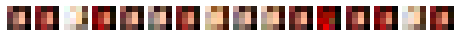


Model resolution:8x8
Phase.TRANSITION
10000/10000 [==============================] - 416s 42ms/step - d_loss: -3.4962 - g_loss: 3.3564


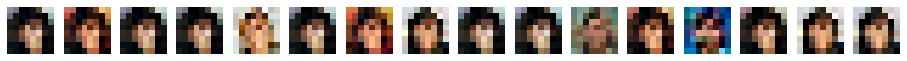

Phase.STABLE
10000/10000 [==============================] - 415s 42ms/step - d_loss: -2.4605 - g_loss: 1.9036


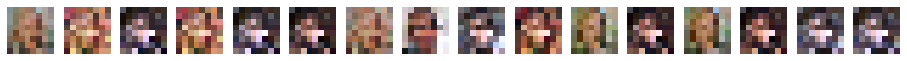


Model resolution:16x16
Phase.TRANSITION
10000/10000 [==============================] - 877s 88ms/step - d_loss: -2.6629 - g_loss: 2.8449


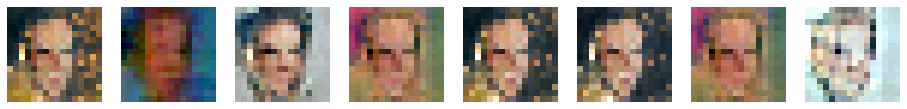

Phase.STABLE
10000/10000 [==============================] - 875s 88ms/step - d_loss: -1.8688 - g_loss: 1.7085


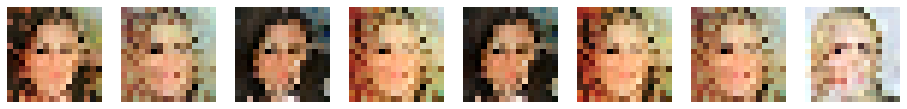


Model resolution:32x32
Phase.TRANSITION
10000/10000 [==============================] - 2153s 215ms/step - d_loss: -2.8366 - g_loss: 2.9978


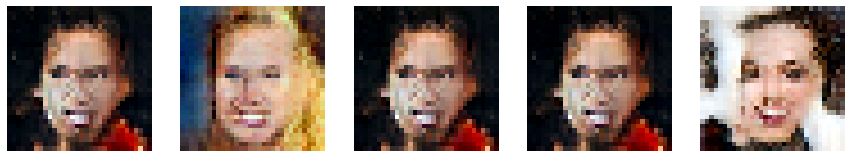

Phase.STABLE
10000/10000 [==============================] - 2150s 215ms/step - d_loss: -3.0600 - g_loss: 2.1443


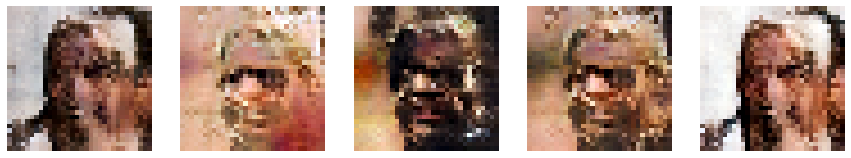


Model resolution:64x64
Phase.TRANSITION
10000/10000 [==============================] - 4405s 440ms/step - d_loss: -3.0276 - g_loss: 4.0549


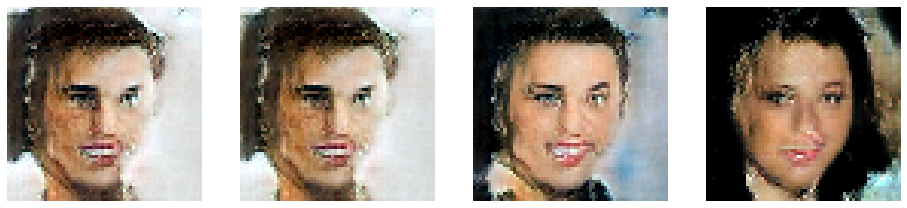

Phase.STABLE
10000/10000 [==============================] - 4416s 442ms/step - d_loss: -5.5916 - g_loss: 3.5169


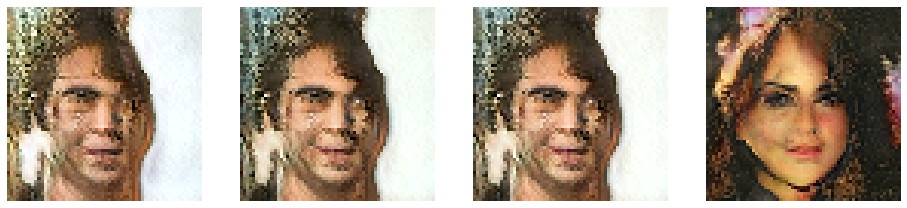

In [19]:
train(steps_per_epoch=10000)

Phase.STABLE
10000/10000 [==============================] - 4403s 440ms/step - d_loss: -3.0449 - g_loss: 3.6187


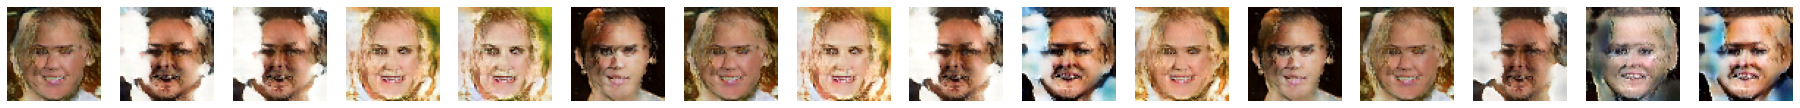

In [31]:
train(64, 64, steps_per_epoch=10000)

## Results
We can now run some inference using pre-trained checkpoints.

In [14]:
"""shell
curl -LO https://github.com/soon-yau/stylegan_keras/releases/download/keras_example/stylegan_64x64.ckpt.zip
unzip stylegan_64x64.ckpt.zip -d ./pretrained/
"""

'shell\ncurl -LO https://github.com/soon-yau/stylegan_keras/releases/download/keras_example/stylegan_64x64.ckpt.zip\nunzip stylegan_64x64.ckpt.zip -d ./pretrained/\n'

In [15]:
style_gan.grow_model(64)
style_gan.load_weights('./pretrained/stylegan_64x64.ckpt')


Model resolution:64x64


ValueError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on ./pretrained/stylegan_64x64.ckpt: Not found: ./pretrained; No such file or directory

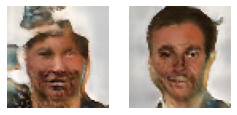

In [49]:
batch_size = 2
z = tf.random.normal((batch_size, style_gan.z_dim))
w = style_gan.mapping(z)
noise = style_gan.generate_noise(batch_size=batch_size)
images = style_gan({'style_code':w, 'noise':noise, 'alpha':1.})
plot_images(images, np.log2(64))

We can also mix styles from two images to create a new image.

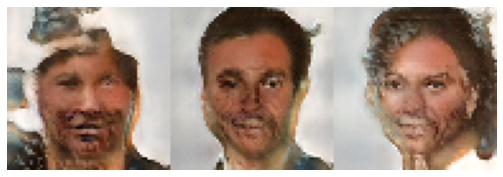

In [50]:
alpha = 0.5
w_mix = np.expand_dims(alpha*w[0] + (1 - alpha)*w[1], 0)
noise = style_gan.generate_noise(batch_size=1)
mix_images = style_gan({'style_code':w_mix, 'noise':noise})
image_row = np.hstack([images[0], images[1], mix_images[0]])
plt.figure(figsize=(9,3))
plt.imshow(image_row);
plt.axis('off');